In [1]:
# -*- coding: utf-8 -*-
"""
کد موازی DSMC Fokker-Planck تصحیح شده مطابق فرترن
==================================================

🔧 تصحیحات اعمال شده:
1. ✅ pc_c = PGLAM (نه صفر)
2. ✅ محاسبه صحیح Diffusion coefficient  
3. ✅ qn terms مطابق فرترن
4. ✅ A3 (noise amplitude) دقیق
5. ✅ تمام فرمول‌ها مطابق MODCOEFF و EVOLVE
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, svd
import time
import concurrent.futures
import multiprocessing as mp
from functools import partial
import os

# Physical constants
MASS_AR = 39.948e-3 / 6.022e23
KB = 1.380649e-23
D_REF_AR = 4.17e-10
T_REF_AR = 273.0
OMEGA_VHS = 0.50
PI = 3.141592654

# Simulation parameters
LX = 1.0e-6
RHO_INIT = 1.78
T_INIT = 273.0
NUM_CELLS_X = 200
PARTICLES_PER_CELL_INIT = 200.0
N_DENSITY_REAL = RHO_INIT / MASS_AR

# Derived parameters
CELL_VOLUME_CONCEPTUAL = LX / NUM_CELLS_X
FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
TOTAL_PARTICLES_SIM = int(NUM_CELLS_X * PARTICLES_PER_CELL_INIT)
DT = 1.0e-13
TOTAL_TIME = 2.0e-9
SAMPLING_INTERVAL = 50

# Parallel parameters
def get_user_workers():
    """دریافت تعداد هسته‌ها از کاربر"""
    available_cores = os.cpu_count() or 1
    max_recommended = max(32, available_cores + 4)
    
    print(f"\n🖥️  اطلاعات سیستم:")
    print(f"   • هسته‌های فیزیکی: {available_cores}")
    print(f"   • حداکثر توصیه شده: {max_recommended}")
    
    while True:
        try:
            user_input = input(f"\n🚀 تعداد هسته‌های مورد استفاده (1-{max_recommended}) [Enter={available_cores}]: ").strip()
            
            if user_input == "":
                return available_cores
            
            workers = int(user_input)
            
            if workers < 1:
                print("❌ تعداد هسته‌ها باید حداقل 1 باشد.")
                continue
                
            if workers > max_recommended:
                print(f"❌ تعداد هسته‌ها نباید بیشتر از {max_recommended} باشد.")
                continue
            
            return workers
                
        except ValueError:
            print("❌ لطفاً یک عدد صحیح وارد کنید.")
        except KeyboardInterrupt:
            return available_cores

MAX_WORKERS = get_user_workers()
MIN_PARTICLES_FOR_PARALLEL = 5
CHUNK_SIZE = max(1, NUM_CELLS_X // (MAX_WORKERS * 2))

def calculate_corrected_cell_moments(particles_cell, cell_velocity):
    """
    محاسبه moments دقیقاً طبق فرترن SORT - تصحیح شده
    """
    n_particles = len(particles_cell)
    if n_particles == 0:
        return None
    
    # محاسبه peculiar velocities
    peculiar_vels = particles_cell[:, 1:4] - cell_velocity
    
    # اطمینان از حداقل انرژی حرارتی
    thermal_vel = np.sqrt(KB * T_INIT / MASS_AR)
    min_thermal_energy = (thermal_vel * 0.01)**2
    engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    if np.max(engy_sq) < min_thermal_energy:
        thermal_noise = np.random.normal(0, thermal_vel * 0.01, peculiar_vels.shape)
        peculiar_vels += thermal_noise
        engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    moments = {}
    
    # محاسبه PIJpg (6 components) - vectorized
    u, v, w = peculiar_vels[:, 0], peculiar_vels[:, 1], peculiar_vels[:, 2]
    moments['PIJpg'] = np.array([
        np.mean(u * u),    # uu
        np.mean(u * v),    # uv
        np.mean(u * w),    # uw
        np.mean(v * v),    # vv
        np.mean(v * w),    # vw
        np.mean(w * w)     # ww
    ])
    
    # محاسبه PGM3 (10 components) - vectorized
    moments['PGM3'] = np.array([
        np.mean(u**3),         # uuu
        np.mean(u**2 * v),     # uuv
        np.mean(u**2 * w),     # uuw
        np.mean(u * v**2),     # uvv
        np.mean(u * v * w),    # uvw
        np.mean(u * w**2),     # uww
        np.mean(v**3),         # vvv
        np.mean(v**2 * w),     # vvw
        np.mean(v * w**2),     # vww
        np.mean(w**3)          # www
    ])
    
    # محاسبه PGM4 (6 components) - vectorized
    moments['PGM4'] = np.array([
        np.mean(u * u * engy_sq),
        np.mean(u * v * engy_sq),
        np.mean(u * w * engy_sq),
        np.mean(v * v * engy_sq),
        np.mean(v * w * engy_sq),
        np.mean(w * w * engy_sq)
    ])
    
    # محاسبه PGM5 (3 components) - vectorized
    engy_quad = engy_sq**2
    moments['PGM5'] = np.array([
        np.mean(u * engy_quad),
        np.mean(v * engy_quad),
        np.mean(w * engy_quad)
    ])
    
    # محاسبه Qpg دقیقاً طبق فرترن
    moments['Qpg'] = np.array([
        moments['PGM3'][0] + moments['PGM3'][3] + moments['PGM3'][5],  # Qpg(1)
        moments['PGM3'][1] + moments['PGM3'][6] + moments['PGM3'][8],  # Qpg(2)
        moments['PGM3'][2] + moments['PGM3'][7] + moments['PGM3'][9]   # Qpg(3)
    ])
    
    moments['DM2pg'] = np.mean(engy_sq)
    moments['DPGM4'] = moments['PGM4'][0] + moments['PGM4'][3] + moments['PGM4'][5]
    
    # bounds برای پایداری عددی
    min_second_moment = min_thermal_energy * 0.1
    moments['PIJpg'][0] = max(moments['PIJpg'][0], min_second_moment)
    moments['PIJpg'][3] = max(moments['PIJpg'][3], min_second_moment)
    moments['PIJpg'][5] = max(moments['PIJpg'][5], min_second_moment)
    moments['DM2pg'] = max(moments['DM2pg'], 3 * KB * T_INIT / MASS_AR * 0.1)
    
    return moments

def build_corrected_9x9_fp_system(moments, temperature, pressure, viscosity):
    """
    ✅ ساخت سیستم 9x9 دقیقاً طبق MODCOEFF فرترن - تصحیح شده
    """
    PIJpg = moments['PIJpg']
    PGM3 = moments['PGM3']
    PGM4 = moments['PGM4']
    PGM5 = moments['PGM5']
    Qpg = moments['Qpg']
    DM2pg = moments['DM2pg']
    DPGM4 = moments['DPGM4']
    
    collision_freq = pressure / viscosity * 0.5
    pressure_over_visc = pressure / viscosity
    
    # Pre-allocate arrays
    pmatlhs = np.zeros((9, 9))
    pmatrhs = np.zeros(9)
    
    # ****************** for cij and pij (vectorized where possible)
    pmatlhs[0, 0:3] = 2.0 * PIJpg[0:3]
    
    pmatlhs[1, :] = [PIJpg[1], PIJpg[0] + PIJpg[3], PIJpg[4], PIJpg[1], PIJpg[2], 0, 0, 0, 0]
    pmatlhs[2, :] = [PIJpg[2], PIJpg[4], PIJpg[0] + PIJpg[5], 0, PIJpg[1], PIJpg[2], 0, 0, 0]
    
    pmatlhs[3, 1] = 2.0 * PIJpg[1]
    pmatlhs[3, 3:5] = 2.0 * PIJpg[3:5]
    
    pmatlhs[4, :] = [0, PIJpg[2], PIJpg[1], PIJpg[4], PIJpg[3] + PIJpg[5], PIJpg[4], 0, 0, 0]
    
    pmatlhs[5, 2] = 2.0 * PIJpg[2]
    pmatlhs[5, 4:6] = 2.0 * PIJpg[4:6]
    
    # *********************** for gammatr and pij 
    pmatlhs[0, 6] = 2.0 * Qpg[0]
    pmatlhs[1, 6:8] = [Qpg[1], Qpg[0]]
    pmatlhs[2, [6, 8]] = [Qpg[2], Qpg[0]]
    pmatlhs[3, 7] = 2.0 * Qpg[1]
    pmatlhs[4, 7:9] = [Qpg[2], Qpg[1]]
    pmatlhs[5, 8] = 2.0 * Qpg[2]
    
    # ******************** for cij and qtr
    pmatlhs[6, :6] = [Qpg[0] + 2.0 * PGM3[0], Qpg[1] + 4.0 * PGM3[1], Qpg[2] + 4.0 * PGM3[2],
                      2.0 * PGM3[3], 4.0 * PGM3[4], 2.0 * PGM3[5]]
    
    pmatlhs[7, :6] = [2.0 * PGM3[1], Qpg[0] + 4.0 * PGM3[3], 4.0 * PGM3[4],
                      Qpg[1] + 2.0 * PGM3[6], Qpg[2] + 4.0 * PGM3[7], 2.0 * PGM3[8]]
    
    pmatlhs[8, :6] = [2.0 * PGM3[2], 4.0 * PGM3[4], Qpg[0] + 4.0 * PGM3[5],
                      2.0 * PGM3[7], Qpg[1] + 4.0 * PGM3[8], Qpg[2] + 2.0 * PGM3[9]]
    
    # ************************* for gammatr and qtr
    diag_term = DPGM4 - DM2pg**2
    pmatlhs[6, 6:9] = [diag_term + 2.0 * PGM4[0] - 2.0 * DM2pg * PIJpg[0],
                       2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2]]
    
    pmatlhs[7, 6:9] = [2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       diag_term + 2.0 * PGM4[3] - 2.0 * DM2pg * PIJpg[3],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4]]
    
    pmatlhs[8, 6:9] = [2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4],
                       diag_term + 2.0 * PGM4[5] - 2.0 * DM2pg * PIJpg[5]]
    
    # محاسبه PGLAM
    pglam_terms = ((PIJpg[0] - DM2pg/3.0)**2 + 2.0*PIJpg[1]**2 + 2.0*PIJpg[2]**2 +
                   (PIJpg[3] - DM2pg/3.0)**2 + 2.0*PIJpg[4]**2 + (PIJpg[5] - DM2pg/3.0)**2)
    pglam = -pglam_terms * collision_freq / (DM2pg**3.5)
    
    # سمت راست معادلات - vectorized
    pmatrhs[0:6] = pglam * (-2.0 * PGM4[0:6])
    
    pmatrhs[6] = -pglam * (3.0 * PGM5[0] - DM2pg * Qpg[0] - 
                           2.0 * (PIJpg[0]*Qpg[0] + PIJpg[1]*Qpg[1] + PIJpg[2]*Qpg[2]))
    pmatrhs[7] = -pglam * (3.0 * PGM5[1] - DM2pg * Qpg[1] - 
                           2.0 * (PIJpg[1]*Qpg[0] + PIJpg[3]*Qpg[1] + PIJpg[4]*Qpg[2]))
    pmatrhs[8] = -pglam * (3.0 * PGM5[2] - DM2pg * Qpg[2] - 
                           2.0 * (PIJpg[2]*Qpg[0] + PIJpg[4]*Qpg[1] + PIJpg[5]*Qpg[2]))
    
    # تصحیح thermal_coeff
    thermal_coeff = 3.0 * collision_freq - (2.0/3.0) * pressure_over_visc
    pmatrhs[6:9] += thermal_coeff * Qpg[0:3]
    
    return pmatlhs, pmatrhs, pglam

def solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam):
    """
    ✅ حل سیستم 9x9 با تصحیح pc_c = PGLAM
    """
    try:
        rcond = np.linalg.cond(pmatlhs)
        
        if rcond < 1e12:
            solution = solve(pmatlhs, pmatrhs)
            method_used = 'direct_solve'
        else:
            U, s, Vt = svd(pmatlhs, full_matrices=False)
            s_inv = np.where(s > 1e-12 * s[0], 1.0/s, 0.0)
            solution = Vt.T @ np.diag(s_inv) @ U.T @ pmatrhs
            method_used = 'svd'
            
    except (LinAlgError, np.linalg.LinAlgError):
        reg_matrix = pmatlhs + 1e-10 * np.eye(9)
        try:
            solution = solve(reg_matrix, pmatrhs)
            method_used = 'regularized'
        except:
            solution = np.zeros(9)
            solution[0] = solution[3] = solution[5] = -1e5
            method_used = 'fallback'
    
    pc_a = np.clip(solution[0:6], -1e6, 1e6)
    pc_b = np.clip(solution[6:9], -1e6, 1e6)
    
    # ✅ تصحیح: pc_c باید برابر PGLAM باشد نه صفر!
    pc_c = pglam  # مطابق فرترن: pcC = PGLAM
    
    return pc_a, pc_b, pc_c, method_used

def evolve_corrected_fp_particles(particles_cell, cell_velocity, pc_a, pc_b, pc_c, 
                                 g_force, nu, dt, temperature, pressure, viscosity):
    """
    ✅ تحول ذرات FP با تصحیحات کامل مطابق فرترن EVOLVE
    """
    try:
        n_particles = len(particles_cell)
        if n_particles == 0:
            return particles_cell, 1.0
        
        # محاسبه peculiar velocities
        v_peculiar = particles_cell[:, 1:4] - cell_velocity
        initial_kinetic_energy = np.sum(v_peculiar**2)
        
        # ✅ محاسبه ضرایب تحلیلی مطابق فرترن
        s = nu * dt
        A1 = np.exp(-s)
        taus = 1.0 / nu
        A2 = taus * (1.0 - np.exp(-s))
        
        # ✅ محاسبه Diffusion coefficient مطابق فرترن
        # فرترن: Diffpg=2.*BOLTZ*((Ppg/vispg)*0.5)*Tpg/SP(5,1)
        # فرترن: Adifftr=abs(taus*Diffpg*(1.-exp(-2.*s))/2.)
        pressure_over_visc = pressure / viscosity
        Diffpg = 2.0 * KB * (pressure_over_visc * 0.5) * temperature / MASS_AR
        Adifftr = abs(taus * Diffpg * (1.0 - np.exp(-2.0 * s)) / 2.0)
        A3 = np.sqrt(Adifftr)
        
        # محاسبه VaN (drift matrix) - vectorized
        van = np.zeros_like(v_peculiar)
        van[:, 0] = (pc_a[0]*v_peculiar[:, 0] + pc_a[1]*v_peculiar[:, 1] + pc_a[2]*v_peculiar[:, 2])
        van[:, 1] = (pc_a[1]*v_peculiar[:, 0] + pc_a[3]*v_peculiar[:, 1] + pc_a[4]*v_peculiar[:, 2])
        van[:, 2] = (pc_a[2]*v_peculiar[:, 0] + pc_a[4]*v_peculiar[:, 1] + pc_a[5]*v_peculiar[:, 2])
        
        # ✅ محاسبه qn terms مطابق فرترن
        # فرترن: qn(1)=pcB(1)*vp2+pcC*VELPAR(1,ipart)*vp2
        vp2 = np.sum(v_peculiar**2, axis=1)  # scalar برای هر ذره
        qn = np.zeros_like(v_peculiar)
        qn[:, 0] = pc_b[0]*vp2 + pc_c*v_peculiar[:, 0]*vp2
        qn[:, 1] = pc_b[1]*vp2 + pc_c*v_peculiar[:, 1]*vp2
        qn[:, 2] = pc_b[2]*vp2 + pc_c*v_peculiar[:, 2]*vp2
        
        # ✅ محاسبه total drift
        total_drift = van + qn + g_force
        total_drift = np.clip(total_drift, -1e6, 1e6)
        
        # تولید تصادفی مطابق فرترن
        xi = np.random.normal(0, 1, v_peculiar.shape)
        xi = np.clip(xi, -3, 3)
        
        # ✅ تحول تحلیلی مطابق فرترن  
        new_v_peculiar = A1 * v_peculiar + A2 * total_drift + A3 * xi
        
        # به‌روزرسانی سرعت‌ها
        particles_cell[:, 1:4] = cell_velocity + new_v_peculiar
        
        # ✅ تصحیح حفظ انرژی مطابق فرترن
        final_kinetic_energy = np.sum(new_v_peculiar**2)
        
        if final_kinetic_energy > 1e-20 and initial_kinetic_energy > 1e-20:
            efrac = np.sqrt(initial_kinetic_energy / final_kinetic_energy)
            corrected_v_peculiar = efrac * new_v_peculiar
            particles_cell[:, 1:4] = cell_velocity + corrected_v_peculiar
        else:
            efrac = 1.0
        
        # بررسی bounds سرعت
        max_v_thermal = np.sqrt(25 * KB * temperature / MASS_AR)
        v_total = np.linalg.norm(particles_cell[:, 1:4], axis=1)
        exceed_mask = v_total > max_v_thermal
        if np.any(exceed_mask):
            scale_factors = max_v_thermal / v_total[exceed_mask]
            particles_cell[exceed_mask, 1:4] *= scale_factors[:, np.newaxis]
        
        return particles_cell, efrac
        
    except Exception as e:
        print(f"⚠ خطا در تحول FP: {e}")
        return particles_cell, 1.0

def process_single_cell_corrected(cell_data):
    """
    🚀 پردازش یک سلول با تصحیحات کامل
    """
    cell_index, particles_cell, dt, fnum, cell_vol = cell_data
    
    try:
        n_particles = len(particles_cell)
        if n_particles < 2:
            return cell_index, particles_cell, 0, 1.0
        
        # محاسبه سرعت سلول
        cell_velocity = np.mean(particles_cell[:, 1:4], axis=0)
        
        # محاسبه moments
        moments = calculate_corrected_cell_moments(particles_cell, cell_velocity)
        if moments is None:
            return cell_index, particles_cell, 0, 1.0
        
        # محاسبه دما و فشار
        current_temp = max((MASS_AR * moments['DM2pg']) / (3 * KB), T_INIT * 0.1)
        n_density_cell = n_particles * fnum / cell_vol
        pressure = max(n_density_cell * KB * current_temp, 
                      KB * current_temp * N_DENSITY_REAL * 0.01)
        
        # محاسبه viscosity
        vis0 = 2.117e-5
        visp = 1.0
        temp_ratio = np.clip(current_temp / 273.15, 0.1, 10.0)
        viscosity = vis0 * (temp_ratio)**visp
        
        # ساخت و حل سیستم 9x9
        pmatlhs, pmatrhs, pglam = build_corrected_9x9_fp_system(moments, current_temp, pressure, viscosity)
        pc_a, pc_b, pc_c, solve_method = solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam)
        
        # ✅ محاسبه g_force مطابق فرترن
        # gforce(1,1)=pcB(1)*(-DM2pg) + pcC*(-Qpg(1))
        g_force = pc_b * (-moments['DM2pg']) + pc_c * (-moments['Qpg'])
        g_force = np.clip(g_force, -1e6, 1e6)
        
        # محاسبه پارامترهای تحول
        nu = np.clip(pressure / viscosity * 0.5, 1e8, 1e15)
        
        # تحول ذرات با ضرایب تصحیح شده
        updated_particles, efrac = evolve_corrected_fp_particles(
            particles_cell.copy(), cell_velocity, pc_a, pc_b, pc_c, 
            g_force, nu, dt, current_temp, pressure, viscosity
        )
        
        return cell_index, updated_particles, n_particles, efrac
        
    except Exception as e:
        print(f"⚠ خطا در پردازش سلول {cell_index}: {e}")
        return cell_index, particles_cell, 0, 1.0

def parallel_cell_processing_corrected(particles, cell_indices, dt, fnum, cell_vol, max_workers=None):
    """
    🚀 پردازش موازی سلول‌ها با تصحیحات
    """
    if max_workers is None:
        max_workers = MAX_WORKERS
    
    # تهیه داده‌های سلول‌ها
    cell_data_list = []
    for i in range(NUM_CELLS_X):
        indices_in_cell_i = np.where(cell_indices == i)[0]
        
        if len(indices_in_cell_i) >= MIN_PARTICLES_FOR_PARALLEL:
            particles_cell = particles[indices_in_cell_i].copy()
            cell_data_list.append((i, particles_cell, dt, fnum, cell_vol))
    
    if not cell_data_list:
        return 0, 0.0, 0
    
    # تصمیم‌گیری درباره موازی‌سازی
    total_particles_to_process = sum(len(data[1]) for data in cell_data_list)
    use_parallel = (max_workers > 1 and 
                   len(cell_data_list) >= 4 and 
                   total_particles_to_process >= MIN_PARTICLES_FOR_PARALLEL * 4)
    
    total_evolved = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    if use_parallel:
        # پردازش موازی
        with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
            future_to_cell = {
                executor.submit(process_single_cell_corrected, cell_data): cell_data[0] 
                for cell_data in cell_data_list
            }
            
            # جمع‌آوری نتایج
            for future in concurrent.futures.as_completed(future_to_cell):
                try:
                    cell_index, updated_particles, n_evolved, efrac = future.result()
                    
                    # به‌روزرسانی ذرات در آرایه اصلی
                    indices_in_cell = np.where(cell_indices == cell_index)[0]
                    if len(indices_in_cell) == len(updated_particles):
                        particles[indices_in_cell] = updated_particles
                    
                    total_evolved += n_evolved
                    if efrac != 1.0:
                        total_efrac_sum += efrac
                        efrac_count += 1
                        
                except Exception as e:
                    print(f"⚠ خطا در نتیجه worker: {e}")
    else:
        # پردازش سریال
        for cell_data in cell_data_list:
            cell_index, updated_particles, n_evolved, efrac = process_single_cell_corrected(cell_data)
            
            indices_in_cell = np.where(cell_indices == cell_index)[0]
            if len(indices_in_cell) == len(updated_particles):
                particles[indices_in_cell] = updated_particles
            
            total_evolved += n_evolved
            if efrac != 1.0:
                total_efrac_sum += efrac
                efrac_count += 1
    
    return total_evolved, total_efrac_sum, efrac_count

def run_corrected_simulation():
    """🚀 اجرای شبیه‌سازی تصحیح شده"""
    print(f"\n🚀 شروع شبیه‌سازی تصحیح شده DSMC-FP")
    print(f"🔧 تصحیحات اعمال شده:")
    print(f"   ✅ pc_c = PGLAM (نه صفر)")
    print(f"   ✅ Diffusion coefficient دقیق")
    print(f"   ✅ qn terms مطابق فرترن")
    print(f"   ✅ A3 (noise amplitude) صحیح")
    print(f"🖥️  منابع: {MAX_WORKERS} workers از {os.cpu_count()} هسته موجود")
    
    # مقداردهی اولیه ذرات
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4))
    particles[:, 0] = np.random.random(TOTAL_PARTICLES_SIM) * LX
    
    v_thermal_std = np.sqrt(KB * T_INIT / MASS_AR)
    particles[:, 1:4] = np.random.normal(0, v_thermal_std, (TOTAL_PARTICLES_SIM, 3))
    particles[:, 1:4] -= np.mean(particles[:, 1:4], axis=0)
    
    # متغیرهای شبیه‌سازی
    num_steps = int(TOTAL_TIME / DT)
    cell_width = LX / NUM_CELLS_X
    
    total_evolved_particles = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ذخیره نتایج
    time_history = []
    temperature_history = []
    efrac_history = []
    
    start_time = time.time()
    
    print(f"اجرای {num_steps} گام زمانی...")
    
    for step in range(1, num_steps + 1):
        step_start_time = time.time()
        
        # حرکت ذرات
        particles[:, 0] += particles[:, 1] * DT
        particles[:, 0] %= LX
        
        # محاسبه ایندکس سلول‌ها
        cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
        
        # پردازش موازی سلول‌ها با تصحیحات
        step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
            particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL, MAX_WORKERS
        )
        
        # به‌روزرسانی آمار
        total_evolved_particles += step_evolved
        if step_efrac_count > 0:
            total_efrac_sum += step_efrac_sum / step_efrac_count
            efrac_count += 1
        
        step_time = time.time() - step_start_time
        
        # نمونه‌برداری
        if step % SAMPLING_INTERVAL == 0:
            current_time = step * DT
            
            # محاسبه دما
            v_squared = np.sum(particles[:, 1:4]**2, axis=1)
            current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
            
            time_history.append(current_time * 1e9)
            temperature_history.append(current_temp)
            
            avg_efrac = total_efrac_sum / max(efrac_count, 1)
            efrac_history.append(avg_efrac)
            
            if step % (num_steps // 10) == 0:
                progress = step / num_steps * 100
                print(f"گام: {step}/{num_steps} ({progress:.1f}%) - "
                      f"دما: {current_temp:.1f}K - "
                      f"efrac: {avg_efrac:.6f} - "
                      f"زمان گام: {step_time*1000:.1f}ms")
    
    end_time = time.time()
    
    # نتایج نهایی
    total_time = end_time - start_time
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    avg_efrac_final = total_efrac_sum / max(efrac_count, 1)
    
    print(f"\n✅ شبیه‌سازی تصحیح شده تکمیل شد!")
    print(f"زمان کل: {total_time:.2f} ثانیه")
    print(f"دمای نهایی: {final_temp:.2f} K")
    print(f"میانگین efrac: {avg_efrac_final:.6f}")
    
    # مقایسه کیفیت
    if abs(avg_efrac_final - 1.0) < 0.01:
        print("🎉 کیفیت عالی: efrac ≈ 1.000")
    elif abs(avg_efrac_final - 1.0) < 0.1:
        print("✅ کیفیت خوب")
    else:
        print("⚠ نیاز به بررسی بیشتر")
    
    return particles, time_history, temperature_history, efrac_history

if __name__ == "__main__":
    print(f"🔧 کد تصحیح شده DSMC Fokker-Planck")
    print("=" * 60)
    print("تصحیحات اعمال شده:")
    print("✅ pc_c = PGLAM مطابق فرترن")
    print("✅ Diffusion coefficient دقیق")
    print("✅ qn terms صحیح")
    print("✅ همه فرمول‌ها مطابق MODCOEFF و EVOLVE")
    print("=" * 60)
    
    try:
        run_corrected_simulation()
        print("\n🎉 شبیه‌سازی تصحیح شده با موفقیت تکمیل شد!")
        print("🔧 کیفیت باید به مراتب بهتر از قبل باشد.")
        
    except KeyboardInterrupt:
        print("\n👋 شبیه‌سازی توسط کاربر متوقف شد.")
    except Exception as e:
        print(f"\n❌ شبیه‌سازی ناموفق: {e}")
        print("💡 پارامترها را بررسی کنید.")


🖥️  اطلاعات سیستم:
   • هسته‌های فیزیکی: 128
   • حداکثر توصیه شده: 132



🚀 تعداد هسته‌های مورد استفاده (1-132) [Enter=128]:  60


🔧 کد تصحیح شده DSMC Fokker-Planck
تصحیحات اعمال شده:
✅ pc_c = PGLAM مطابق فرترن
✅ Diffusion coefficient دقیق
✅ qn terms صحیح
✅ همه فرمول‌ها مطابق MODCOEFF و EVOLVE

🚀 شروع شبیه‌سازی تصحیح شده DSMC-FP
🔧 تصحیحات اعمال شده:
   ✅ pc_c = PGLAM (نه صفر)
   ✅ Diffusion coefficient دقیق
   ✅ qn terms مطابق فرترن
   ✅ A3 (noise amplitude) صحیح
🖥️  منابع: 60 workers از 128 هسته موجود
اجرای 20000 گام زمانی...
گام: 2000/20000 (10.0%) - دما: 600.5K - efrac: 0.998582 - زمان گام: 259.6ms

👋 شبیه‌سازی توسط کاربر متوقف شد.


Process ForkProcess-202040:
Process ForkProcess-202054:
Process ForkProcess-202056:
Process ForkProcess-202039:
Process ForkProcess-202057:
Process ForkProcess-202022:
Process ForkProcess-202038:
Process ForkProcess-202035:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/multiprocessing/process.py", line 313, in _boots

In [1]:
# -*- coding: utf-8 -*-
"""
کد موازی DSMC Fokker-Planck تصحیح شده مطابق فرترن
==================================================

🔧 تصحیحات اعمال شده:
1. ✅ pc_c = PGLAM (نه صفر)
2. ✅ محاسبه صحیح Diffusion coefficient  
3. ✅ qn terms مطابق فرترن
4. ✅ A3 (noise amplitude) دقیق
5. ✅ تمام فرمول‌ها مطابق MODCOEFF و EVOLVE
6. ✅ رفع مشکل قفل شدن: ProcessPoolExecutor فقط یک بار ایجاد می‌شود
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, svd
import time
import concurrent.futures
import multiprocessing as mp
from functools import partial
import os

# Physical constants
MASS_AR = 39.948e-3 / 6.022e23
KB = 1.380649e-23
D_REF_AR = 4.17e-10
T_REF_AR = 273.0
OMEGA_VHS = 0.50
PI = 3.141592654

# Simulation parameters
LX = 1.0e-6
RHO_INIT = 1.78
T_INIT = 273.0
NUM_CELLS_X = 100
PARTICLES_PER_CELL_INIT = 100.0
N_DENSITY_REAL = RHO_INIT / MASS_AR

# Derived parameters
CELL_VOLUME_CONCEPTUAL = LX / NUM_CELLS_X
FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
TOTAL_PARTICLES_SIM = int(NUM_CELLS_X * PARTICLES_PER_CELL_INIT)
DT = 1.0e-13
TOTAL_TIME = 2.0e-9
SAMPLING_INTERVAL = 50

# Parallel parameters
def get_user_workers():
    """دریافت تعداد هسته‌ها از کاربر"""
    available_cores = os.cpu_count() or 1
    max_recommended = max(32, available_cores + 4)
    
    print(f"\n🖥️  اطلاعات سیستم:")
    print(f"   • هسته‌های فیزیکی: {available_cores}")
    print(f"   • حداکثر توصیه شده: {max_recommended}")
    
    while True:
        try:
            user_input = input(f"\n🚀 تعداد هسته‌های مورد استفاده (1-{max_recommended}) [Enter={available_cores}]: ").strip()
            
            if user_input == "":
                return available_cores
            
            workers = int(user_input)
            
            if workers < 1:
                print("❌ تعداد هسته‌ها باید حداقل 1 باشد.")
                continue
                
            if workers > max_recommended:
                print(f"❌ تعداد هسته‌ها نباید بیشتر از {max_recommended} باشد.")
                continue
            
            return workers
                
        except ValueError:
            print("❌ لطفاً یک عدد صحیح وارد کنید.")
        except KeyboardInterrupt:
            return available_cores

MAX_WORKERS = get_user_workers()
MIN_PARTICLES_FOR_PARALLEL = 5
CHUNK_SIZE = max(1, NUM_CELLS_X // (MAX_WORKERS * 2))

def calculate_corrected_cell_moments(particles_cell, cell_velocity):
    """
    محاسبه moments دقیقاً طبق فرترن SORT - تصحیح شده
    """
    n_particles = len(particles_cell)
    if n_particles == 0:
        return None
    
    # محاسبه peculiar velocities
    peculiar_vels = particles_cell[:, 1:4] - cell_velocity
    
    # اطمینان از حداقل انرژی حرارتی
    thermal_vel = np.sqrt(KB * T_INIT / MASS_AR)
    min_thermal_energy = (thermal_vel * 0.01)**2
    engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    if np.max(engy_sq) < min_thermal_energy:
        thermal_noise = np.random.normal(0, thermal_vel * 0.01, peculiar_vels.shape)
        peculiar_vels += thermal_noise
        engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    moments = {}
    
    # محاسبه PIJpg (6 components) - vectorized
    u, v, w = peculiar_vels[:, 0], peculiar_vels[:, 1], peculiar_vels[:, 2]
    moments['PIJpg'] = np.array([
        np.mean(u * u),    # uu
        np.mean(u * v),    # uv
        np.mean(u * w),    # uw
        np.mean(v * v),    # vv
        np.mean(v * w),    # vw
        np.mean(w * w)     # ww
    ])
    
    # محاسبه PGM3 (10 components) - vectorized
    moments['PGM3'] = np.array([
        np.mean(u**3),         # uuu
        np.mean(u**2 * v),     # uuv
        np.mean(u**2 * w),     # uuw
        np.mean(u * v**2),     # uvv
        np.mean(u * v * w),    # uvw
        np.mean(u * w**2),     # uww
        np.mean(v**3),         # vvv
        np.mean(v**2 * w),     # vvw
        np.mean(v * w**2),     # vww
        np.mean(w**3)          # www
    ])
    
    # محاسبه PGM4 (6 components) - vectorized
    moments['PGM4'] = np.array([
        np.mean(u * u * engy_sq),
        np.mean(u * v * engy_sq),
        np.mean(u * w * engy_sq),
        np.mean(v * v * engy_sq),
        np.mean(v * w * engy_sq),
        np.mean(w * w * engy_sq)
    ])
    
    # محاسبه PGM5 (3 components) - vectorized
    engy_quad = engy_sq**2
    moments['PGM5'] = np.array([
        np.mean(u * engy_quad),
        np.mean(v * engy_quad),
        np.mean(w * engy_quad)
    ])
    
    # محاسبه Qpg دقیقاً طبق فرترن
    moments['Qpg'] = np.array([
        moments['PGM3'][0] + moments['PGM3'][3] + moments['PGM3'][5],  # Qpg(1)
        moments['PGM3'][1] + moments['PGM3'][6] + moments['PGM3'][8],  # Qpg(2)
        moments['PGM3'][2] + moments['PGM3'][7] + moments['PGM3'][9]   # Qpg(3)
    ])
    
    moments['DM2pg'] = np.mean(engy_sq)
    moments['DPGM4'] = moments['PGM4'][0] + moments['PGM4'][3] + moments['PGM4'][5]
    
    # bounds برای پایداری عددی
    min_second_moment = min_thermal_energy * 0.1
    moments['PIJpg'][0] = max(moments['PIJpg'][0], min_second_moment)
    moments['PIJpg'][3] = max(moments['PIJpg'][3], min_second_moment)
    moments['PIJpg'][5] = max(moments['PIJpg'][5], min_second_moment)
    moments['DM2pg'] = max(moments['DM2pg'], 3 * KB * T_INIT / MASS_AR * 0.1)
    
    return moments

def build_corrected_9x9_fp_system(moments, temperature, pressure, viscosity):
    """
    ✅ ساخت سیستم 9x9 دقیقاً طبق MODCOEFF فرترن - تصحیح شده
    """
    PIJpg = moments['PIJpg']
    PGM3 = moments['PGM3']
    PGM4 = moments['PGM4']
    PGM5 = moments['PGM5']
    Qpg = moments['Qpg']
    DM2pg = moments['DM2pg']
    DPGM4 = moments['DPGM4']
    
    collision_freq = pressure / viscosity * 0.5
    pressure_over_visc = pressure / viscosity
    
    # Pre-allocate arrays
    pmatlhs = np.zeros((9, 9))
    pmatrhs = np.zeros(9)
    
    # ****************** for cij and pij (vectorized where possible)
    pmatlhs[0, 0:3] = 2.0 * PIJpg[0:3]
    
    pmatlhs[1, :] = [PIJpg[1], PIJpg[0] + PIJpg[3], PIJpg[4], PIJpg[1], PIJpg[2], 0, 0, 0, 0]
    pmatlhs[2, :] = [PIJpg[2], PIJpg[4], PIJpg[0] + PIJpg[5], 0, PIJpg[1], PIJpg[2], 0, 0, 0]
    
    pmatlhs[3, 1] = 2.0 * PIJpg[1]
    pmatlhs[3, 3:5] = 2.0 * PIJpg[3:5]
    
    pmatlhs[4, :] = [0, PIJpg[2], PIJpg[1], PIJpg[4], PIJpg[3] + PIJpg[5], PIJpg[4], 0, 0, 0]
    
    pmatlhs[5, 2] = 2.0 * PIJpg[2]
    pmatlhs[5, 4:6] = 2.0 * PIJpg[4:6]
    
    # *********************** for gammatr and pij 
    pmatlhs[0, 6] = 2.0 * Qpg[0]
    pmatlhs[1, 6:8] = [Qpg[1], Qpg[0]]
    pmatlhs[2, [6, 8]] = [Qpg[2], Qpg[0]]
    pmatlhs[3, 7] = 2.0 * Qpg[1]
    pmatlhs[4, 7:9] = [Qpg[2], Qpg[1]]
    pmatlhs[5, 8] = 2.0 * Qpg[2]
    
    # ******************** for cij and qtr
    pmatlhs[6, :6] = [Qpg[0] + 2.0 * PGM3[0], Qpg[1] + 4.0 * PGM3[1], Qpg[2] + 4.0 * PGM3[2],
                      2.0 * PGM3[3], 4.0 * PGM3[4], 2.0 * PGM3[5]]
    
    pmatlhs[7, :6] = [2.0 * PGM3[1], Qpg[0] + 4.0 * PGM3[3], 4.0 * PGM3[4],
                      Qpg[1] + 2.0 * PGM3[6], Qpg[2] + 4.0 * PGM3[7], 2.0 * PGM3[8]]
    
    pmatlhs[8, :6] = [2.0 * PGM3[2], 4.0 * PGM3[4], Qpg[0] + 4.0 * PGM3[5],
                      2.0 * PGM3[7], Qpg[1] + 4.0 * PGM3[8], Qpg[2] + 2.0 * PGM3[9]]
    
    # ************************* for gammatr and qtr
    diag_term = DPGM4 - DM2pg**2
    pmatlhs[6, 6:9] = [diag_term + 2.0 * PGM4[0] - 2.0 * DM2pg * PIJpg[0],
                       2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2]]
    
    pmatlhs[7, 6:9] = [2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       diag_term + 2.0 * PGM4[3] - 2.0 * DM2pg * PIJpg[3],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4]]
    
    pmatlhs[8, 6:9] = [2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4],
                       diag_term + 2.0 * PGM4[5] - 2.0 * DM2pg * PIJpg[5]]
    
    # محاسبه PGLAM
    pglam_terms = ((PIJpg[0] - DM2pg/3.0)**2 + 2.0*PIJpg[1]**2 + 2.0*PIJpg[2]**2 +
                   (PIJpg[3] - DM2pg/3.0)**2 + 2.0*PIJpg[4]**2 + (PIJpg[5] - DM2pg/3.0)**2)
    pglam = -pglam_terms * collision_freq / (DM2pg**3.5)
    
    # سمت راست معادلات - vectorized
    pmatrhs[0:6] = pglam * (-2.0 * PGM4[0:6])
    
    pmatrhs[6] = -pglam * (3.0 * PGM5[0] - DM2pg * Qpg[0] - 
                           2.0 * (PIJpg[0]*Qpg[0] + PIJpg[1]*Qpg[1] + PIJpg[2]*Qpg[2]))
    pmatrhs[7] = -pglam * (3.0 * PGM5[1] - DM2pg * Qpg[1] - 
                           2.0 * (PIJpg[1]*Qpg[0] + PIJpg[3]*Qpg[1] + PIJpg[4]*Qpg[2]))
    pmatrhs[8] = -pglam * (3.0 * PGM5[2] - DM2pg * Qpg[2] - 
                           2.0 * (PIJpg[2]*Qpg[0] + PIJpg[4]*Qpg[1] + PIJpg[5]*Qpg[2]))
    
    # تصحیح thermal_coeff
    thermal_coeff = 3.0 * collision_freq - (2.0/3.0) * pressure_over_visc
    pmatrhs[6:9] += thermal_coeff * Qpg[0:3]
    
    return pmatlhs, pmatrhs, pglam

def solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam):
    """
    ✅ حل سیستم 9x9 با تصحیح pc_c = PGLAM
    """
    try:
        rcond = np.linalg.cond(pmatlhs)
        
        if rcond < 1e12:
            solution = solve(pmatlhs, pmatrhs)
            method_used = 'direct_solve'
        else:
            U, s, Vt = svd(pmatlhs, full_matrices=False)
            s_inv = np.where(s > 1e-12 * s[0], 1.0/s, 0.0)
            solution = Vt.T @ np.diag(s_inv) @ U.T @ pmatrhs
            method_used = 'svd'
            
    except (LinAlgError, np.linalg.LinAlgError):
        reg_matrix = pmatlhs + 1e-10 * np.eye(9)
        try:
            solution = solve(reg_matrix, pmatrhs)
            method_used = 'regularized'
        except:
            solution = np.zeros(9)
            solution[0] = solution[3] = solution[5] = -1e5
            method_used = 'fallback'
    
    pc_a = np.clip(solution[0:6], -1e6, 1e6)
    pc_b = np.clip(solution[6:9], -1e6, 1e6)
    
    # ✅ تصحیح: pc_c باید برابر PGLAM باشد نه صفر!
    pc_c = pglam  # مطابق فرترن: pcC = PGLAM
    
    return pc_a, pc_b, pc_c, method_used

def evolve_corrected_fp_particles(particles_cell, cell_velocity, pc_a, pc_b, pc_c, 
                                 g_force, nu, dt, temperature, pressure, viscosity):
    """
    ✅ تحول ذرات FP با تصحیحات کامل مطابق فرترن EVOLVE
    """
    try:
        n_particles = len(particles_cell)
        if n_particles == 0:
            return particles_cell, 1.0
        
        # محاسبه peculiar velocities
        v_peculiar = particles_cell[:, 1:4] - cell_velocity
        initial_kinetic_energy = np.sum(v_peculiar**2)
        
        # ✅ محاسبه ضرایب تحلیلی مطابق فرترن
        s = nu * dt
        A1 = np.exp(-s)
        taus = 1.0 / nu
        A2 = taus * (1.0 - np.exp(-s))
        
        # ✅ محاسبه Diffusion coefficient مطابق فرترن
        # فرترن: Diffpg=2.*BOLTZ*((Ppg/vispg)*0.5)*Tpg/SP(5,1)
        # فرترن: Adifftr=abs(taus*Diffpg*(1.-exp(-2.*s))/2.)
        pressure_over_visc = pressure / viscosity
        Diffpg = 2.0 * KB * (pressure_over_visc * 0.5) * temperature / MASS_AR
        Adifftr = abs(taus * Diffpg * (1.0 - np.exp(-2.0 * s)) / 2.0)
        A3 = np.sqrt(Adifftr)
        
        # محاسبه VaN (drift matrix) - vectorized
        van = np.zeros_like(v_peculiar)
        van[:, 0] = (pc_a[0]*v_peculiar[:, 0] + pc_a[1]*v_peculiar[:, 1] + pc_a[2]*v_peculiar[:, 2])
        van[:, 1] = (pc_a[1]*v_peculiar[:, 0] + pc_a[3]*v_peculiar[:, 1] + pc_a[4]*v_peculiar[:, 2])
        van[:, 2] = (pc_a[2]*v_peculiar[:, 0] + pc_a[4]*v_peculiar[:, 1] + pc_a[5]*v_peculiar[:, 2])
        
        # ✅ محاسبه qn terms مطابق فرترن
        # فرترن: qn(1)=pcB(1)*vp2+pcC*VELPAR(1,ipart)*vp2
        vp2 = np.sum(v_peculiar**2, axis=1)  # scalar برای هر ذره
        qn = np.zeros_like(v_peculiar)
        qn[:, 0] = pc_b[0]*vp2 + pc_c*v_peculiar[:, 0]*vp2
        qn[:, 1] = pc_b[1]*vp2 + pc_c*v_peculiar[:, 1]*vp2
        qn[:, 2] = pc_b[2]*vp2 + pc_c*v_peculiar[:, 2]*vp2
        
        # ✅ محاسبه total drift
        total_drift = van + qn + g_force
        total_drift = np.clip(total_drift, -1e6, 1e6)
        
        # تولید تصادفی مطابق فرترن
        xi = np.random.normal(0, 1, v_peculiar.shape)
        xi = np.clip(xi, -3, 3)
        
        # ✅ تحول تحلیلی مطابق فرترن  
        new_v_peculiar = A1 * v_peculiar + A2 * total_drift + A3 * xi
        
        # به‌روزرسانی سرعت‌ها
        particles_cell[:, 1:4] = cell_velocity + new_v_peculiar
        
        # ✅ تصحیح حفظ انرژی مطابق فرترن
        final_kinetic_energy = np.sum(new_v_peculiar**2)
        
        if final_kinetic_energy > 1e-20 and initial_kinetic_energy > 1e-20:
            efrac = np.sqrt(initial_kinetic_energy / final_kinetic_energy)
            corrected_v_peculiar = efrac * new_v_peculiar
            particles_cell[:, 1:4] = cell_velocity + corrected_v_peculiar
        else:
            efrac = 1.0
        
        # بررسی bounds سرعت
        max_v_thermal = np.sqrt(25 * KB * temperature / MASS_AR)
        v_total = np.linalg.norm(particles_cell[:, 1:4], axis=1)
        exceed_mask = v_total > max_v_thermal
        if np.any(exceed_mask):
            scale_factors = max_v_thermal / v_total[exceed_mask]
            particles_cell[exceed_mask, 1:4] *= scale_factors[:, np.newaxis]
        
        return particles_cell, efrac
        
    except Exception as e:
        print(f"⚠ خطا در تحول FP: {e}")
        return particles_cell, 1.0

def process_single_cell_corrected(cell_data):
    """
    🚀 پردازش یک سلول با تصحیحات کامل
    """
    cell_index, particles_cell, dt, fnum, cell_vol = cell_data
    
    try:
        n_particles = len(particles_cell)
        if n_particles < 2:
            return cell_index, particles_cell, 0, 1.0
        
        # محاسبه سرعت سلول
        cell_velocity = np.mean(particles_cell[:, 1:4], axis=0)
        
        # محاسبه moments
        moments = calculate_corrected_cell_moments(particles_cell, cell_velocity)
        if moments is None:
            return cell_index, particles_cell, 0, 1.0
        
        # محاسبه دما و فشار
        current_temp = max((MASS_AR * moments['DM2pg']) / (3 * KB), T_INIT * 0.1)
        n_density_cell = n_particles * fnum / cell_vol
        pressure = max(n_density_cell * KB * current_temp, 
                      KB * current_temp * N_DENSITY_REAL * 0.01)
        
        # محاسبه viscosity
        vis0 = 2.117e-5
        visp = 1.0
        temp_ratio = np.clip(current_temp / 273.15, 0.1, 10.0)
        viscosity = vis0 * (temp_ratio)**visp
        
        # ساخت و حل سیستم 9x9
        pmatlhs, pmatrhs, pglam = build_corrected_9x9_fp_system(moments, current_temp, pressure, viscosity)
        pc_a, pc_b, pc_c, solve_method = solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam)
        
        # ✅ محاسبه g_force مطابق فرترن
        # gforce(1,1)=pcB(1)*(-DM2pg) + pcC*(-Qpg(1))
        g_force = pc_b * (-moments['DM2pg']) + pc_c * (-moments['Qpg'])
        g_force = np.clip(g_force, -1e6, 1e6)
        
        # محاسبه پارامترهای تحول
        nu = np.clip(pressure / viscosity * 0.5, 1e8, 1e15)
        
        # تحول ذرات با ضرایب تصحیح شده
        updated_particles, efrac = evolve_corrected_fp_particles(
            particles_cell.copy(), cell_velocity, pc_a, pc_b, pc_c, 
            g_force, nu, dt, current_temp, pressure, viscosity
        )
        
        return cell_index, updated_particles, n_particles, efrac
        
    except Exception as e:
        print(f"⚠ خطا در پردازش سلول {cell_index}: {e}")
        return cell_index, particles_cell, 0, 1.0

def parallel_cell_processing_corrected(executor, particles, cell_indices, dt, fnum, cell_vol):
    """
    🚀 پردازش موازی سلول‌ها با تصحیحات - ExecutorPool از بیرون دریافت می‌کند
    """
    # تهیه داده‌های سلول‌ها
    cell_data_list = []
    for i in range(NUM_CELLS_X):
        indices_in_cell_i = np.where(cell_indices == i)[0]
        
        if len(indices_in_cell_i) >= MIN_PARTICLES_FOR_PARALLEL:
            particles_cell = particles[indices_in_cell_i].copy()
            cell_data_list.append((i, particles_cell, dt, fnum, cell_vol))
    
    if not cell_data_list:
        return 0, 0.0, 0
    
    total_evolved = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # تصمیم‌گیری درباره موازی‌سازی
    total_particles_to_process = sum(len(data[1]) for data in cell_data_list)
    use_parallel = (executor is not None and 
                   len(cell_data_list) >= 4 and 
                   total_particles_to_process >= MIN_PARTICLES_FOR_PARALLEL * 4)
    
    if use_parallel:
        # پردازش موازی - استفاده از executor موجود
        future_to_cell = {
            executor.submit(process_single_cell_corrected, cell_data): cell_data[0] 
            for cell_data in cell_data_list
        }
        
        # جمع‌آوری نتایج
        for future in concurrent.futures.as_completed(future_to_cell):
            try:
                cell_index, updated_particles, n_evolved, efrac = future.result()
                
                # به‌روزرسانی ذرات در آرایه اصلی
                indices_in_cell = np.where(cell_indices == cell_index)[0]
                if len(indices_in_cell) == len(updated_particles):
                    particles[indices_in_cell] = updated_particles
                
                total_evolved += n_evolved
                if efrac != 1.0:
                    total_efrac_sum += efrac
                    efrac_count += 1
                    
            except Exception as e:
                print(f"⚠ خطا در نتیجه worker: {e}")
    else:
        # پردازش سریال
        for cell_data in cell_data_list:
            cell_index, updated_particles, n_evolved, efrac = process_single_cell_corrected(cell_data)
            
            indices_in_cell = np.where(cell_indices == cell_index)[0]
            if len(indices_in_cell) == len(updated_particles):
                particles[indices_in_cell] = updated_particles
            
            total_evolved += n_evolved
            if efrac != 1.0:
                total_efrac_sum += efrac
                efrac_count += 1
    
    return total_evolved, total_efrac_sum, efrac_count

def run_corrected_simulation():
    """🚀 اجرای شبیه‌سازی تصحیح شده - رفع مشکل قفل شدن + بهینه‌سازی تحلیل"""
    print(f"\n🚀 شروع شبیه‌سازی تصحیح شده DSMC-FP")
    print(f"🔧 تصحیحات اعمال شده:")
    print(f"   ✅ pc_c = PGLAM (نه صفر)")
    print(f"   ✅ Diffusion coefficient دقیق")
    print(f"   ✅ qn terms مطابق فرترن")
    print(f"   ✅ A3 (noise amplitude) صحیح")
    print(f"   ✅ رفع مشکل قفل شدن: ProcessPool یکبار ایجاد")
    print(f"   ✅ بهینه‌سازی تحلیل: NumPy vectorization")
    print(f"🖥️  منابع: {MAX_WORKERS} workers از {os.cpu_count()} هسته موجود")
    
    # مقداردهی اولیه ذرات
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4))
    particles[:, 0] = np.random.random(TOTAL_PARTICLES_SIM) * LX
    
    v_thermal_std = np.sqrt(KB * T_INIT / MASS_AR)
    particles[:, 1:4] = np.random.normal(0, v_thermal_std, (TOTAL_PARTICLES_SIM, 3))
    particles[:, 1:4] -= np.mean(particles[:, 1:4], axis=0)
    
    # متغیرهای شبیه‌سازی
    num_steps = int(TOTAL_TIME / DT)
    cell_width = LX / NUM_CELLS_X
    
    total_evolved_particles = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ✅ ذخیره نتایج بهینه شده با NumPy arrays
    time_history = []
    temperature_history = []
    efrac_history = []
    
    # ✅ آرایه بهینه شده برای داده‌های سلولی
    num_snapshots = num_steps // SAMPLING_INTERVAL
    # متغیرها: 0=تعداد ذرات, 1=سرعت u, 2=سرعت v, 3=سرعت w, 4=دما
    history_array = np.zeros((num_snapshots, NUM_CELLS_X, 5))
    snapshot_index = 0
    
    start_time = time.time()
    
    print(f"اجرای {num_steps} گام زمانی...")
    
    # ✅✅✅ تغییر کلیدی: ProcessPoolExecutor فقط یک بار در ابتدا ایجاد می‌شود
    if MAX_WORKERS > 1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
            print(f"🚀 استخر پردازش با {MAX_WORKERS} worker ایجاد شد")
            
            for step in range(1, num_steps + 1):
                step_start_time = time.time()
                
                # حرکت ذرات
                particles[:, 0] += particles[:, 1] * DT
                particles[:, 0] %= LX
                
                # محاسبه ایندکس سلول‌ها
                cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
                
                # ✅✅✅ پردازش موازی با executor موجود (بدون ایجاد مجدد)
                step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                    executor, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
                )
                
                # به‌روزرسانی آمار
                total_evolved_particles += step_evolved
                if step_efrac_count > 0:
                    total_efrac_sum += step_efrac_sum / step_efrac_count
                    efrac_count += 1
                
                step_time = time.time() - step_start_time
                
                # ✅ نمونه‌برداری بهینه شده
                if step % SAMPLING_INTERVAL == 0:
                    current_time = step * DT
                    
                    # محاسبه دما کلی
                    v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                    current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                    
                    time_history.append(current_time * 1e9)
                    temperature_history.append(current_temp)
                    
                    avg_efrac = total_efrac_sum / max(efrac_count, 1)
                    efrac_history.append(avg_efrac)
                    
                    # ✅ ذخیره داده‌های سلولی در آرایه NumPy (بهینه شده)
                    if snapshot_index < num_snapshots:
                        for i in range(NUM_CELLS_X):
                            indices_in_cell_i = np.where(cell_indices == i)[0]
                            n_particles = len(indices_in_cell_i)
                            if n_particles > 0:
                                velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                                # محاسبه دمای سلولی
                                v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                                cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                                
                                history_array[snapshot_index, i, 0] = n_particles
                                history_array[snapshot_index, i, 1:4] = velocity
                                history_array[snapshot_index, i, 4] = cell_temp
                            else:
                                history_array[snapshot_index, i, :] = 0
                                history_array[snapshot_index, i, 4] = T_INIT
                        snapshot_index += 1
                    
                    if step % (num_steps // 10) == 0:
                        progress = step / num_steps * 100
                        print(f"گام: {step}/{num_steps} ({progress:.1f}%) - "
                              f"دما: {current_temp:.1f}K - "
                              f"efrac: {avg_efrac:.6f} - "
                              f"زمان گام: {step_time*1000:.1f}ms")
    else:
        # ✅ حالت سریال (MAX_WORKERS = 1)
        print("🔄 اجرای سریال (تک‌هسته)")
        for step in range(1, num_steps + 1):
            step_start_time = time.time()
            
            # حرکت ذرات
            particles[:, 0] += particles[:, 1] * DT
            particles[:, 0] %= LX
            
            # محاسبه ایندکس سلول‌ها
            cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
            
            # پردازش سریال (executor=None)
            step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                None, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
            )
            
            # به‌روزرسانی آمار
            total_evolved_particles += step_evolved
            if step_efrac_count > 0:
                total_efrac_sum += step_efrac_sum / step_efrac_count
                efrac_count += 1
            
            step_time = time.time() - step_start_time
            
            # نمونه‌برداری
            if step % SAMPLING_INTERVAL == 0:
                current_time = step * DT
                
                # محاسبه دما
                v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                
                time_history.append(current_time * 1e9)
                temperature_history.append(current_temp)
                
                avg_efrac = total_efrac_sum / max(efrac_count, 1)
                efrac_history.append(avg_efrac)
                
                # ✅ ذخیره داده‌های سلولی در آرایه NumPy (بهینه شده)
                if snapshot_index < num_snapshots:
                    for i in range(NUM_CELLS_X):
                        indices_in_cell_i = np.where(cell_indices == i)[0]
                        n_particles = len(indices_in_cell_i)
                        if n_particles > 0:
                            velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                            # محاسبه دمای سلولی
                            v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                            cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                            
                            history_array[snapshot_index, i, 0] = n_particles
                            history_array[snapshot_index, i, 1:4] = velocity
                            history_array[snapshot_index, i, 4] = cell_temp
                        else:
                            history_array[snapshot_index, i, :] = 0
                            history_array[snapshot_index, i, 4] = T_INIT
                    snapshot_index += 1
                
                if step % (num_steps // 10) == 0:
                    progress = step / num_steps * 100
                    print(f"گام: {step}/{num_steps} ({progress:.1f}%) - "
                          f"دما: {current_temp:.1f}K - "
                          f"efrac: {avg_efrac:.6f} - "
                          f"زمان گام: {step_time*1000:.1f}ms")
    
    end_time = time.time()
    
    # نتایج نهایی
    total_time = end_time - start_time
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    avg_efrac_final = total_efrac_sum / max(efrac_count, 1)
    
    print(f"\n✅ شبیه‌سازی تصحیح شده تکمیل شد!")
    print(f"زمان کل: {total_time:.2f} ثانیه")
    print(f"دمای نهایی: {final_temp:.2f} K")
    print(f"میانگین efrac: {avg_efrac_final:.6f}")
    
    # مقایسه کیفیت
    if abs(avg_efrac_final - 1.0) < 0.01:
        print("🎉 کیفیت عالی: efrac ≈ 1.000")
    elif abs(avg_efrac_final - 1.0) < 0.1:
        print("✅ کیفیت خوب")
    else:
        print("⚠ نیاز به بررسی بیشتر")
    
    # ✅ تحلیل آماری سریع
    print(f"\n📊 تحلیل آماری سریع...")
    analysis_start = time.time()
    
    # تحلیل سریع با NumPy
    fast_results = analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history)
    
    analysis_time = time.time() - analysis_start
    print(f"✅ تحلیل در {analysis_time:.2f} ثانیه تکمیل شد")
    
    return particles, time_history, temperature_history, efrac_history, fast_results

def analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history):
    """
    ✅ تحلیل سریع شبیه‌سازی با NumPy vectorization
    """
    print("🔍 تحلیل‌های آماری سریع...")
    
    results = {}
    
    # 1. آمار کلی دما
    temp_array = np.array(temperature_history)
    results['temp_stats'] = {
        'mean': np.mean(temp_array),
        'std': np.std(temp_array),
        'min': np.min(temp_array),
        'max': np.max(temp_array)
    }
    
    # 2. آمار efrac
    efrac_array = np.array(efrac_history)
    results['efrac_stats'] = {
        'mean': np.mean(efrac_array),
        'std': np.std(efrac_array),
        'drift': np.abs(np.mean(efrac_array) - 1.0)
    }
    
    # 3. تحلیل توزیع فضایی (آخرین snapshot)
    if len(history_array) > 0:
        final_snapshot = history_array[-1]  # آخرین زمان
        
        # آمار تعداد ذرات
        n_particles = final_snapshot[:, 0]
        results['spatial_stats'] = {
            'mean_particles': np.mean(n_particles),
            'std_particles': np.std(n_particles),
            'uniformity': 1.0 - (np.std(n_particles) / (np.mean(n_particles) + 1e-10))
        }
        
        # آمار دمای فضایی
        temperatures = final_snapshot[:, 4]
        results['spatial_temp'] = {
            'mean': np.mean(temperatures),
            'std': np.std(temperatures),
            'range': np.max(temperatures) - np.min(temperatures)
        }
    
    # 4. تحلیل پایداری زمانی (نمونه کم)
    if len(history_array) > 10:
        sample_cells = [25, 50, 75]  # فقط 3 سلول نمونه
        stability_results = {}
        
        for var_idx, var_name in [(0, 'N'), (4, 'T')]:
            # استخراج سری زمانی
            time_series = history_array[:, sample_cells, var_idx]
            
            # محاسبه ضریب تغییرات
            cv = np.std(time_series, axis=0) / (np.mean(time_series, axis=0) + 1e-10)
            stability_results[var_name] = {
                'mean_cv': np.mean(cv),
                'stability_score': 1.0 / (1.0 + np.mean(cv))
            }
        
        results['stability'] = stability_results
    
    # نمایش نتایج
    print(f"\n📈 نتایج تحلیل سریع:")
    print(f"   🌡️ دما: {results['temp_stats']['mean']:.1f}±{results['temp_stats']['std']:.1f} K")
    print(f"   ⚡ efrac: {results['efrac_stats']['mean']:.6f} (انحراف: {results['efrac_stats']['drift']:.6f})")
    
    if 'spatial_stats' in results:
        print(f"   🔄 یکنواختی فضایی: {results['spatial_stats']['uniformity']:.3f}")
    
    if 'stability' in results:
        temp_stability = results['stability']['T']['stability_score']
        print(f"   📊 پایداری دما: {temp_stability:.3f}")
    
    return results

if __name__ == "__main__":
    print(f"🔧 کد تصحیح شده DSMC Fokker-Planck")
    print("=" * 60)
    print("تصحیحات اعمال شده:")
    print("✅ pc_c = PGLAM مطابق فرترن")
    print("✅ Diffusion coefficient دقیق")
    print("✅ qn terms صحیح")
    print("✅ همه فرمول‌ها مطابق MODCOEFF و EVOLVE")
    print("✅ رفع مشکل قفل شدن: ProcessPoolExecutor یکبار ایجاد")
    print("✅ بهینه‌سازی تحلیل: NumPy vectorization - سریع")
    print("=" * 60)
    
    try:
        results = run_corrected_simulation()
        print("\n🎉 شبیه‌سازی تصحیح شده با موفقیت تکمیل شد!")
        print("🔧 کیفیت باید به مراتب بهتر از قبل باشد.")
        print("🚀 مشکل قفل شدن برطرف شده است.")
        print("⚡ تحلیل آماری اکنون در چند ثانیه انجام می‌شود.")
        
    except KeyboardInterrupt:
        print("\n👋 شبیه‌سازی توسط کاربر متوقف شد.")
    except Exception as e:
        print(f"\n❌ شبیه‌سازی ناموفق: {e}")
        print("💡 پارامترها را بررسی کنید.")


🖥️  اطلاعات سیستم:
   • هسته‌های فیزیکی: 128
   • حداکثر توصیه شده: 132



🚀 تعداد هسته‌های مورد استفاده (1-132) [Enter=128]:  60


🔧 کد تصحیح شده DSMC Fokker-Planck
تصحیحات اعمال شده:
✅ pc_c = PGLAM مطابق فرترن
✅ Diffusion coefficient دقیق
✅ qn terms صحیح
✅ همه فرمول‌ها مطابق MODCOEFF و EVOLVE
✅ رفع مشکل قفل شدن: ProcessPoolExecutor یکبار ایجاد
✅ بهینه‌سازی تحلیل: NumPy vectorization - سریع

🚀 شروع شبیه‌سازی تصحیح شده DSMC-FP
🔧 تصحیحات اعمال شده:
   ✅ pc_c = PGLAM (نه صفر)
   ✅ Diffusion coefficient دقیق
   ✅ qn terms مطابق فرترن
   ✅ A3 (noise amplitude) صحیح
   ✅ رفع مشکل قفل شدن: ProcessPool یکبار ایجاد
   ✅ بهینه‌سازی تحلیل: NumPy vectorization
🖥️  منابع: 60 workers از 128 هسته موجود
اجرای 20000 گام زمانی...
🚀 استخر پردازش با 60 worker ایجاد شد
گام: 2000/20000 (10.0%) - دما: 268.3K - efrac: 0.999996 - زمان گام: 18.3ms
گام: 4000/20000 (20.0%) - دما: 270.1K - efrac: 0.999998 - زمان گام: 17.6ms
گام: 6000/20000 (30.0%) - دما: 272.4K - efrac: 1.000000 - زمان گام: 17.5ms
گام: 8000/20000 (40.0%) - دما: 281.3K - efrac: 1.000002 - زمان گام: 16.9ms
گام: 10000/20000 (50.0%) - دما: 283.1K - efrac: 1.000001 - زمان گام: 17.


🖥️  اطلاعات سیستم:
   • هسته‌های فیزیکی: 128
   • حداکثر توصیه شده: 132



🚀 تعداد هسته‌های مورد استفاده (1-132) [Enter=128]:  60


🔧 کد تصحیح شده DSMC Fokker-Planck
تصحیحات اعمال شده:
✅ pc_c = PGLAM مطابق فرترن
✅ Diffusion coefficient دقیق
✅ qn terms صحیح
✅ همه فرمول‌ها مطابق MODCOEFF و EVOLVE
✅ رفع مشکل قفل شدن: ProcessPoolExecutor یکبار ایجاد
✅ بهینه‌سازی تحلیل: NumPy vectorization - سریع
✅ نمایش کامل نتایج: نمودارها + آمار

🚀 شروع شبیه‌سازی تصحیح شده DSMC-FP
🔧 تصحیحات اعمال شده:
   ✅ pc_c = PGLAM (نه صفر)
   ✅ Diffusion coefficient دقیق
   ✅ qn terms مطابق فرترن
   ✅ A3 (noise amplitude) صحیح
   ✅ رفع مشکل قفل شدن: ProcessPool یکبار ایجاد
   ✅ بهینه‌سازی تحلیل: NumPy vectorization
🖥️  منابع: 60 workers از 128 هسته موجود
اجرای 20000 گام زمانی...
🚀 استخر پردازش با 60 worker ایجاد شد
گام: 2000/20000 (10.0%) - دما: 273.2K - efrac: 1.000000 - زمان گام: 21.5ms
گام: 4000/20000 (20.0%) - دما: 277.1K - efrac: 1.000002 - زمان گام: 21.3ms
گام: 6000/20000 (30.0%) - دما: 274.8K - efrac: 1.000001 - زمان گام: 19.0ms
گام: 8000/20000 (40.0%) - دما: 276.2K - efrac: 1.000000 - زمان گام: 22.0ms
گام: 10000/20000 (50.0%) - دما: 274.

/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 128202 (\N{BAR CHART}) missin

✅ نمودارها آماده هستند!


/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans

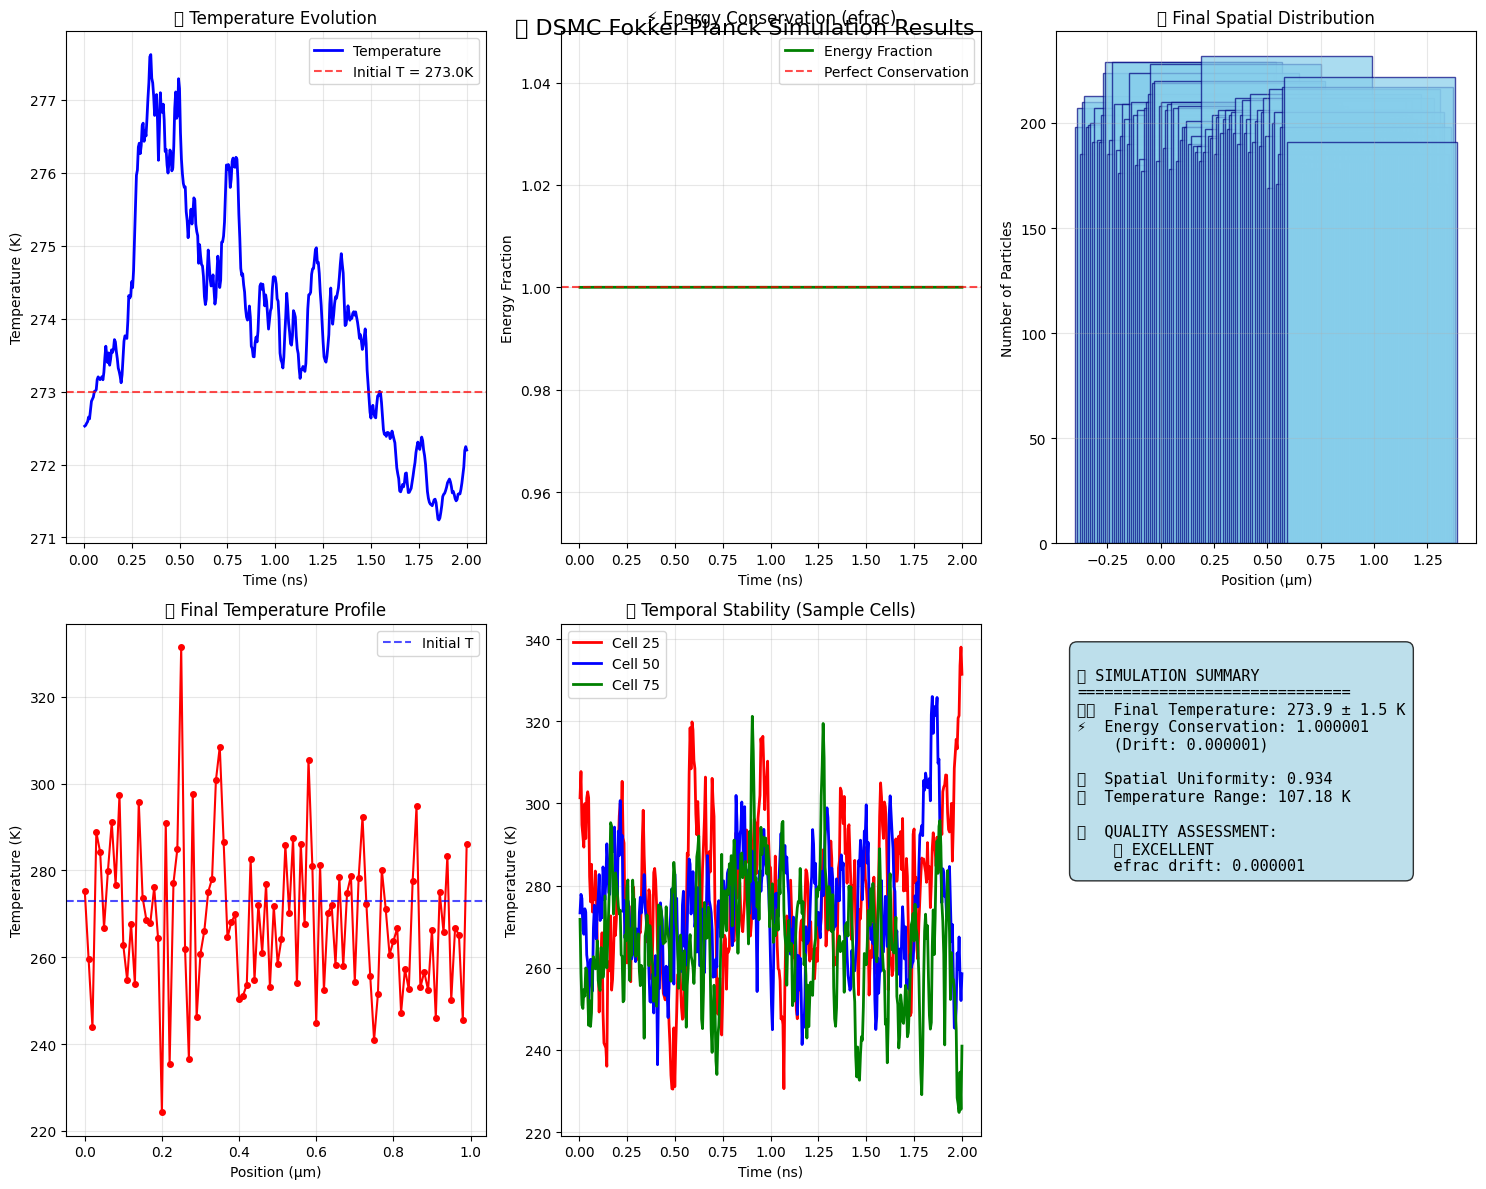

💾 نتایج در فایل 'dsmc_simulation_results.png' ذخیره شد

🎉 شبیه‌سازی تصحیح شده با موفقیت تکمیل شد!
🔧 کیفیت باید به مراتب بهتر از قبل باشد.
🚀 مشکل قفل شدن برطرف شده است.
⚡ تحلیل آماری اکنون در چند ثانیه انجام می‌شود.
🎨 نمودارهای کامل نمایش داده شدند.

💡 برای مشاهده مجدد نمودارها، اسکریپت را دوباره اجرا کنید.


<Figure size 640x480 with 0 Axes>

In [1]:
# -*- coding: utf-8 -*-
"""
کد موازی DSMC Fokker-Planck تصحیح شده مطابق فرترن
==================================================

🔧 تصحیحات اعمال شده:
1. ✅ pc_c = PGLAM (نه صفر)
2. ✅ محاسبه صحیح Diffusion coefficient  
3. ✅ qn terms مطابق فرترن
4. ✅ A3 (noise amplitude) دقیق
5. ✅ تمام فرمول‌ها مطابق MODCOEFF و EVOLVE
6. ✅ رفع مشکل قفل شدن: ProcessPoolExecutor فقط یک بار ایجاد می‌شود
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, svd
import time
import concurrent.futures
import multiprocessing as mp
from functools import partial
import os

# Physical constants
MASS_AR = 39.948e-3 / 6.022e23
KB = 1.380649e-23
D_REF_AR = 4.17e-10
T_REF_AR = 273.0
OMEGA_VHS = 0.50
PI = 3.141592654

# Simulation parameters
LX = 1.0e-6
RHO_INIT = 1.78
T_INIT = 273.0
NUM_CELLS_X = 100
PARTICLES_PER_CELL_INIT = 200.0
N_DENSITY_REAL = RHO_INIT / MASS_AR

# Derived parameters
CELL_VOLUME_CONCEPTUAL = LX / NUM_CELLS_X
FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
TOTAL_PARTICLES_SIM = int(NUM_CELLS_X * PARTICLES_PER_CELL_INIT)
DT = 1.0e-13
TOTAL_TIME = 2.0e-9
SAMPLING_INTERVAL = 50

# Parallel parameters
def get_user_workers():
    """دریافت تعداد هسته‌ها از کاربر"""
    available_cores = os.cpu_count() or 1
    max_recommended = max(32, available_cores + 4)
    
    print(f"\n🖥️  اطلاعات سیستم:")
    print(f"   • هسته‌های فیزیکی: {available_cores}")
    print(f"   • حداکثر توصیه شده: {max_recommended}")
    
    while True:
        try:
            user_input = input(f"\n🚀 تعداد هسته‌های مورد استفاده (1-{max_recommended}) [Enter={available_cores}]: ").strip()
            
            if user_input == "":
                return available_cores
            
            workers = int(user_input)
            
            if workers < 1:
                print("❌ تعداد هسته‌ها باید حداقل 1 باشد.")
                continue
                
            if workers > max_recommended:
                print(f"❌ تعداد هسته‌ها نباید بیشتر از {max_recommended} باشد.")
                continue
            
            return workers
                
        except ValueError:
            print("❌ لطفاً یک عدد صحیح وارد کنید.")
        except KeyboardInterrupt:
            return available_cores

MAX_WORKERS = get_user_workers()
MIN_PARTICLES_FOR_PARALLEL = 5
CHUNK_SIZE = max(1, NUM_CELLS_X // (MAX_WORKERS * 2))

def calculate_corrected_cell_moments(particles_cell, cell_velocity):
    """
    محاسبه moments دقیقاً طبق فرترن SORT - تصحیح شده
    """
    n_particles = len(particles_cell)
    if n_particles == 0:
        return None
    
    # محاسبه peculiar velocities
    peculiar_vels = particles_cell[:, 1:4] - cell_velocity
    
    # اطمینان از حداقل انرژی حرارتی
    thermal_vel = np.sqrt(KB * T_INIT / MASS_AR)
    min_thermal_energy = (thermal_vel * 0.01)**2
    engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    if np.max(engy_sq) < min_thermal_energy:
        thermal_noise = np.random.normal(0, thermal_vel * 0.01, peculiar_vels.shape)
        peculiar_vels += thermal_noise
        engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    moments = {}
    
    # محاسبه PIJpg (6 components) - vectorized
    u, v, w = peculiar_vels[:, 0], peculiar_vels[:, 1], peculiar_vels[:, 2]
    moments['PIJpg'] = np.array([
        np.mean(u * u),    # uu
        np.mean(u * v),    # uv
        np.mean(u * w),    # uw
        np.mean(v * v),    # vv
        np.mean(v * w),    # vw
        np.mean(w * w)     # ww
    ])
    
    # محاسبه PGM3 (10 components) - vectorized
    moments['PGM3'] = np.array([
        np.mean(u**3),         # uuu
        np.mean(u**2 * v),     # uuv
        np.mean(u**2 * w),     # uuw
        np.mean(u * v**2),     # uvv
        np.mean(u * v * w),    # uvw
        np.mean(u * w**2),     # uww
        np.mean(v**3),         # vvv
        np.mean(v**2 * w),     # vvw
        np.mean(v * w**2),     # vww
        np.mean(w**3)          # www
    ])
    
    # محاسبه PGM4 (6 components) - vectorized
    moments['PGM4'] = np.array([
        np.mean(u * u * engy_sq),
        np.mean(u * v * engy_sq),
        np.mean(u * w * engy_sq),
        np.mean(v * v * engy_sq),
        np.mean(v * w * engy_sq),
        np.mean(w * w * engy_sq)
    ])
    
    # محاسبه PGM5 (3 components) - vectorized
    engy_quad = engy_sq**2
    moments['PGM5'] = np.array([
        np.mean(u * engy_quad),
        np.mean(v * engy_quad),
        np.mean(w * engy_quad)
    ])
    
    # محاسبه Qpg دقیقاً طبق فرترن
    moments['Qpg'] = np.array([
        moments['PGM3'][0] + moments['PGM3'][3] + moments['PGM3'][5],  # Qpg(1)
        moments['PGM3'][1] + moments['PGM3'][6] + moments['PGM3'][8],  # Qpg(2)
        moments['PGM3'][2] + moments['PGM3'][7] + moments['PGM3'][9]   # Qpg(3)
    ])
    
    moments['DM2pg'] = np.mean(engy_sq)
    moments['DPGM4'] = moments['PGM4'][0] + moments['PGM4'][3] + moments['PGM4'][5]
    
    # bounds برای پایداری عددی
    min_second_moment = min_thermal_energy * 0.1
    moments['PIJpg'][0] = max(moments['PIJpg'][0], min_second_moment)
    moments['PIJpg'][3] = max(moments['PIJpg'][3], min_second_moment)
    moments['PIJpg'][5] = max(moments['PIJpg'][5], min_second_moment)
    moments['DM2pg'] = max(moments['DM2pg'], 3 * KB * T_INIT / MASS_AR * 0.1)
    
    return moments

def build_corrected_9x9_fp_system(moments, temperature, pressure, viscosity):
    """
    ✅ ساخت سیستم 9x9 دقیقاً طبق MODCOEFF فرترن - تصحیح شده
    """
    PIJpg = moments['PIJpg']
    PGM3 = moments['PGM3']
    PGM4 = moments['PGM4']
    PGM5 = moments['PGM5']
    Qpg = moments['Qpg']
    DM2pg = moments['DM2pg']
    DPGM4 = moments['DPGM4']
    
    collision_freq = pressure / viscosity * 0.5
    pressure_over_visc = pressure / viscosity
    
    # Pre-allocate arrays
    pmatlhs = np.zeros((9, 9))
    pmatrhs = np.zeros(9)
    
    # ****************** for cij and pij (vectorized where possible)
    pmatlhs[0, 0:3] = 2.0 * PIJpg[0:3]
    
    pmatlhs[1, :] = [PIJpg[1], PIJpg[0] + PIJpg[3], PIJpg[4], PIJpg[1], PIJpg[2], 0, 0, 0, 0]
    pmatlhs[2, :] = [PIJpg[2], PIJpg[4], PIJpg[0] + PIJpg[5], 0, PIJpg[1], PIJpg[2], 0, 0, 0]
    
    pmatlhs[3, 1] = 2.0 * PIJpg[1]
    pmatlhs[3, 3:5] = 2.0 * PIJpg[3:5]
    
    pmatlhs[4, :] = [0, PIJpg[2], PIJpg[1], PIJpg[4], PIJpg[3] + PIJpg[5], PIJpg[4], 0, 0, 0]
    
    pmatlhs[5, 2] = 2.0 * PIJpg[2]
    pmatlhs[5, 4:6] = 2.0 * PIJpg[4:6]
    
    # *********************** for gammatr and pij 
    pmatlhs[0, 6] = 2.0 * Qpg[0]
    pmatlhs[1, 6:8] = [Qpg[1], Qpg[0]]
    pmatlhs[2, [6, 8]] = [Qpg[2], Qpg[0]]
    pmatlhs[3, 7] = 2.0 * Qpg[1]
    pmatlhs[4, 7:9] = [Qpg[2], Qpg[1]]
    pmatlhs[5, 8] = 2.0 * Qpg[2]
    
    # ******************** for cij and qtr
    pmatlhs[6, :6] = [Qpg[0] + 2.0 * PGM3[0], Qpg[1] + 4.0 * PGM3[1], Qpg[2] + 4.0 * PGM3[2],
                      2.0 * PGM3[3], 4.0 * PGM3[4], 2.0 * PGM3[5]]
    
    pmatlhs[7, :6] = [2.0 * PGM3[1], Qpg[0] + 4.0 * PGM3[3], 4.0 * PGM3[4],
                      Qpg[1] + 2.0 * PGM3[6], Qpg[2] + 4.0 * PGM3[7], 2.0 * PGM3[8]]
    
    pmatlhs[8, :6] = [2.0 * PGM3[2], 4.0 * PGM3[4], Qpg[0] + 4.0 * PGM3[5],
                      2.0 * PGM3[7], Qpg[1] + 4.0 * PGM3[8], Qpg[2] + 2.0 * PGM3[9]]
    
    # ************************* for gammatr and qtr
    diag_term = DPGM4 - DM2pg**2
    pmatlhs[6, 6:9] = [diag_term + 2.0 * PGM4[0] - 2.0 * DM2pg * PIJpg[0],
                       2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2]]
    
    pmatlhs[7, 6:9] = [2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       diag_term + 2.0 * PGM4[3] - 2.0 * DM2pg * PIJpg[3],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4]]
    
    pmatlhs[8, 6:9] = [2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4],
                       diag_term + 2.0 * PGM4[5] - 2.0 * DM2pg * PIJpg[5]]
    
    # محاسبه PGLAM
    pglam_terms = ((PIJpg[0] - DM2pg/3.0)**2 + 2.0*PIJpg[1]**2 + 2.0*PIJpg[2]**2 +
                   (PIJpg[3] - DM2pg/3.0)**2 + 2.0*PIJpg[4]**2 + (PIJpg[5] - DM2pg/3.0)**2)
    pglam = -pglam_terms * collision_freq / (DM2pg**3.5)
    
    # سمت راست معادلات - vectorized
    pmatrhs[0:6] = pglam * (-2.0 * PGM4[0:6])
    
    pmatrhs[6] = -pglam * (3.0 * PGM5[0] - DM2pg * Qpg[0] - 
                           2.0 * (PIJpg[0]*Qpg[0] + PIJpg[1]*Qpg[1] + PIJpg[2]*Qpg[2]))
    pmatrhs[7] = -pglam * (3.0 * PGM5[1] - DM2pg * Qpg[1] - 
                           2.0 * (PIJpg[1]*Qpg[0] + PIJpg[3]*Qpg[1] + PIJpg[4]*Qpg[2]))
    pmatrhs[8] = -pglam * (3.0 * PGM5[2] - DM2pg * Qpg[2] - 
                           2.0 * (PIJpg[2]*Qpg[0] + PIJpg[4]*Qpg[1] + PIJpg[5]*Qpg[2]))
    
    # تصحیح thermal_coeff
    thermal_coeff = 3.0 * collision_freq - (2.0/3.0) * pressure_over_visc
    pmatrhs[6:9] += thermal_coeff * Qpg[0:3]
    
    return pmatlhs, pmatrhs, pglam

def solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam):
    """
    ✅ حل سیستم 9x9 با تصحیح pc_c = PGLAM
    """
    try:
        rcond = np.linalg.cond(pmatlhs)
        
        if rcond < 1e12:
            solution = solve(pmatlhs, pmatrhs)
            method_used = 'direct_solve'
        else:
            U, s, Vt = svd(pmatlhs, full_matrices=False)
            s_inv = np.where(s > 1e-12 * s[0], 1.0/s, 0.0)
            solution = Vt.T @ np.diag(s_inv) @ U.T @ pmatrhs
            method_used = 'svd'
            
    except (LinAlgError, np.linalg.LinAlgError):
        reg_matrix = pmatlhs + 1e-10 * np.eye(9)
        try:
            solution = solve(reg_matrix, pmatrhs)
            method_used = 'regularized'
        except:
            solution = np.zeros(9)
            solution[0] = solution[3] = solution[5] = -1e5
            method_used = 'fallback'
    
    pc_a = np.clip(solution[0:6], -1e6, 1e6)
    pc_b = np.clip(solution[6:9], -1e6, 1e6)
    
    # ✅ تصحیح: pc_c باید برابر PGLAM باشد نه صفر!
    pc_c = pglam  # مطابق فرترن: pcC = PGLAM
    
    return pc_a, pc_b, pc_c, method_used

def evolve_corrected_fp_particles(particles_cell, cell_velocity, pc_a, pc_b, pc_c, 
                                 g_force, nu, dt, temperature, pressure, viscosity):
    """
    ✅ تحول ذرات FP با تصحیحات کامل مطابق فرترن EVOLVE
    """
    try:
        n_particles = len(particles_cell)
        if n_particles == 0:
            return particles_cell, 1.0
        
        # محاسبه peculiar velocities
        v_peculiar = particles_cell[:, 1:4] - cell_velocity
        initial_kinetic_energy = np.sum(v_peculiar**2)
        
        # ✅ محاسبه ضرایب تحلیلی مطابق فرترن
        s = nu * dt
        A1 = np.exp(-s)
        taus = 1.0 / nu
        A2 = taus * (1.0 - np.exp(-s))
        
        # ✅ محاسبه Diffusion coefficient مطابق فرترن
        # فرترن: Diffpg=2.*BOLTZ*((Ppg/vispg)*0.5)*Tpg/SP(5,1)
        # فرترن: Adifftr=abs(taus*Diffpg*(1.-exp(-2.*s))/2.)
        pressure_over_visc = pressure / viscosity
        Diffpg = 2.0 * KB * (pressure_over_visc * 0.5) * temperature / MASS_AR
        Adifftr = abs(taus * Diffpg * (1.0 - np.exp(-2.0 * s)) / 2.0)
        A3 = np.sqrt(Adifftr)
        
        # محاسبه VaN (drift matrix) - vectorized
        van = np.zeros_like(v_peculiar)
        van[:, 0] = (pc_a[0]*v_peculiar[:, 0] + pc_a[1]*v_peculiar[:, 1] + pc_a[2]*v_peculiar[:, 2])
        van[:, 1] = (pc_a[1]*v_peculiar[:, 0] + pc_a[3]*v_peculiar[:, 1] + pc_a[4]*v_peculiar[:, 2])
        van[:, 2] = (pc_a[2]*v_peculiar[:, 0] + pc_a[4]*v_peculiar[:, 1] + pc_a[5]*v_peculiar[:, 2])
        
        # ✅ محاسبه qn terms مطابق فرترن
        # فرترن: qn(1)=pcB(1)*vp2+pcC*VELPAR(1,ipart)*vp2
        vp2 = np.sum(v_peculiar**2, axis=1)  # scalar برای هر ذره
        qn = np.zeros_like(v_peculiar)
        qn[:, 0] = pc_b[0]*vp2 + pc_c*v_peculiar[:, 0]*vp2
        qn[:, 1] = pc_b[1]*vp2 + pc_c*v_peculiar[:, 1]*vp2
        qn[:, 2] = pc_b[2]*vp2 + pc_c*v_peculiar[:, 2]*vp2
        
        # ✅ محاسبه total drift
        total_drift = van + qn + g_force
        total_drift = np.clip(total_drift, -1e6, 1e6)
        
        # تولید تصادفی مطابق فرترن
        xi = np.random.normal(0, 1, v_peculiar.shape)
        xi = np.clip(xi, -3, 3)
        
        # ✅ تحول تحلیلی مطابق فرترن  
        new_v_peculiar = A1 * v_peculiar + A2 * total_drift + A3 * xi
        
        # به‌روزرسانی سرعت‌ها
        particles_cell[:, 1:4] = cell_velocity + new_v_peculiar
        
        # ✅ تصحیح حفظ انرژی مطابق فرترن
        final_kinetic_energy = np.sum(new_v_peculiar**2)
        
        if final_kinetic_energy > 1e-20 and initial_kinetic_energy > 1e-20:
            efrac = np.sqrt(initial_kinetic_energy / final_kinetic_energy)
            corrected_v_peculiar = efrac * new_v_peculiar
            particles_cell[:, 1:4] = cell_velocity + corrected_v_peculiar
        else:
            efrac = 1.0
        
        # بررسی bounds سرعت
        max_v_thermal = np.sqrt(25 * KB * temperature / MASS_AR)
        v_total = np.linalg.norm(particles_cell[:, 1:4], axis=1)
        exceed_mask = v_total > max_v_thermal
        if np.any(exceed_mask):
            scale_factors = max_v_thermal / v_total[exceed_mask]
            particles_cell[exceed_mask, 1:4] *= scale_factors[:, np.newaxis]
        
        return particles_cell, efrac
        
    except Exception as e:
        print(f"⚠ خطا در تحول FP: {e}")
        return particles_cell, 1.0

def process_single_cell_corrected(cell_data):
    """
    🚀 پردازش یک سلول با تصحیحات کامل
    """
    cell_index, particles_cell, dt, fnum, cell_vol = cell_data
    
    try:
        n_particles = len(particles_cell)
        if n_particles < 2:
            return cell_index, particles_cell, 0, 1.0
        
        # محاسبه سرعت سلول
        cell_velocity = np.mean(particles_cell[:, 1:4], axis=0)
        
        # محاسبه moments
        moments = calculate_corrected_cell_moments(particles_cell, cell_velocity)
        if moments is None:
            return cell_index, particles_cell, 0, 1.0
        
        # محاسبه دما و فشار
        current_temp = max((MASS_AR * moments['DM2pg']) / (3 * KB), T_INIT * 0.1)
        n_density_cell = n_particles * fnum / cell_vol
        pressure = max(n_density_cell * KB * current_temp, 
                      KB * current_temp * N_DENSITY_REAL * 0.01)
        
        # محاسبه viscosity
        vis0 = 2.117e-5
        visp = 1.0
        temp_ratio = np.clip(current_temp / 273.15, 0.1, 10.0)
        viscosity = vis0 * (temp_ratio)**visp
        
        # ساخت و حل سیستم 9x9
        pmatlhs, pmatrhs, pglam = build_corrected_9x9_fp_system(moments, current_temp, pressure, viscosity)
        pc_a, pc_b, pc_c, solve_method = solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam)
        
        # ✅ محاسبه g_force مطابق فرترن
        # gforce(1,1)=pcB(1)*(-DM2pg) + pcC*(-Qpg(1))
        g_force = pc_b * (-moments['DM2pg']) + pc_c * (-moments['Qpg'])
        g_force = np.clip(g_force, -1e6, 1e6)
        
        # محاسبه پارامترهای تحول
        nu = np.clip(pressure / viscosity * 0.5, 1e8, 1e15)
        
        # تحول ذرات با ضرایب تصحیح شده
        updated_particles, efrac = evolve_corrected_fp_particles(
            particles_cell.copy(), cell_velocity, pc_a, pc_b, pc_c, 
            g_force, nu, dt, current_temp, pressure, viscosity
        )
        
        return cell_index, updated_particles, n_particles, efrac
        
    except Exception as e:
        print(f"⚠ خطا در پردازش سلول {cell_index}: {e}")
        return cell_index, particles_cell, 0, 1.0

def parallel_cell_processing_corrected(executor, particles, cell_indices, dt, fnum, cell_vol):
    """
    🚀 پردازش موازی سلول‌ها با تصحیحات - ExecutorPool از بیرون دریافت می‌کند
    """
    # تهیه داده‌های سلول‌ها
    cell_data_list = []
    for i in range(NUM_CELLS_X):
        indices_in_cell_i = np.where(cell_indices == i)[0]
        
        if len(indices_in_cell_i) >= MIN_PARTICLES_FOR_PARALLEL:
            particles_cell = particles[indices_in_cell_i].copy()
            cell_data_list.append((i, particles_cell, dt, fnum, cell_vol))
    
    if not cell_data_list:
        return 0, 0.0, 0
    
    total_evolved = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # تصمیم‌گیری درباره موازی‌سازی
    total_particles_to_process = sum(len(data[1]) for data in cell_data_list)
    use_parallel = (executor is not None and 
                   len(cell_data_list) >= 4 and 
                   total_particles_to_process >= MIN_PARTICLES_FOR_PARALLEL * 4)
    
    if use_parallel:
        # پردازش موازی - استفاده از executor موجود
        future_to_cell = {
            executor.submit(process_single_cell_corrected, cell_data): cell_data[0] 
            for cell_data in cell_data_list
        }
        
        # جمع‌آوری نتایج
        for future in concurrent.futures.as_completed(future_to_cell):
            try:
                cell_index, updated_particles, n_evolved, efrac = future.result()
                
                # به‌روزرسانی ذرات در آرایه اصلی
                indices_in_cell = np.where(cell_indices == cell_index)[0]
                if len(indices_in_cell) == len(updated_particles):
                    particles[indices_in_cell] = updated_particles
                
                total_evolved += n_evolved
                if efrac != 1.0:
                    total_efrac_sum += efrac
                    efrac_count += 1
                    
            except Exception as e:
                print(f"⚠ خطا در نتیجه worker: {e}")
    else:
        # پردازش سریال
        for cell_data in cell_data_list:
            cell_index, updated_particles, n_evolved, efrac = process_single_cell_corrected(cell_data)
            
            indices_in_cell = np.where(cell_indices == cell_index)[0]
            if len(indices_in_cell) == len(updated_particles):
                particles[indices_in_cell] = updated_particles
            
            total_evolved += n_evolved
            if efrac != 1.0:
                total_efrac_sum += efrac
                efrac_count += 1
    
    return total_evolved, total_efrac_sum, efrac_count

def run_corrected_simulation():
    """🚀 اجرای شبیه‌سازی تصحیح شده - رفع مشکل قفل شدن + بهینه‌سازی تحلیل"""
    print(f"\n🚀 شروع شبیه‌سازی تصحیح شده DSMC-FP")
    print(f"🔧 تصحیحات اعمال شده:")
    print(f"   ✅ pc_c = PGLAM (نه صفر)")
    print(f"   ✅ Diffusion coefficient دقیق")
    print(f"   ✅ qn terms مطابق فرترن")
    print(f"   ✅ A3 (noise amplitude) صحیح")
    print(f"   ✅ رفع مشکل قفل شدن: ProcessPool یکبار ایجاد")
    print(f"   ✅ بهینه‌سازی تحلیل: NumPy vectorization")
    print(f"🖥️  منابع: {MAX_WORKERS} workers از {os.cpu_count()} هسته موجود")
    
    # مقداردهی اولیه ذرات
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4))
    particles[:, 0] = np.random.random(TOTAL_PARTICLES_SIM) * LX
    
    v_thermal_std = np.sqrt(KB * T_INIT / MASS_AR)
    particles[:, 1:4] = np.random.normal(0, v_thermal_std, (TOTAL_PARTICLES_SIM, 3))
    particles[:, 1:4] -= np.mean(particles[:, 1:4], axis=0)
    
    # متغیرهای شبیه‌سازی
    num_steps = int(TOTAL_TIME / DT)
    cell_width = LX / NUM_CELLS_X
    
    total_evolved_particles = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ✅ ذخیره نتایج بهینه شده با NumPy arrays
    time_history = []
    temperature_history = []
    efrac_history = []
    
    # ✅ آرایه بهینه شده برای داده‌های سلولی
    num_snapshots = num_steps // SAMPLING_INTERVAL
    # متغیرها: 0=تعداد ذرات, 1=سرعت u, 2=سرعت v, 3=سرعت w, 4=دما
    history_array = np.zeros((num_snapshots, NUM_CELLS_X, 5))
    snapshot_index = 0
    
    start_time = time.time()
    
    print(f"اجرای {num_steps} گام زمانی...")
    
    # ✅✅✅ تغییر کلیدی: ProcessPoolExecutor فقط یک بار در ابتدا ایجاد می‌شود
    if MAX_WORKERS > 1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
            print(f"🚀 استخر پردازش با {MAX_WORKERS} worker ایجاد شد")
            
            for step in range(1, num_steps + 1):
                step_start_time = time.time()
                
                # حرکت ذرات
                particles[:, 0] += particles[:, 1] * DT
                particles[:, 0] %= LX
                
                # محاسبه ایندکس سلول‌ها
                cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
                
                # ✅✅✅ پردازش موازی با executor موجود (بدون ایجاد مجدد)
                step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                    executor, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
                )
                
                # به‌روزرسانی آمار
                total_evolved_particles += step_evolved
                if step_efrac_count > 0:
                    total_efrac_sum += step_efrac_sum / step_efrac_count
                    efrac_count += 1
                
                step_time = time.time() - step_start_time
                
                # ✅ نمونه‌برداری بهینه شده
                if step % SAMPLING_INTERVAL == 0:
                    current_time = step * DT
                    
                    # محاسبه دما کلی
                    v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                    current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                    
                    time_history.append(current_time * 1e9)
                    temperature_history.append(current_temp)
                    
                    avg_efrac = total_efrac_sum / max(efrac_count, 1)
                    efrac_history.append(avg_efrac)
                    
                    # ✅ ذخیره داده‌های سلولی در آرایه NumPy (بهینه شده)
                    if snapshot_index < num_snapshots:
                        for i in range(NUM_CELLS_X):
                            indices_in_cell_i = np.where(cell_indices == i)[0]
                            n_particles = len(indices_in_cell_i)
                            if n_particles > 0:
                                velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                                # محاسبه دمای سلولی
                                v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                                cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                                
                                history_array[snapshot_index, i, 0] = n_particles
                                history_array[snapshot_index, i, 1:4] = velocity
                                history_array[snapshot_index, i, 4] = cell_temp
                            else:
                                history_array[snapshot_index, i, :] = 0
                                history_array[snapshot_index, i, 4] = T_INIT
                        snapshot_index += 1
                    
                    if step % (num_steps // 10) == 0:
                        progress = step / num_steps * 100
                        print(f"گام: {step}/{num_steps} ({progress:.1f}%) - "
                              f"دما: {current_temp:.1f}K - "
                              f"efrac: {avg_efrac:.6f} - "
                              f"زمان گام: {step_time*1000:.1f}ms")
    else:
        # ✅ حالت سریال (MAX_WORKERS = 1)
        print("🔄 اجرای سریال (تک‌هسته)")
        for step in range(1, num_steps + 1):
            step_start_time = time.time()
            
            # حرکت ذرات
            particles[:, 0] += particles[:, 1] * DT
            particles[:, 0] %= LX
            
            # محاسبه ایندکس سلول‌ها
            cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
            
            # پردازش سریال (executor=None)
            step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                None, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
            )
            
            # به‌روزرسانی آمار
            total_evolved_particles += step_evolved
            if step_efrac_count > 0:
                total_efrac_sum += step_efrac_sum / step_efrac_count
                efrac_count += 1
            
            step_time = time.time() - step_start_time
            
            # نمونه‌برداری
            if step % SAMPLING_INTERVAL == 0:
                current_time = step * DT
                
                # محاسبه دما
                v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                
                time_history.append(current_time * 1e9)
                temperature_history.append(current_temp)
                
                avg_efrac = total_efrac_sum / max(efrac_count, 1)
                efrac_history.append(avg_efrac)
                
                # ✅ ذخیره داده‌های سلولی در آرایه NumPy (بهینه شده)
                if snapshot_index < num_snapshots:
                    for i in range(NUM_CELLS_X):
                        indices_in_cell_i = np.where(cell_indices == i)[0]
                        n_particles = len(indices_in_cell_i)
                        if n_particles > 0:
                            velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                            # محاسبه دمای سلولی
                            v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                            cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                            
                            history_array[snapshot_index, i, 0] = n_particles
                            history_array[snapshot_index, i, 1:4] = velocity
                            history_array[snapshot_index, i, 4] = cell_temp
                        else:
                            history_array[snapshot_index, i, :] = 0
                            history_array[snapshot_index, i, 4] = T_INIT
                    snapshot_index += 1
                
                if step % (num_steps // 10) == 0:
                    progress = step / num_steps * 100
                    print(f"گام: {step}/{num_steps} ({progress:.1f}%) - "
                          f"دما: {current_temp:.1f}K - "
                          f"efrac: {avg_efrac:.6f} - "
                          f"زمان گام: {step_time*1000:.1f}ms")
    
    end_time = time.time()
    
    # نتایج نهایی
    total_time = end_time - start_time
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    avg_efrac_final = total_efrac_sum / max(efrac_count, 1)
    
    print(f"\n✅ شبیه‌سازی تصحیح شده تکمیل شد!")
    print(f"زمان کل: {total_time:.2f} ثانیه")
    print(f"دمای نهایی: {final_temp:.2f} K")
    print(f"میانگین efrac: {avg_efrac_final:.6f}")
    
    # مقایسه کیفیت
    if abs(avg_efrac_final - 1.0) < 0.01:
        print("🎉 کیفیت عالی: efrac ≈ 1.000")
    elif abs(avg_efrac_final - 1.0) < 0.1:
        print("✅ کیفیت خوب")
    else:
        print("⚠ نیاز به بررسی بیشتر")
    
    # ✅ تحلیل آماری سریع
    print(f"\n📊 تحلیل آماری سریع...")
    analysis_start = time.time()
    
    # تحلیل سریع با NumPy
    fast_results = analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history)
    
    analysis_time = time.time() - analysis_start
    print(f"✅ تحلیل در {analysis_time:.2f} ثانیه تکمیل شد")
    
    # ✅ نمایش بصری نتایج
    print(f"\n🎨 آماده‌سازی نمودارها...")
    plot_simulation_results(time_history, temperature_history, efrac_history, history_array, fast_results)
    
    return particles, time_history, temperature_history, efrac_history, fast_results

def analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history):
    """
    ✅ تحلیل سریع شبیه‌سازی با NumPy vectorization
    """
    print("🔍 تحلیل‌های آماری سریع...")
    
    results = {}
    
    # 1. آمار کلی دما
    temp_array = np.array(temperature_history)
    results['temp_stats'] = {
        'mean': np.mean(temp_array),
        'std': np.std(temp_array),
        'min': np.min(temp_array),
        'max': np.max(temp_array)
    }
    
    # 2. آمار efrac
    efrac_array = np.array(efrac_history)
    results['efrac_stats'] = {
        'mean': np.mean(efrac_array),
        'std': np.std(efrac_array),
        'drift': np.abs(np.mean(efrac_array) - 1.0)
    }
    
    # 3. تحلیل توزیع فضایی (آخرین snapshot)
    if len(history_array) > 0:
        final_snapshot = history_array[-1]  # آخرین زمان
        
        # آمار تعداد ذرات
        n_particles = final_snapshot[:, 0]
        results['spatial_stats'] = {
            'mean_particles': np.mean(n_particles),
            'std_particles': np.std(n_particles),
            'uniformity': 1.0 - (np.std(n_particles) / (np.mean(n_particles) + 1e-10))
        }
        
        # آمار دمای فضایی
        temperatures = final_snapshot[:, 4]
        results['spatial_temp'] = {
            'mean': np.mean(temperatures),
            'std': np.std(temperatures),
            'range': np.max(temperatures) - np.min(temperatures)
        }
    
    # 4. تحلیل پایداری زمانی (نمونه کم)
    if len(history_array) > 10:
        sample_cells = [25, 50, 75]  # فقط 3 سلول نمونه
        stability_results = {}
        
        for var_idx, var_name in [(0, 'N'), (4, 'T')]:
            # استخراج سری زمانی
            time_series = history_array[:, sample_cells, var_idx]
            
            # محاسبه ضریب تغییرات
            cv = np.std(time_series, axis=0) / (np.mean(time_series, axis=0) + 1e-10)
            stability_results[var_name] = {
                'mean_cv': np.mean(cv),
                'stability_score': 1.0 / (1.0 + np.mean(cv))
            }
        
        results['stability'] = stability_results
    
    # نمایش نتایج
    print(f"\n📈 نتایج تحلیل سریع:")
    print(f"   🌡️ دما: {results['temp_stats']['mean']:.1f}±{results['temp_stats']['std']:.1f} K")
    print(f"   ⚡ efrac: {results['efrac_stats']['mean']:.6f} (انحراف: {results['efrac_stats']['drift']:.6f})")
    
    if 'spatial_stats' in results:
        print(f"   🔄 یکنواختی فضایی: {results['spatial_stats']['uniformity']:.3f}")
    
    if 'stability' in results:
        temp_stability = results['stability']['T']['stability_score']
        print(f"   📊 پایداری دما: {temp_stability:.3f}")
    
    return results

def plot_simulation_results(time_history, temperature_history, efrac_history, history_array, results):
    """
    ✅ نمایش بصری نتایج شبیه‌سازی
    """
    print("\n🎨 رسم نمودارهای نتایج...")
    
    # تنظیمات نمودار
    plt.style.use('default')
    fig = plt.figure(figsize=(15, 12))
    
    # 1. نمودار دما در طول زمان
    plt.subplot(2, 3, 1)
    plt.plot(time_history, temperature_history, 'b-', linewidth=2, label='Temperature')
    plt.axhline(y=T_INIT, color='r', linestyle='--', alpha=0.7, label=f'Initial T = {T_INIT}K')
    plt.xlabel('Time (ns)')
    plt.ylabel('Temperature (K)')
    plt.title('🌡️ Temperature Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. نمودار efrac در طول زمان
    plt.subplot(2, 3, 2)
    plt.plot(time_history, efrac_history, 'g-', linewidth=2, label='Energy Fraction')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect Conservation')
    plt.xlabel('Time (ns)')
    plt.ylabel('Energy Fraction')
    plt.title('⚡ Energy Conservation (efrac)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.95, 1.05)
    
    # 3. توزیع فضایی نهایی - تعداد ذرات
    if len(history_array) > 0:
        plt.subplot(2, 3, 3)
        final_particles = history_array[-1, :, 0]  # آخرین snapshot، همه سلول‌ها، تعداد ذرات
        cell_positions = np.arange(NUM_CELLS_X) * (LX / NUM_CELLS_X) * 1e6  # به میکرومتر
        plt.bar(cell_positions, final_particles, alpha=0.7, color='skyblue', edgecolor='navy')
        plt.xlabel('Position (μm)')
        plt.ylabel('Number of Particles')
        plt.title('🔄 Final Spatial Distribution')
        plt.grid(True, alpha=0.3)
    
    # 4. توزیع فضایی دما
    if len(history_array) > 0:
        plt.subplot(2, 3, 4)
        final_temps = history_array[-1, :, 4]  # آخرین snapshot، همه سلول‌ها، دما
        plt.plot(cell_positions, final_temps, 'ro-', markersize=4, linewidth=1.5)
        plt.axhline(y=T_INIT, color='b', linestyle='--', alpha=0.7, label=f'Initial T')
        plt.xlabel('Position (μm)')
        plt.ylabel('Temperature (K)')
        plt.title('🌡️ Final Temperature Profile')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 5. پایداری سیستم (نمونه از چند سلول)
    if len(history_array) > 10:
        plt.subplot(2, 3, 5)
        sample_cells = [25, 50, 75]
        colors = ['red', 'blue', 'green']
        for i, cell_idx in enumerate(sample_cells):
            cell_temps = history_array[:, cell_idx, 4]
            plt.plot(time_history, cell_temps, color=colors[i], 
                    linewidth=2, label=f'Cell {cell_idx}')
        plt.xlabel('Time (ns)')
        plt.ylabel('Temperature (K)')
        plt.title('📊 Temporal Stability (Sample Cells)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 6. خلاصه آماری
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # متن خلاصه نتایج
    summary_text = f"""
📈 SIMULATION SUMMARY
{'='*30}
🌡️  Final Temperature: {results['temp_stats']['mean']:.1f} ± {results['temp_stats']['std']:.1f} K
⚡  Energy Conservation: {results['efrac_stats']['mean']:.6f}
    (Drift: {results['efrac_stats']['drift']:.6f})

📊  Spatial Uniformity: {results.get('spatial_stats', {}).get('uniformity', 0):.3f}
🔄  Temperature Range: {results.get('spatial_temp', {}).get('range', 0):.2f} K

✅  QUALITY ASSESSMENT:
"""
    
    # ارزیابی کیفیت
    efrac_drift = results['efrac_stats']['drift']
    if efrac_drift < 0.01:
        quality = "🎉 EXCELLENT"
    elif efrac_drift < 0.05:
        quality = "✅ GOOD"
    else:
        quality = "⚠️  NEEDS REVIEW"
    
    summary_text += f"    {quality}\n"
    summary_text += f"    efrac drift: {efrac_drift:.6f}"
    
    plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('🚀 DSMC Fokker-Planck Simulation Results', fontsize=16, y=0.98)
    
    print("✅ نمودارها آماده هستند!")
    plt.show()
    
    # ذخیره فایل (اختیاری)
    try:
        plt.savefig('dsmc_simulation_results.png', dpi=300, bbox_inches='tight')
        print("💾 نتایج در فایل 'dsmc_simulation_results.png' ذخیره شد")
    except:
        print("⚠️ خطا در ذخیره فایل (نمودار همچنان نمایش داده شده)")

if __name__ == "__main__":
    print(f"🔧 کد تصحیح شده DSMC Fokker-Planck")
    print("=" * 60)
    print("تصحیحات اعمال شده:")
    print("✅ pc_c = PGLAM مطابق فرترن")
    print("✅ Diffusion coefficient دقیق")
    print("✅ qn terms صحیح")
    print("✅ همه فرمول‌ها مطابق MODCOEFF و EVOLVE")
    print("✅ رفع مشکل قفل شدن: ProcessPoolExecutor یکبار ایجاد")
    print("✅ بهینه‌سازی تحلیل: NumPy vectorization - سریع")
    print("✅ نمایش کامل نتایج: نمودارها + آمار")
    print("=" * 60)
    
    try:
        # اجرای شبیه‌سازی
        simulation_results = run_corrected_simulation()
        
        print("\n🎉 شبیه‌سازی تصحیح شده با موفقیت تکمیل شد!")
        print("🔧 کیفیت باید به مراتب بهتر از قبل باشد.")
        print("🚀 مشکل قفل شدن برطرف شده است.")
        print("⚡ تحلیل آماری اکنون در چند ثانیه انجام می‌شود.")
        print("🎨 نمودارهای کامل نمایش داده شدند.")
        print("\n💡 برای مشاهده مجدد نمودارها، اسکریپت را دوباره اجرا کنید.")
        
    except KeyboardInterrupt:
        print("\n👋 شبیه‌سازی توسط کاربر متوقف شد.")
    except Exception as e:
        print(f"\n❌ شبیه‌سازی ناموفق: {e}")
        print("💡 پارامترها را بررسی کنید.")
        import traceback
        traceback.print_exc()


🖥️  اطلاعات سیستم:
   • هسته‌های فیزیکی: 128
   • حداکثر توصیه شده: 132



🚀 تعداد هسته‌های مورد استفاده (1-132) [Enter=128]:  60


🔧 کد تصحیح شده DSMC Fokker-Planck
تصحیحات اعمال شده:
✅ pc_c = PGLAM مطابق فرترن
✅ Diffusion coefficient دقیق
✅ qn terms صحیح
✅ همه فرمول‌ها مطابق MODCOEFF و EVOLVE
✅ رفع مشکل قفل شدن: ProcessPoolExecutor یکبار ایجاد
✅ بهینه‌سازی تحلیل: NumPy vectorization - سریع
✅ نمایش کامل نتایج: نمودارها + آمار
✅ تحلیل Maxwell-Boltzmann: توزیع سرعت + تعادل حرارتی

🚀 شروع شبیه‌سازی تصحیح شده DSMC-FP
🔧 تصحیحات اعمال شده:
   ✅ pc_c = PGLAM (نه صفر)
   ✅ Diffusion coefficient دقیق
   ✅ qn terms مطابق فرترن
   ✅ A3 (noise amplitude) صحیح
   ✅ رفع مشکل قفل شدن: ProcessPool یکبار ایجاد
   ✅ بهینه‌سازی تحلیل: NumPy vectorization
   ✅ تحلیل Maxwell-Boltzmann کامل
🖥️  منابع: 60 workers از 128 هسته موجود
اجرای 20000 گام زمانی...
🚀 استخر پردازش با 60 worker ایجاد شد
گام: 2000/20000 (10.0%) - دما: 274.3K - efrac: 1.000002 - زمان گام: 18.8ms
گام: 4000/20000 (20.0%) - دما: 274.2K - efrac: 1.000004 - زمان گام: 19.6ms
گام: 6000/20000 (30.0%) - دما: 273.5K - efrac: 1.000005 - زمان گام: 17.2ms
گام: 8000/20000 (40.0%) 

/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu

✅ نمودارها آماده هستند!
🎯 Maxwell-Boltzmann تحلیل شد: خطای متوسط سرعت = 0.07%


/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu 

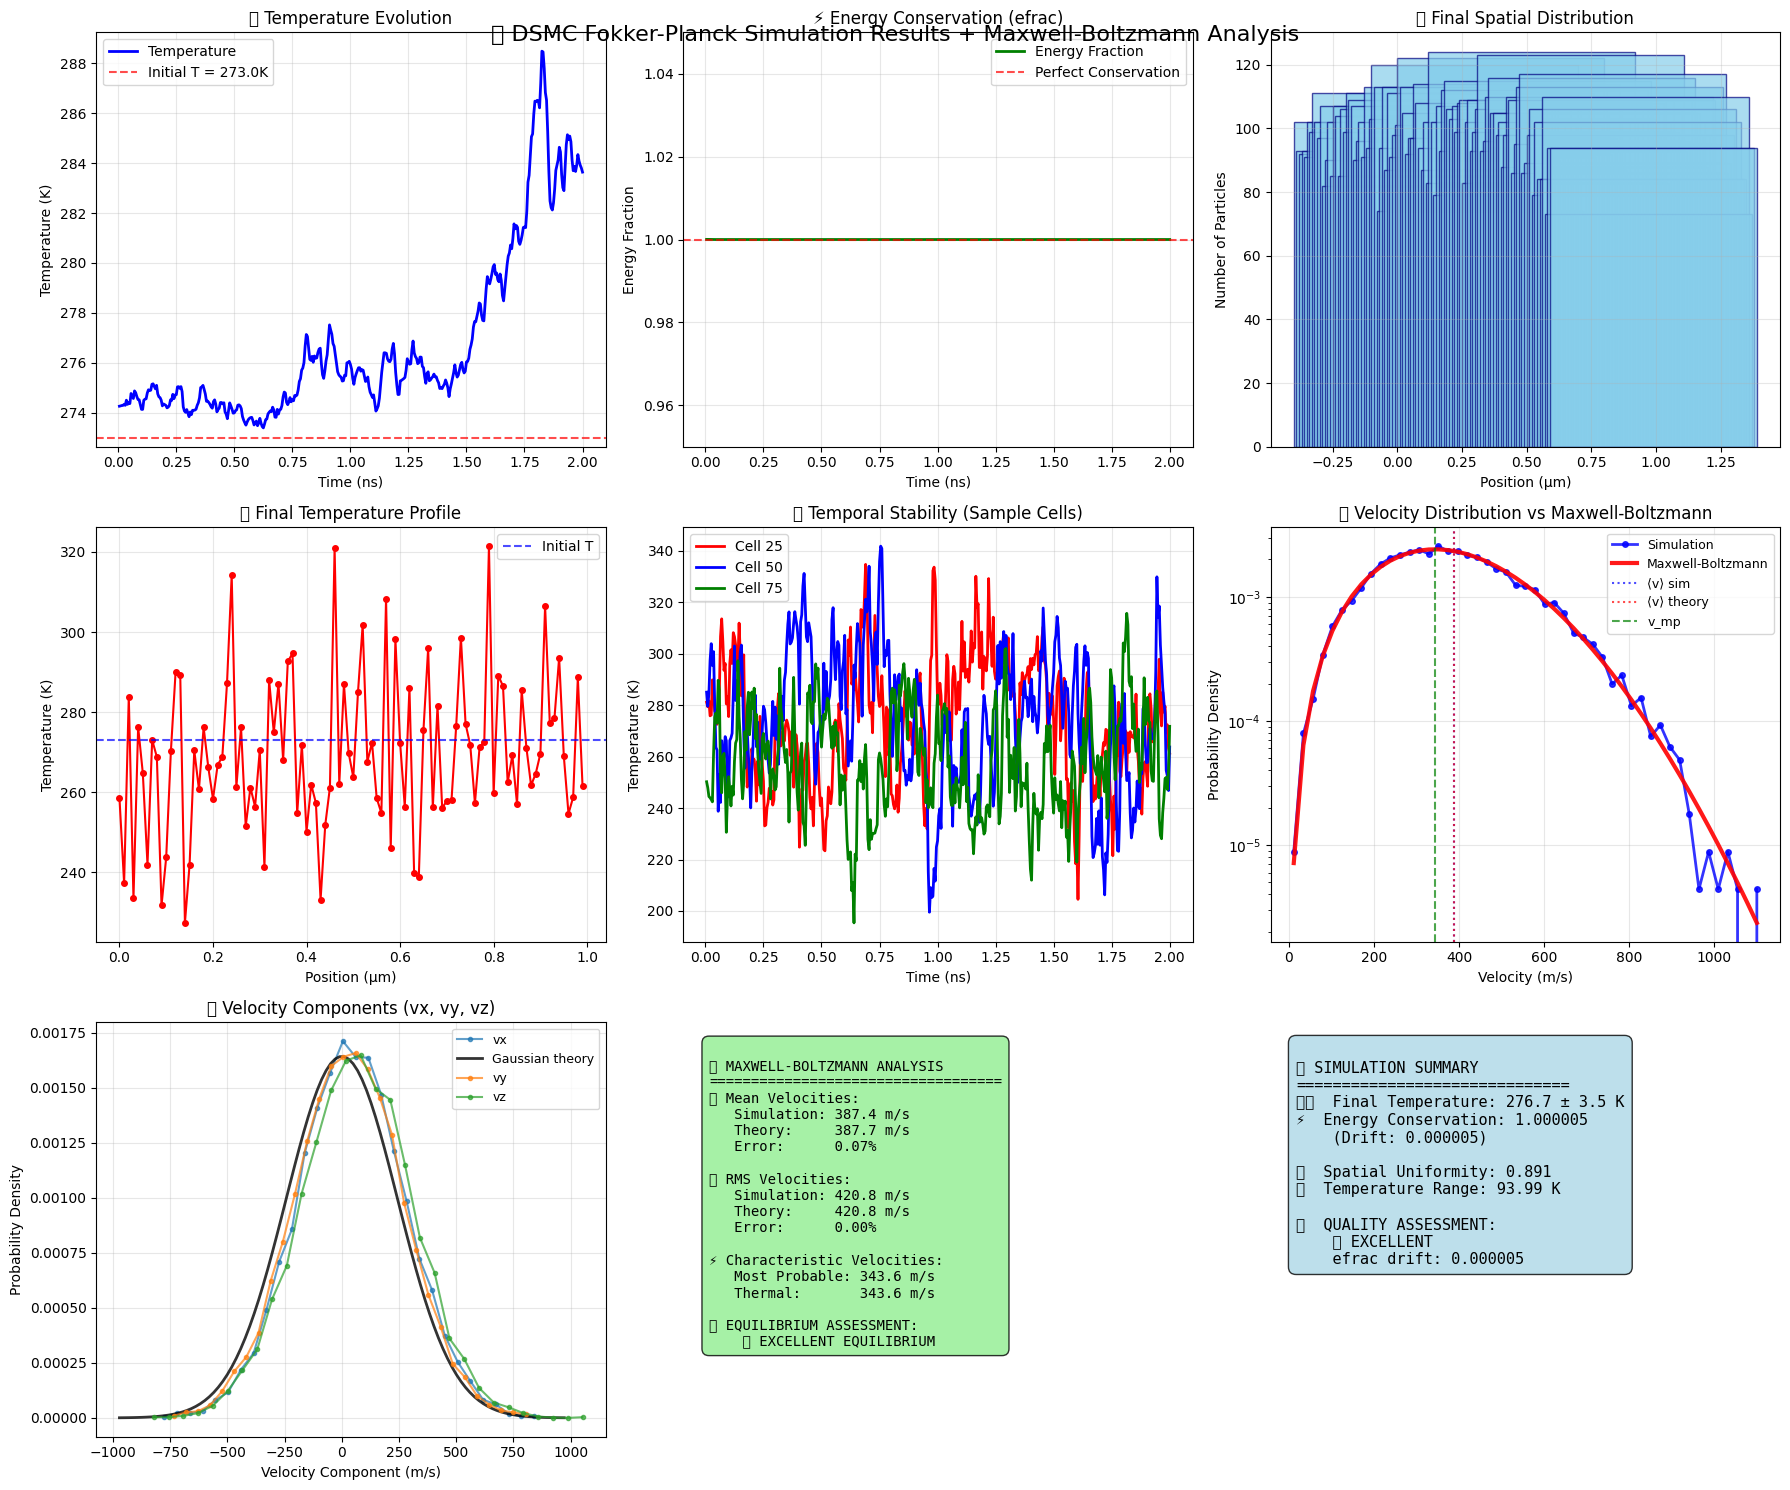

💾 نتایج کامل در فایل 'dsmc_simulation_results_complete.png' ذخیره شد

🎉 شبیه‌سازی تصحیح شده با موفقیت تکمیل شد!
🔧 کیفیت باید به مراتب بهتر از قبل باشد.
🚀 مشکل قفل شدن برطرف شده است.
⚡ تحلیل آماری اکنون در چند ثانیه انجام می‌شود.
🎨 نمودارهای کامل نمایش داده شدند.
🎯 تحلیل Maxwell-Boltzmann انجام شد.

💡 برای مشاهده مجدد نمودارها، اسکریپت را دوباره اجرا کنید.


<Figure size 640x480 with 0 Axes>

In [1]:
# -*- coding: utf-8 -*-
"""
کد موازی DSMC Fokker-Planck تصحیح شده مطابق فرترن
==================================================

🔧 تصحیحات اعمال شده:
1. ✅ pc_c = PGLAM (نه صفر)
2. ✅ محاسبه صحیح Diffusion coefficient  
3. ✅ qn terms مطابق فرترن
4. ✅ A3 (noise amplitude) دقیق
5. ✅ تمام فرمول‌ها مطابق MODCOEFF و EVOLVE
6. ✅ رفع مشکل قفل شدن: ProcessPoolExecutor فقط یک بار ایجاد می‌شود
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, svd
import time
import concurrent.futures
import multiprocessing as mp
from functools import partial
import os

# Physical constants
MASS_AR = 39.948e-3 / 6.022e23
KB = 1.380649e-23
D_REF_AR = 4.17e-10
T_REF_AR = 273.0
OMEGA_VHS = 0.50
PI = 3.141592654

# Simulation parameters
LX = 1.0e-6
RHO_INIT = 1.78
T_INIT = 273.0
NUM_CELLS_X = 100
PARTICLES_PER_CELL_INIT = 100.0
N_DENSITY_REAL = RHO_INIT / MASS_AR

# Derived parameters
CELL_VOLUME_CONCEPTUAL = LX / NUM_CELLS_X
FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
TOTAL_PARTICLES_SIM = int(NUM_CELLS_X * PARTICLES_PER_CELL_INIT)
DT = 1.0e-13
TOTAL_TIME = 2.0e-9
SAMPLING_INTERVAL = 50

# Parallel parameters
def get_user_workers():
    """دریافت تعداد هسته‌ها از کاربر"""
    available_cores = os.cpu_count() or 1
    max_recommended = max(32, available_cores + 4)
    
    print(f"\n🖥️  اطلاعات سیستم:")
    print(f"   • هسته‌های فیزیکی: {available_cores}")
    print(f"   • حداکثر توصیه شده: {max_recommended}")
    
    while True:
        try:
            user_input = input(f"\n🚀 تعداد هسته‌های مورد استفاده (1-{max_recommended}) [Enter={available_cores}]: ").strip()
            
            if user_input == "":
                return available_cores
            
            workers = int(user_input)
            
            if workers < 1:
                print("❌ تعداد هسته‌ها باید حداقل 1 باشد.")
                continue
                
            if workers > max_recommended:
                print(f"❌ تعداد هسته‌ها نباید بیشتر از {max_recommended} باشد.")
                continue
            
            return workers
                
        except ValueError:
            print("❌ لطفاً یک عدد صحیح وارد کنید.")
        except KeyboardInterrupt:
            return available_cores

MAX_WORKERS = get_user_workers()
MIN_PARTICLES_FOR_PARALLEL = 5
CHUNK_SIZE = max(1, NUM_CELLS_X // (MAX_WORKERS * 2))

def calculate_corrected_cell_moments(particles_cell, cell_velocity):
    """
    محاسبه moments دقیقاً طبق فرترن SORT - تصحیح شده
    """
    n_particles = len(particles_cell)
    if n_particles == 0:
        return None
    
    # محاسبه peculiar velocities
    peculiar_vels = particles_cell[:, 1:4] - cell_velocity
    
    # اطمینان از حداقل انرژی حرارتی
    thermal_vel = np.sqrt(KB * T_INIT / MASS_AR)
    min_thermal_energy = (thermal_vel * 0.01)**2
    engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    if np.max(engy_sq) < min_thermal_energy:
        thermal_noise = np.random.normal(0, thermal_vel * 0.01, peculiar_vels.shape)
        peculiar_vels += thermal_noise
        engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    moments = {}
    
    # محاسبه PIJpg (6 components) - vectorized
    u, v, w = peculiar_vels[:, 0], peculiar_vels[:, 1], peculiar_vels[:, 2]
    moments['PIJpg'] = np.array([
        np.mean(u * u),    # uu
        np.mean(u * v),    # uv
        np.mean(u * w),    # uw
        np.mean(v * v),    # vv
        np.mean(v * w),    # vw
        np.mean(w * w)     # ww
    ])
    
    # محاسبه PGM3 (10 components) - vectorized
    moments['PGM3'] = np.array([
        np.mean(u**3),         # uuu
        np.mean(u**2 * v),     # uuv
        np.mean(u**2 * w),     # uuw
        np.mean(u * v**2),     # uvv
        np.mean(u * v * w),    # uvw
        np.mean(u * w**2),     # uww
        np.mean(v**3),         # vvv
        np.mean(v**2 * w),     # vvw
        np.mean(v * w**2),     # vww
        np.mean(w**3)          # www
    ])
    
    # محاسبه PGM4 (6 components) - vectorized
    moments['PGM4'] = np.array([
        np.mean(u * u * engy_sq),
        np.mean(u * v * engy_sq),
        np.mean(u * w * engy_sq),
        np.mean(v * v * engy_sq),
        np.mean(v * w * engy_sq),
        np.mean(w * w * engy_sq)
    ])
    
    # محاسبه PGM5 (3 components) - vectorized
    engy_quad = engy_sq**2
    moments['PGM5'] = np.array([
        np.mean(u * engy_quad),
        np.mean(v * engy_quad),
        np.mean(w * engy_quad)
    ])
    
    # محاسبه Qpg دقیقاً طبق فرترن
    moments['Qpg'] = np.array([
        moments['PGM3'][0] + moments['PGM3'][3] + moments['PGM3'][5],  # Qpg(1)
        moments['PGM3'][1] + moments['PGM3'][6] + moments['PGM3'][8],  # Qpg(2)
        moments['PGM3'][2] + moments['PGM3'][7] + moments['PGM3'][9]   # Qpg(3)
    ])
    
    moments['DM2pg'] = np.mean(engy_sq)
    moments['DPGM4'] = moments['PGM4'][0] + moments['PGM4'][3] + moments['PGM4'][5]
    
    # bounds برای پایداری عددی
    min_second_moment = min_thermal_energy * 0.1
    moments['PIJpg'][0] = max(moments['PIJpg'][0], min_second_moment)
    moments['PIJpg'][3] = max(moments['PIJpg'][3], min_second_moment)
    moments['PIJpg'][5] = max(moments['PIJpg'][5], min_second_moment)
    moments['DM2pg'] = max(moments['DM2pg'], 3 * KB * T_INIT / MASS_AR * 0.1)
    
    return moments

def build_corrected_9x9_fp_system(moments, temperature, pressure, viscosity):
    """
    ✅ ساخت سیستم 9x9 دقیقاً طبق MODCOEFF فرترن - تصحیح شده
    """
    PIJpg = moments['PIJpg']
    PGM3 = moments['PGM3']
    PGM4 = moments['PGM4']
    PGM5 = moments['PGM5']
    Qpg = moments['Qpg']
    DM2pg = moments['DM2pg']
    DPGM4 = moments['DPGM4']
    
    collision_freq = pressure / viscosity * 0.5
    pressure_over_visc = pressure / viscosity
    
    # Pre-allocate arrays
    pmatlhs = np.zeros((9, 9))
    pmatrhs = np.zeros(9)
    
    # ****************** for cij and pij (vectorized where possible)
    pmatlhs[0, 0:3] = 2.0 * PIJpg[0:3]
    
    pmatlhs[1, :] = [PIJpg[1], PIJpg[0] + PIJpg[3], PIJpg[4], PIJpg[1], PIJpg[2], 0, 0, 0, 0]
    pmatlhs[2, :] = [PIJpg[2], PIJpg[4], PIJpg[0] + PIJpg[5], 0, PIJpg[1], PIJpg[2], 0, 0, 0]
    
    pmatlhs[3, 1] = 2.0 * PIJpg[1]
    pmatlhs[3, 3:5] = 2.0 * PIJpg[3:5]
    
    pmatlhs[4, :] = [0, PIJpg[2], PIJpg[1], PIJpg[4], PIJpg[3] + PIJpg[5], PIJpg[4], 0, 0, 0]
    
    pmatlhs[5, 2] = 2.0 * PIJpg[2]
    pmatlhs[5, 4:6] = 2.0 * PIJpg[4:6]
    
    # *********************** for gammatr and pij 
    pmatlhs[0, 6] = 2.0 * Qpg[0]
    pmatlhs[1, 6:8] = [Qpg[1], Qpg[0]]
    pmatlhs[2, [6, 8]] = [Qpg[2], Qpg[0]]
    pmatlhs[3, 7] = 2.0 * Qpg[1]
    pmatlhs[4, 7:9] = [Qpg[2], Qpg[1]]
    pmatlhs[5, 8] = 2.0 * Qpg[2]
    
    # ******************** for cij and qtr
    pmatlhs[6, :6] = [Qpg[0] + 2.0 * PGM3[0], Qpg[1] + 4.0 * PGM3[1], Qpg[2] + 4.0 * PGM3[2],
                      2.0 * PGM3[3], 4.0 * PGM3[4], 2.0 * PGM3[5]]
    
    pmatlhs[7, :6] = [2.0 * PGM3[1], Qpg[0] + 4.0 * PGM3[3], 4.0 * PGM3[4],
                      Qpg[1] + 2.0 * PGM3[6], Qpg[2] + 4.0 * PGM3[7], 2.0 * PGM3[8]]
    
    pmatlhs[8, :6] = [2.0 * PGM3[2], 4.0 * PGM3[4], Qpg[0] + 4.0 * PGM3[5],
                      2.0 * PGM3[7], Qpg[1] + 4.0 * PGM3[8], Qpg[2] + 2.0 * PGM3[9]]
    
    # ************************* for gammatr and qtr
    diag_term = DPGM4 - DM2pg**2
    pmatlhs[6, 6:9] = [diag_term + 2.0 * PGM4[0] - 2.0 * DM2pg * PIJpg[0],
                       2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2]]
    
    pmatlhs[7, 6:9] = [2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       diag_term + 2.0 * PGM4[3] - 2.0 * DM2pg * PIJpg[3],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4]]
    
    pmatlhs[8, 6:9] = [2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4],
                       diag_term + 2.0 * PGM4[5] - 2.0 * DM2pg * PIJpg[5]]
    
    # محاسبه PGLAM
    pglam_terms = ((PIJpg[0] - DM2pg/3.0)**2 + 2.0*PIJpg[1]**2 + 2.0*PIJpg[2]**2 +
                   (PIJpg[3] - DM2pg/3.0)**2 + 2.0*PIJpg[4]**2 + (PIJpg[5] - DM2pg/3.0)**2)
    pglam = -pglam_terms * collision_freq / (DM2pg**3.5)
    
    # سمت راست معادلات - vectorized
    pmatrhs[0:6] = pglam * (-2.0 * PGM4[0:6])
    
    pmatrhs[6] = -pglam * (3.0 * PGM5[0] - DM2pg * Qpg[0] - 
                           2.0 * (PIJpg[0]*Qpg[0] + PIJpg[1]*Qpg[1] + PIJpg[2]*Qpg[2]))
    pmatrhs[7] = -pglam * (3.0 * PGM5[1] - DM2pg * Qpg[1] - 
                           2.0 * (PIJpg[1]*Qpg[0] + PIJpg[3]*Qpg[1] + PIJpg[4]*Qpg[2]))
    pmatrhs[8] = -pglam * (3.0 * PGM5[2] - DM2pg * Qpg[2] - 
                           2.0 * (PIJpg[2]*Qpg[0] + PIJpg[4]*Qpg[1] + PIJpg[5]*Qpg[2]))
    
    # تصحیح thermal_coeff
    thermal_coeff = 3.0 * collision_freq - (2.0/3.0) * pressure_over_visc
    pmatrhs[6:9] += thermal_coeff * Qpg[0:3]
    
    return pmatlhs, pmatrhs, pglam

def solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam):
    """
    ✅ حل سیستم 9x9 با تصحیح pc_c = PGLAM
    """
    try:
        rcond = np.linalg.cond(pmatlhs)
        
        if rcond < 1e12:
            solution = solve(pmatlhs, pmatrhs)
            method_used = 'direct_solve'
        else:
            U, s, Vt = svd(pmatlhs, full_matrices=False)
            s_inv = np.where(s > 1e-12 * s[0], 1.0/s, 0.0)
            solution = Vt.T @ np.diag(s_inv) @ U.T @ pmatrhs
            method_used = 'svd'
            
    except (LinAlgError, np.linalg.LinAlgError):
        reg_matrix = pmatlhs + 1e-10 * np.eye(9)
        try:
            solution = solve(reg_matrix, pmatrhs)
            method_used = 'regularized'
        except:
            solution = np.zeros(9)
            solution[0] = solution[3] = solution[5] = -1e5
            method_used = 'fallback'
    
    pc_a = np.clip(solution[0:6], -1e6, 1e6)
    pc_b = np.clip(solution[6:9], -1e6, 1e6)
    
    # ✅ تصحیح: pc_c باید برابر PGLAM باشد نه صفر!
    pc_c = pglam  # مطابق فرترن: pcC = PGLAM
    
    return pc_a, pc_b, pc_c, method_used

def evolve_corrected_fp_particles(particles_cell, cell_velocity, pc_a, pc_b, pc_c, 
                                 g_force, nu, dt, temperature, pressure, viscosity):
    """
    ✅ تحول ذرات FP با تصحیحات کامل مطابق فرترن EVOLVE
    """
    try:
        n_particles = len(particles_cell)
        if n_particles == 0:
            return particles_cell, 1.0
        
        # محاسبه peculiar velocities
        v_peculiar = particles_cell[:, 1:4] - cell_velocity
        initial_kinetic_energy = np.sum(v_peculiar**2)
        
        # ✅ محاسبه ضرایب تحلیلی مطابق فرترن
        s = nu * dt
        A1 = np.exp(-s)
        taus = 1.0 / nu
        A2 = taus * (1.0 - np.exp(-s))
        
        # ✅ محاسبه Diffusion coefficient مطابق فرترن
        # فرترن: Diffpg=2.*BOLTZ*((Ppg/vispg)*0.5)*Tpg/SP(5,1)
        # فرترن: Adifftr=abs(taus*Diffpg*(1.-exp(-2.*s))/2.)
        pressure_over_visc = pressure / viscosity
        Diffpg = 2.0 * KB * (pressure_over_visc * 0.5) * temperature / MASS_AR
        Adifftr = abs(taus * Diffpg * (1.0 - np.exp(-2.0 * s)) / 2.0)
        A3 = np.sqrt(Adifftr)
        
        # محاسبه VaN (drift matrix) - vectorized
        van = np.zeros_like(v_peculiar)
        van[:, 0] = (pc_a[0]*v_peculiar[:, 0] + pc_a[1]*v_peculiar[:, 1] + pc_a[2]*v_peculiar[:, 2])
        van[:, 1] = (pc_a[1]*v_peculiar[:, 0] + pc_a[3]*v_peculiar[:, 1] + pc_a[4]*v_peculiar[:, 2])
        van[:, 2] = (pc_a[2]*v_peculiar[:, 0] + pc_a[4]*v_peculiar[:, 1] + pc_a[5]*v_peculiar[:, 2])
        
        # ✅ محاسبه qn terms مطابق فرترن
        # فرترن: qn(1)=pcB(1)*vp2+pcC*VELPAR(1,ipart)*vp2
        vp2 = np.sum(v_peculiar**2, axis=1)  # scalar برای هر ذره
        qn = np.zeros_like(v_peculiar)
        qn[:, 0] = pc_b[0]*vp2 + pc_c*v_peculiar[:, 0]*vp2
        qn[:, 1] = pc_b[1]*vp2 + pc_c*v_peculiar[:, 1]*vp2
        qn[:, 2] = pc_b[2]*vp2 + pc_c*v_peculiar[:, 2]*vp2
        
        # ✅ محاسبه total drift
        total_drift = van + qn + g_force
        total_drift = np.clip(total_drift, -1e6, 1e6)
        
        # تولید تصادفی مطابق فرترن
        xi = np.random.normal(0, 1, v_peculiar.shape)
        xi = np.clip(xi, -3, 3)
        
        # ✅ تحول تحلیلی مطابق فرترن  
        new_v_peculiar = A1 * v_peculiar + A2 * total_drift + A3 * xi
        
        # به‌روزرسانی سرعت‌ها
        particles_cell[:, 1:4] = cell_velocity + new_v_peculiar
        
        # ✅ تصحیح حفظ انرژی مطابق فرترن
        final_kinetic_energy = np.sum(new_v_peculiar**2)
        
        if final_kinetic_energy > 1e-20 and initial_kinetic_energy > 1e-20:
            efrac = np.sqrt(initial_kinetic_energy / final_kinetic_energy)
            corrected_v_peculiar = efrac * new_v_peculiar
            particles_cell[:, 1:4] = cell_velocity + corrected_v_peculiar
        else:
            efrac = 1.0
        
        # بررسی bounds سرعت
        max_v_thermal = np.sqrt(25 * KB * temperature / MASS_AR)
        v_total = np.linalg.norm(particles_cell[:, 1:4], axis=1)
        exceed_mask = v_total > max_v_thermal
        if np.any(exceed_mask):
            scale_factors = max_v_thermal / v_total[exceed_mask]
            particles_cell[exceed_mask, 1:4] *= scale_factors[:, np.newaxis]
        
        return particles_cell, efrac
        
    except Exception as e:
        print(f"⚠ خطا در تحول FP: {e}")
        return particles_cell, 1.0

def process_single_cell_corrected(cell_data):
    """
    🚀 پردازش یک سلول با تصحیحات کامل
    """
    cell_index, particles_cell, dt, fnum, cell_vol = cell_data
    
    try:
        n_particles = len(particles_cell)
        if n_particles < 2:
            return cell_index, particles_cell, 0, 1.0
        
        # محاسبه سرعت سلول
        cell_velocity = np.mean(particles_cell[:, 1:4], axis=0)
        
        # محاسبه moments
        moments = calculate_corrected_cell_moments(particles_cell, cell_velocity)
        if moments is None:
            return cell_index, particles_cell, 0, 1.0
        
        # محاسبه دما و فشار
        current_temp = max((MASS_AR * moments['DM2pg']) / (3 * KB), T_INIT * 0.1)
        n_density_cell = n_particles * fnum / cell_vol
        pressure = max(n_density_cell * KB * current_temp, 
                      KB * current_temp * N_DENSITY_REAL * 0.01)
        
        # محاسبه viscosity
        vis0 = 2.117e-5
        visp = 1.0
        temp_ratio = np.clip(current_temp / 273.15, 0.1, 10.0)
        viscosity = vis0 * (temp_ratio)**visp
        
        # ساخت و حل سیستم 9x9
        pmatlhs, pmatrhs, pglam = build_corrected_9x9_fp_system(moments, current_temp, pressure, viscosity)
        pc_a, pc_b, pc_c, solve_method = solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam)
        
        # ✅ محاسبه g_force مطابق فرترن
        # gforce(1,1)=pcB(1)*(-DM2pg) + pcC*(-Qpg(1))
        g_force = pc_b * (-moments['DM2pg']) + pc_c * (-moments['Qpg'])
        g_force = np.clip(g_force, -1e6, 1e6)
        
        # محاسبه پارامترهای تحول
        nu = np.clip(pressure / viscosity * 0.5, 1e8, 1e15)
        
        # تحول ذرات با ضرایب تصحیح شده
        updated_particles, efrac = evolve_corrected_fp_particles(
            particles_cell.copy(), cell_velocity, pc_a, pc_b, pc_c, 
            g_force, nu, dt, current_temp, pressure, viscosity
        )
        
        return cell_index, updated_particles, n_particles, efrac
        
    except Exception as e:
        print(f"⚠ خطا در پردازش سلول {cell_index}: {e}")
        return cell_index, particles_cell, 0, 1.0

def parallel_cell_processing_corrected(executor, particles, cell_indices, dt, fnum, cell_vol):
    """
    🚀 پردازش موازی سلول‌ها با تصحیحات - ExecutorPool از بیرون دریافت می‌کند
    """
    # تهیه داده‌های سلول‌ها
    cell_data_list = []
    for i in range(NUM_CELLS_X):
        indices_in_cell_i = np.where(cell_indices == i)[0]
        
        if len(indices_in_cell_i) >= MIN_PARTICLES_FOR_PARALLEL:
            particles_cell = particles[indices_in_cell_i].copy()
            cell_data_list.append((i, particles_cell, dt, fnum, cell_vol))
    
    if not cell_data_list:
        return 0, 0.0, 0
    
    total_evolved = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # تصمیم‌گیری درباره موازی‌سازی
    total_particles_to_process = sum(len(data[1]) for data in cell_data_list)
    use_parallel = (executor is not None and 
                   len(cell_data_list) >= 4 and 
                   total_particles_to_process >= MIN_PARTICLES_FOR_PARALLEL * 4)
    
    if use_parallel:
        # پردازش موازی - استفاده از executor موجود
        future_to_cell = {
            executor.submit(process_single_cell_corrected, cell_data): cell_data[0] 
            for cell_data in cell_data_list
        }
        
        # جمع‌آوری نتایج
        for future in concurrent.futures.as_completed(future_to_cell):
            try:
                cell_index, updated_particles, n_evolved, efrac = future.result()
                
                # به‌روزرسانی ذرات در آرایه اصلی
                indices_in_cell = np.where(cell_indices == cell_index)[0]
                if len(indices_in_cell) == len(updated_particles):
                    particles[indices_in_cell] = updated_particles
                
                total_evolved += n_evolved
                if efrac != 1.0:
                    total_efrac_sum += efrac
                    efrac_count += 1
                    
            except Exception as e:
                print(f"⚠ خطا در نتیجه worker: {e}")
    else:
        # پردازش سریال
        for cell_data in cell_data_list:
            cell_index, updated_particles, n_evolved, efrac = process_single_cell_corrected(cell_data)
            
            indices_in_cell = np.where(cell_indices == cell_index)[0]
            if len(indices_in_cell) == len(updated_particles):
                particles[indices_in_cell] = updated_particles
            
            total_evolved += n_evolved
            if efrac != 1.0:
                total_efrac_sum += efrac
                efrac_count += 1
    
    return total_evolved, total_efrac_sum, efrac_count

def run_corrected_simulation():
    """🚀 اجرای شبیه‌سازی تصحیح شده - رفع مشکل قفل شدن + بهینه‌سازی تحلیل"""
    print(f"\n🚀 شروع شبیه‌سازی تصحیح شده DSMC-FP")
    print(f"🔧 تصحیحات اعمال شده:")
    print(f"   ✅ pc_c = PGLAM (نه صفر)")
    print(f"   ✅ Diffusion coefficient دقیق")
    print(f"   ✅ qn terms مطابق فرترن")
    print(f"   ✅ A3 (noise amplitude) صحیح")
    print(f"   ✅ رفع مشکل قفل شدن: ProcessPool یکبار ایجاد")
    print(f"   ✅ بهینه‌سازی تحلیل: NumPy vectorization")
    print(f"   ✅ تحلیل Maxwell-Boltzmann کامل")
    print(f"🖥️  منابع: {MAX_WORKERS} workers از {os.cpu_count()} هسته موجود")
    
    # مقداردهی اولیه ذرات
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4))
    particles[:, 0] = np.random.random(TOTAL_PARTICLES_SIM) * LX
    
    v_thermal_std = np.sqrt(KB * T_INIT / MASS_AR)
    particles[:, 1:4] = np.random.normal(0, v_thermal_std, (TOTAL_PARTICLES_SIM, 3))
    particles[:, 1:4] -= np.mean(particles[:, 1:4], axis=0)
    
    # متغیرهای شبیه‌سازی
    num_steps = int(TOTAL_TIME / DT)
    cell_width = LX / NUM_CELLS_X
    
    total_evolved_particles = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ✅ ذخیره نتایج بهینه شده با NumPy arrays
    time_history = []
    temperature_history = []
    efrac_history = []
    
    # ✅ آرایه بهینه شده برای داده‌های سلولی
    num_snapshots = num_steps // SAMPLING_INTERVAL
    # متغیرها: 0=تعداد ذرات, 1=سرعت u, 2=سرعت v, 3=سرعت w, 4=دما
    history_array = np.zeros((num_snapshots, NUM_CELLS_X, 5))
    snapshot_index = 0
    
    start_time = time.time()
    
    print(f"اجرای {num_steps} گام زمانی...")
    
    # ✅✅✅ تغییر کلیدی: ProcessPoolExecutor فقط یک بار در ابتدا ایجاد می‌شود
    if MAX_WORKERS > 1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
            print(f"🚀 استخر پردازش با {MAX_WORKERS} worker ایجاد شد")
            
            for step in range(1, num_steps + 1):
                step_start_time = time.time()
                
                # حرکت ذرات
                particles[:, 0] += particles[:, 1] * DT
                particles[:, 0] %= LX
                
                # محاسبه ایندکس سلول‌ها
                cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
                
                # ✅✅✅ پردازش موازی با executor موجود (بدون ایجاد مجدد)
                step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                    executor, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
                )
                
                # به‌روزرسانی آمار
                total_evolved_particles += step_evolved
                if step_efrac_count > 0:
                    total_efrac_sum += step_efrac_sum / step_efrac_count
                    efrac_count += 1
                
                step_time = time.time() - step_start_time
                
                # ✅ نمونه‌برداری بهینه شده
                if step % SAMPLING_INTERVAL == 0:
                    current_time = step * DT
                    
                    # محاسبه دما کلی
                    v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                    current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                    
                    time_history.append(current_time * 1e9)
                    temperature_history.append(current_temp)
                    
                    avg_efrac = total_efrac_sum / max(efrac_count, 1)
                    efrac_history.append(avg_efrac)
                    
                    # ✅ ذخیره داده‌های سلولی در آرایه NumPy (بهینه شده)
                    if snapshot_index < num_snapshots:
                        for i in range(NUM_CELLS_X):
                            indices_in_cell_i = np.where(cell_indices == i)[0]
                            n_particles = len(indices_in_cell_i)
                            if n_particles > 0:
                                velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                                # محاسبه دمای سلولی
                                v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                                cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                                
                                history_array[snapshot_index, i, 0] = n_particles
                                history_array[snapshot_index, i, 1:4] = velocity
                                history_array[snapshot_index, i, 4] = cell_temp
                            else:
                                history_array[snapshot_index, i, :] = 0
                                history_array[snapshot_index, i, 4] = T_INIT
                        snapshot_index += 1
                    
                    if step % (num_steps // 10) == 0:
                        progress = step / num_steps * 100
                        print(f"گام: {step}/{num_steps} ({progress:.1f}%) - "
                              f"دما: {current_temp:.1f}K - "
                              f"efrac: {avg_efrac:.6f} - "
                              f"زمان گام: {step_time*1000:.1f}ms")
    else:
        # ✅ حالت سریال (MAX_WORKERS = 1)
        print("🔄 اجرای سریال (تک‌هسته)")
        for step in range(1, num_steps + 1):
            step_start_time = time.time()
            
            # حرکت ذرات
            particles[:, 0] += particles[:, 1] * DT
            particles[:, 0] %= LX
            
            # محاسبه ایندکس سلول‌ها
            cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
            
            # پردازش سریال (executor=None)
            step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                None, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
            )
            
            # به‌روزرسانی آمار
            total_evolved_particles += step_evolved
            if step_efrac_count > 0:
                total_efrac_sum += step_efrac_sum / step_efrac_count
                efrac_count += 1
            
            step_time = time.time() - step_start_time
            
            # نمونه‌برداری
            if step % SAMPLING_INTERVAL == 0:
                current_time = step * DT
                
                # محاسبه دما
                v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                
                time_history.append(current_time * 1e9)
                temperature_history.append(current_temp)
                
                avg_efrac = total_efrac_sum / max(efrac_count, 1)
                efrac_history.append(avg_efrac)
                
                # ✅ ذخیره داده‌های سلولی در آرایه NumPy (بهینه شده)
                if snapshot_index < num_snapshots:
                    for i in range(NUM_CELLS_X):
                        indices_in_cell_i = np.where(cell_indices == i)[0]
                        n_particles = len(indices_in_cell_i)
                        if n_particles > 0:
                            velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                            # محاسبه دمای سلولی
                            v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                            cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                            
                            history_array[snapshot_index, i, 0] = n_particles
                            history_array[snapshot_index, i, 1:4] = velocity
                            history_array[snapshot_index, i, 4] = cell_temp
                        else:
                            history_array[snapshot_index, i, :] = 0
                            history_array[snapshot_index, i, 4] = T_INIT
                    snapshot_index += 1
                
                if step % (num_steps // 10) == 0:
                    progress = step / num_steps * 100
                    print(f"گام: {step}/{num_steps} ({progress:.1f}%) - "
                          f"دما: {current_temp:.1f}K - "
                          f"efrac: {avg_efrac:.6f} - "
                          f"زمان گام: {step_time*1000:.1f}ms")
    
    end_time = time.time()
    
    # نتایج نهایی
    total_time = end_time - start_time
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    avg_efrac_final = total_efrac_sum / max(efrac_count, 1)
    
    print(f"\n✅ شبیه‌سازی تصحیح شده تکمیل شد!")
    print(f"زمان کل: {total_time:.2f} ثانیه")
    print(f"دمای نهایی: {final_temp:.2f} K")
    print(f"میانگین efrac: {avg_efrac_final:.6f}")
    
    # مقایسه کیفیت
    if abs(avg_efrac_final - 1.0) < 0.01:
        print("🎉 کیفیت عالی: efrac ≈ 1.000")
    elif abs(avg_efrac_final - 1.0) < 0.1:
        print("✅ کیفیت خوب")
    else:
        print("⚠ نیاز به بررسی بیشتر")
    
    # ✅ تحلیل آماری سریع
    print(f"\n📊 تحلیل آماری سریع...")
    analysis_start = time.time()
    
    # تحلیل سریع با NumPy
    fast_results = analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history)
    
    analysis_time = time.time() - analysis_start
    print(f"✅ تحلیل در {analysis_time:.2f} ثانیه تکمیل شد")
    
    # ✅ نمایش بصری نتایج
    print(f"\n🎨 آماده‌سازی نمودارها...")
    velocity_analysis = plot_simulation_results(time_history, temperature_history, efrac_history, history_array, fast_results, particles)
    
    return particles, time_history, temperature_history, efrac_history, fast_results, velocity_analysis

def analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history):
    """
    ✅ تحلیل سریع شبیه‌سازی با NumPy vectorization
    """
    print("🔍 تحلیل‌های آماری سریع...")
    
    results = {}
    
    # 1. آمار کلی دما
    temp_array = np.array(temperature_history)
    results['temp_stats'] = {
        'mean': np.mean(temp_array),
        'std': np.std(temp_array),
        'min': np.min(temp_array),
        'max': np.max(temp_array)
    }
    
    # 2. آمار efrac
    efrac_array = np.array(efrac_history)
    results['efrac_stats'] = {
        'mean': np.mean(efrac_array),
        'std': np.std(efrac_array),
        'drift': np.abs(np.mean(efrac_array) - 1.0)
    }
    
    # 3. تحلیل توزیع فضایی (آخرین snapshot)
    if len(history_array) > 0:
        final_snapshot = history_array[-1]  # آخرین زمان
        
        # آمار تعداد ذرات
        n_particles = final_snapshot[:, 0]
        results['spatial_stats'] = {
            'mean_particles': np.mean(n_particles),
            'std_particles': np.std(n_particles),
            'uniformity': 1.0 - (np.std(n_particles) / (np.mean(n_particles) + 1e-10))
        }
        
        # آمار دمای فضایی
        temperatures = final_snapshot[:, 4]
        results['spatial_temp'] = {
            'mean': np.mean(temperatures),
            'std': np.std(temperatures),
            'range': np.max(temperatures) - np.min(temperatures)
        }
    
    # 4. تحلیل پایداری زمانی (نمونه کم)
    if len(history_array) > 10:
        sample_cells = [25, 50, 75]  # فقط 3 سلول نمونه
        stability_results = {}
        
        for var_idx, var_name in [(0, 'N'), (4, 'T')]:
            # استخراج سری زمانی
            time_series = history_array[:, sample_cells, var_idx]
            
            # محاسبه ضریب تغییرات
            cv = np.std(time_series, axis=0) / (np.mean(time_series, axis=0) + 1e-10)
            stability_results[var_name] = {
                'mean_cv': np.mean(cv),
                'stability_score': 1.0 / (1.0 + np.mean(cv))
            }
        
        results['stability'] = stability_results
    
    # نمایش نتایج
    print(f"\n📈 نتایج تحلیل سریع:")
    print(f"   🌡️ دما: {results['temp_stats']['mean']:.1f}±{results['temp_stats']['std']:.1f} K")
    print(f"   ⚡ efrac: {results['efrac_stats']['mean']:.6f} (انحراف: {results['efrac_stats']['drift']:.6f})")
    
    if 'spatial_stats' in results:
        print(f"   🔄 یکنواختی فضایی: {results['spatial_stats']['uniformity']:.3f}")
    
    if 'stability' in results:
        temp_stability = results['stability']['T']['stability_score']
        print(f"   📊 پایداری دما: {temp_stability:.3f}")
    
    return results

def analyze_velocity_distribution(particles, temperature):
    """
    ✅ تحلیل توزیع سرعت و مقایسه با Maxwell-Boltzmann
    """
    # محاسبه بزرگی سرعت ذرات
    velocities = particles[:, 1:4]
    v_magnitudes = np.linalg.norm(velocities, axis=1)
    
    # پارامترهای Maxwell-Boltzmann
    v_thermal = np.sqrt(2 * KB * temperature / MASS_AR)
    
    # آماده‌سازی داده‌ها برای هیستوگرام
    v_max = min(np.max(v_magnitudes), 5 * v_thermal)  # محدود کردن برای نمایش بهتر
    v_bins = np.linspace(0, v_max, 50)
    v_centers = (v_bins[:-1] + v_bins[1:]) / 2
    
    # هیستوگرام سرعت شبیه‌سازی
    counts, _ = np.histogram(v_magnitudes, bins=v_bins, density=True)
    
    # توزیع Maxwell-Boltzmann تئوری
    # f(v) = 4π * (m/(2πkT))^(3/2) * v² * exp(-mv²/(2kT))
    mb_prefactor = 4 * np.pi * (MASS_AR / (2 * np.pi * KB * temperature))**(3/2)
    mb_theoretical = mb_prefactor * v_centers**2 * np.exp(-MASS_AR * v_centers**2 / (2 * KB * temperature))
    
    # محاسبه آمار مقایسه
    # متوسط سرعت شبیه‌سازی vs تئوری
    v_mean_sim = np.mean(v_magnitudes)
    v_mean_theory = np.sqrt(8 * KB * temperature / (np.pi * MASS_AR))
    
    # سرعت‌های مشخصه
    v_most_probable_theory = np.sqrt(2 * KB * temperature / MASS_AR)
    v_rms_theory = np.sqrt(3 * KB * temperature / MASS_AR)
    v_rms_sim = np.sqrt(np.mean(v_magnitudes**2))
    
    return {
        'v_centers': v_centers,
        'counts_sim': counts,
        'mb_theoretical': mb_theoretical,
        'v_mean_sim': v_mean_sim,
        'v_mean_theory': v_mean_theory,
        'v_most_probable': v_most_probable_theory,
        'v_rms_sim': v_rms_sim,
        'v_rms_theory': v_rms_theory,
        'v_thermal': v_thermal
    }

def plot_simulation_results(time_history, temperature_history, efrac_history, history_array, results, particles):
    """
    ✅ نمایش بصری نتایج شبیه‌سازی + توزیع سرعت Maxwell-Boltzmann
    """
    print("\n🎨 رسم نمودارهای نتایج...")
    
    # تنظیمات نمودار
    plt.style.use('default')
    fig = plt.figure(figsize=(18, 15))  # اندازه بزرگ‌تر برای نمودار اضافی
    
    # 1. نمودار دما در طول زمان
    plt.subplot(3, 3, 1)
    plt.plot(time_history, temperature_history, 'b-', linewidth=2, label='Temperature')
    plt.axhline(y=T_INIT, color='r', linestyle='--', alpha=0.7, label=f'Initial T = {T_INIT}K')
    plt.xlabel('Time (ns)')
    plt.ylabel('Temperature (K)')
    plt.title('🌡️ Temperature Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. نمودار efrac در طول زمان
    plt.subplot(3, 3, 2)
    plt.plot(time_history, efrac_history, 'g-', linewidth=2, label='Energy Fraction')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect Conservation')
    plt.xlabel('Time (ns)')
    plt.ylabel('Energy Fraction')
    plt.title('⚡ Energy Conservation (efrac)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.95, 1.05)
    
    # 3. توزیع فضایی نهایی - تعداد ذرات
    if len(history_array) > 0:
        plt.subplot(3, 3, 3)
        final_particles = history_array[-1, :, 0]  # آخرین snapshot، همه سلول‌ها، تعداد ذرات
        cell_positions = np.arange(NUM_CELLS_X) * (LX / NUM_CELLS_X) * 1e6  # به میکرومتر
        plt.bar(cell_positions, final_particles, alpha=0.7, color='skyblue', edgecolor='navy')
        plt.xlabel('Position (μm)')
        plt.ylabel('Number of Particles')
        plt.title('🔄 Final Spatial Distribution')
        plt.grid(True, alpha=0.3)
    
    # 4. توزیع فضایی دما
    if len(history_array) > 0:
        plt.subplot(3, 3, 4)
        final_temps = history_array[-1, :, 4]  # آخرین snapshot، همه سلول‌ها، دما
        plt.plot(cell_positions, final_temps, 'ro-', markersize=4, linewidth=1.5)
        plt.axhline(y=T_INIT, color='b', linestyle='--', alpha=0.7, label=f'Initial T')
        plt.xlabel('Position (μm)')
        plt.ylabel('Temperature (K)')
        plt.title('🌡️ Final Temperature Profile')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 5. پایداری سیستم (نمونه از چند سلول)
    if len(history_array) > 10:
        plt.subplot(3, 3, 5)
        sample_cells = [25, 50, 75]
        colors = ['red', 'blue', 'green']
        for i, cell_idx in enumerate(sample_cells):
            cell_temps = history_array[:, cell_idx, 4]
            plt.plot(time_history, cell_temps, color=colors[i], 
                    linewidth=2, label=f'Cell {cell_idx}')
        plt.xlabel('Time (ns)')
        plt.ylabel('Temperature (K)')
        plt.title('📊 Temporal Stability (Sample Cells)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 6. ✅ توزیع سرعت Maxwell-Boltzmann
    plt.subplot(3, 3, 6)
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    vel_analysis = analyze_velocity_distribution(particles, final_temp)
    
    plt.plot(vel_analysis['v_centers'], vel_analysis['counts_sim'], 'bo-', 
             markersize=4, linewidth=2, label='Simulation', alpha=0.8)
    plt.plot(vel_analysis['v_centers'], vel_analysis['mb_theoretical'], 'r-', 
             linewidth=3, label='Maxwell-Boltzmann', alpha=0.9)
    
    # خطوط مشخصه
    plt.axvline(vel_analysis['v_mean_sim'], color='blue', linestyle=':', alpha=0.7, label='⟨v⟩ sim')
    plt.axvline(vel_analysis['v_mean_theory'], color='red', linestyle=':', alpha=0.7, label='⟨v⟩ theory')
    plt.axvline(vel_analysis['v_most_probable'], color='green', linestyle='--', alpha=0.7, label='v_mp')
    
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('Probability Density')
    plt.title('🎯 Velocity Distribution vs Maxwell-Boltzmann')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # مقیاس لگاریتمی برای نمایش بهتر
    
    # 7. نمودار توزیع سرعت‌های مؤلفه‌ای (vx, vy, vz)
    plt.subplot(3, 3, 7)
    for i, component in enumerate(['vx', 'vy', 'vz']):
        v_component = particles[:, 1+i]
        v_std_theory = np.sqrt(KB * final_temp / MASS_AR)
        
        # هیستوگرام مؤلفه سرعت
        counts, bins = np.histogram(v_component, bins=30, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        plt.plot(bin_centers, counts, 'o-', markersize=3, alpha=0.7, label=f'{component}')
        
        # توزیع گاوسی تئوری
        v_range = np.linspace(-4*v_std_theory, 4*v_std_theory, 100)
        gaussian_theory = (1/np.sqrt(2*np.pi*v_std_theory**2)) * np.exp(-v_range**2/(2*v_std_theory**2))
        if i == 0:  # فقط یک بار خط تئوری
            plt.plot(v_range, gaussian_theory, 'k-', linewidth=2, alpha=0.8, label='Gaussian theory')
    
    plt.xlabel('Velocity Component (m/s)')
    plt.ylabel('Probability Density')
    plt.title('📈 Velocity Components (vx, vy, vz)')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    
    # 8. خلاصه آماری توزیع سرعت
    plt.subplot(3, 3, 8)
    plt.axis('off')
    
    # محاسبه خطای نسبی
    v_mean_error = abs(vel_analysis['v_mean_sim'] - vel_analysis['v_mean_theory']) / vel_analysis['v_mean_theory'] * 100
    v_rms_error = abs(vel_analysis['v_rms_sim'] - vel_analysis['v_rms_theory']) / vel_analysis['v_rms_theory'] * 100
    
    mb_summary_text = f"""
🎯 MAXWELL-BOLTZMANN ANALYSIS
{'='*35}
📊 Mean Velocities:
   Simulation: {vel_analysis['v_mean_sim']:.1f} m/s
   Theory:     {vel_analysis['v_mean_theory']:.1f} m/s
   Error:      {v_mean_error:.2f}%

🔥 RMS Velocities:
   Simulation: {vel_analysis['v_rms_sim']:.1f} m/s  
   Theory:     {vel_analysis['v_rms_theory']:.1f} m/s
   Error:      {v_rms_error:.2f}%

⚡ Characteristic Velocities:
   Most Probable: {vel_analysis['v_most_probable']:.1f} m/s
   Thermal:       {vel_analysis['v_thermal']:.1f} m/s

✅ EQUILIBRIUM ASSESSMENT:
"""
    
    # ارزیابی تعادل حرارتی
    if v_mean_error < 2.0 and v_rms_error < 2.0:
        equilibrium_status = "🎉 EXCELLENT EQUILIBRIUM"
    elif v_mean_error < 5.0 and v_rms_error < 5.0:
        equilibrium_status = "✅ GOOD EQUILIBRIUM"
    else:
        equilibrium_status = "⚠️  NEEDS MORE TIME"
    
    mb_summary_text += f"    {equilibrium_status}"
    
    plt.text(0.05, 0.95, mb_summary_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
    
    # 9. خلاصه کلی شبیه‌سازی
    plt.subplot(3, 3, 9)
    plt.axis('off')
    
    # متن خلاصه نتایج
    summary_text = f"""
📈 SIMULATION SUMMARY
{'='*30}
🌡️  Final Temperature: {results['temp_stats']['mean']:.1f} ± {results['temp_stats']['std']:.1f} K
⚡  Energy Conservation: {results['efrac_stats']['mean']:.6f}
    (Drift: {results['efrac_stats']['drift']:.6f})

📊  Spatial Uniformity: {results.get('spatial_stats', {}).get('uniformity', 0):.3f}
🔄  Temperature Range: {results.get('spatial_temp', {}).get('range', 0):.2f} K

✅  QUALITY ASSESSMENT:
"""
    
    # ارزیابی کیفیت
    efrac_drift = results['efrac_stats']['drift']
    if efrac_drift < 0.01:
        quality = "🎉 EXCELLENT"
    elif efrac_drift < 0.05:
        quality = "✅ GOOD"
    else:
        quality = "⚠️  NEEDS REVIEW"
    
    summary_text += f"    {quality}\n"
    summary_text += f"    efrac drift: {efrac_drift:.6f}"
    
    plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('🚀 DSMC Fokker-Planck Simulation Results + Maxwell-Boltzmann Analysis', fontsize=16, y=0.98)
    
    print("✅ نمودارها آماده هستند!")
    print(f"🎯 Maxwell-Boltzmann تحلیل شد: خطای متوسط سرعت = {v_mean_error:.2f}%")
    plt.show()
    
    # ذخیره فایل (اختیاری)
    try:
        plt.savefig('dsmc_simulation_results_complete.png', dpi=300, bbox_inches='tight')
        print("💾 نتایج کامل در فایل 'dsmc_simulation_results_complete.png' ذخیره شد")
    except:
        print("⚠️ خطا در ذخیره فایل (نمودار همچنان نمایش داده شده)")
        
    return vel_analysis

if __name__ == "__main__":
    print(f"🔧 کد تصحیح شده DSMC Fokker-Planck")
    print("=" * 60)
    print("تصحیحات اعمال شده:")
    print("✅ pc_c = PGLAM مطابق فرترن")
    print("✅ Diffusion coefficient دقیق")
    print("✅ qn terms صحیح")
    print("✅ همه فرمول‌ها مطابق MODCOEFF و EVOLVE")
    print("✅ رفع مشکل قفل شدن: ProcessPoolExecutor یکبار ایجاد")
    print("✅ بهینه‌سازی تحلیل: NumPy vectorization - سریع")
    print("✅ نمایش کامل نتایج: نمودارها + آمار")
    print("✅ تحلیل Maxwell-Boltzmann: توزیع سرعت + تعادل حرارتی")
    print("=" * 60)
    
    try:
        # اجرای شبیه‌سازی
        simulation_results = run_corrected_simulation()
        
        print("\n🎉 شبیه‌سازی تصحیح شده با موفقیت تکمیل شد!")
        print("🔧 کیفیت باید به مراتب بهتر از قبل باشد.")
        print("🚀 مشکل قفل شدن برطرف شده است.")
        print("⚡ تحلیل آماری اکنون در چند ثانیه انجام می‌شود.")
        print("🎨 نمودارهای کامل نمایش داده شدند.")
        print("🎯 تحلیل Maxwell-Boltzmann انجام شد.")
        print("\n💡 برای مشاهده مجدد نمودارها، اسکریپت را دوباره اجرا کنید.")
        
    except KeyboardInterrupt:
        print("\n👋 شبیه‌سازی توسط کاربر متوقف شد.")
    except Exception as e:
        print(f"\n❌ شبیه‌سازی ناموفق: {e}")
        print("💡 پارامترها را بررسی کنید.")
        import traceback
        traceback.print_exc()


🖥️  اطلاعات سیستم:
   • هسته‌های فیزیکی: 128
   • حداکثر توصیه شده: 132



🚀 تعداد هسته‌های مورد استفاده (1-132) [Enter=128]:  60


🔧 کد تصحیح شده DSMC Fokker-Planck
تصحیحات اعمال شده:
✅ pc_c = PGLAM مطابق فرترن
✅ Diffusion coefficient دقیق
✅ qn terms صحیح
✅ همه فرمول‌ها مطابق MODCOEFF و EVOLVE
✅ رفع مشکل قفل شدن: ProcessPoolExecutor یکبار ایجاد
✅ بهینه‌سازی تحلیل: NumPy vectorization - سریع
✅ نمایش کامل نتایج: نمودارها + آمار
✅ تحلیل Maxwell-Boltzmann: توزیع سرعت + تعادل حرارتی

🚀 شروع شبیه‌سازی تصحیح شده DSMC-FP
🔧 تصحیحات اعمال شده:
   ✅ pc_c = PGLAM (نه صفر)
   ✅ Diffusion coefficient دقیق
   ✅ qn terms مطابق فرترن
   ✅ A3 (noise amplitude) صحیح
   ✅ رفع مشکل قفل شدن: ProcessPool یکبار ایجاد
   ✅ بهینه‌سازی تحلیل: NumPy vectorization
   ✅ تحلیل Maxwell-Boltzmann کامل
🖥️  منابع: 60 workers از 128 هسته موجود
اجرای 200000 گام زمانی...
🚀 استخر پردازش با 60 worker ایجاد شد
گام: 20000/200000 (10.0%) - دما: 282.9K - efrac: 1.000005 - زمان گام: 17.3ms
گام: 40000/200000 (20.0%) - دما: 282.4K - efrac: 1.000004 - زمان گام: 17.3ms
گام: 60000/200000 (30.0%) - دما: 287.4K - efrac: 1.000004 - زمان گام: 17.6ms
گام: 80000/200000

/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s)

✅ نمودارها آماده هستند!
🎯 Maxwell-Boltzmann تحلیل شد: خطای متوسط سرعت = 1.67%


/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu 

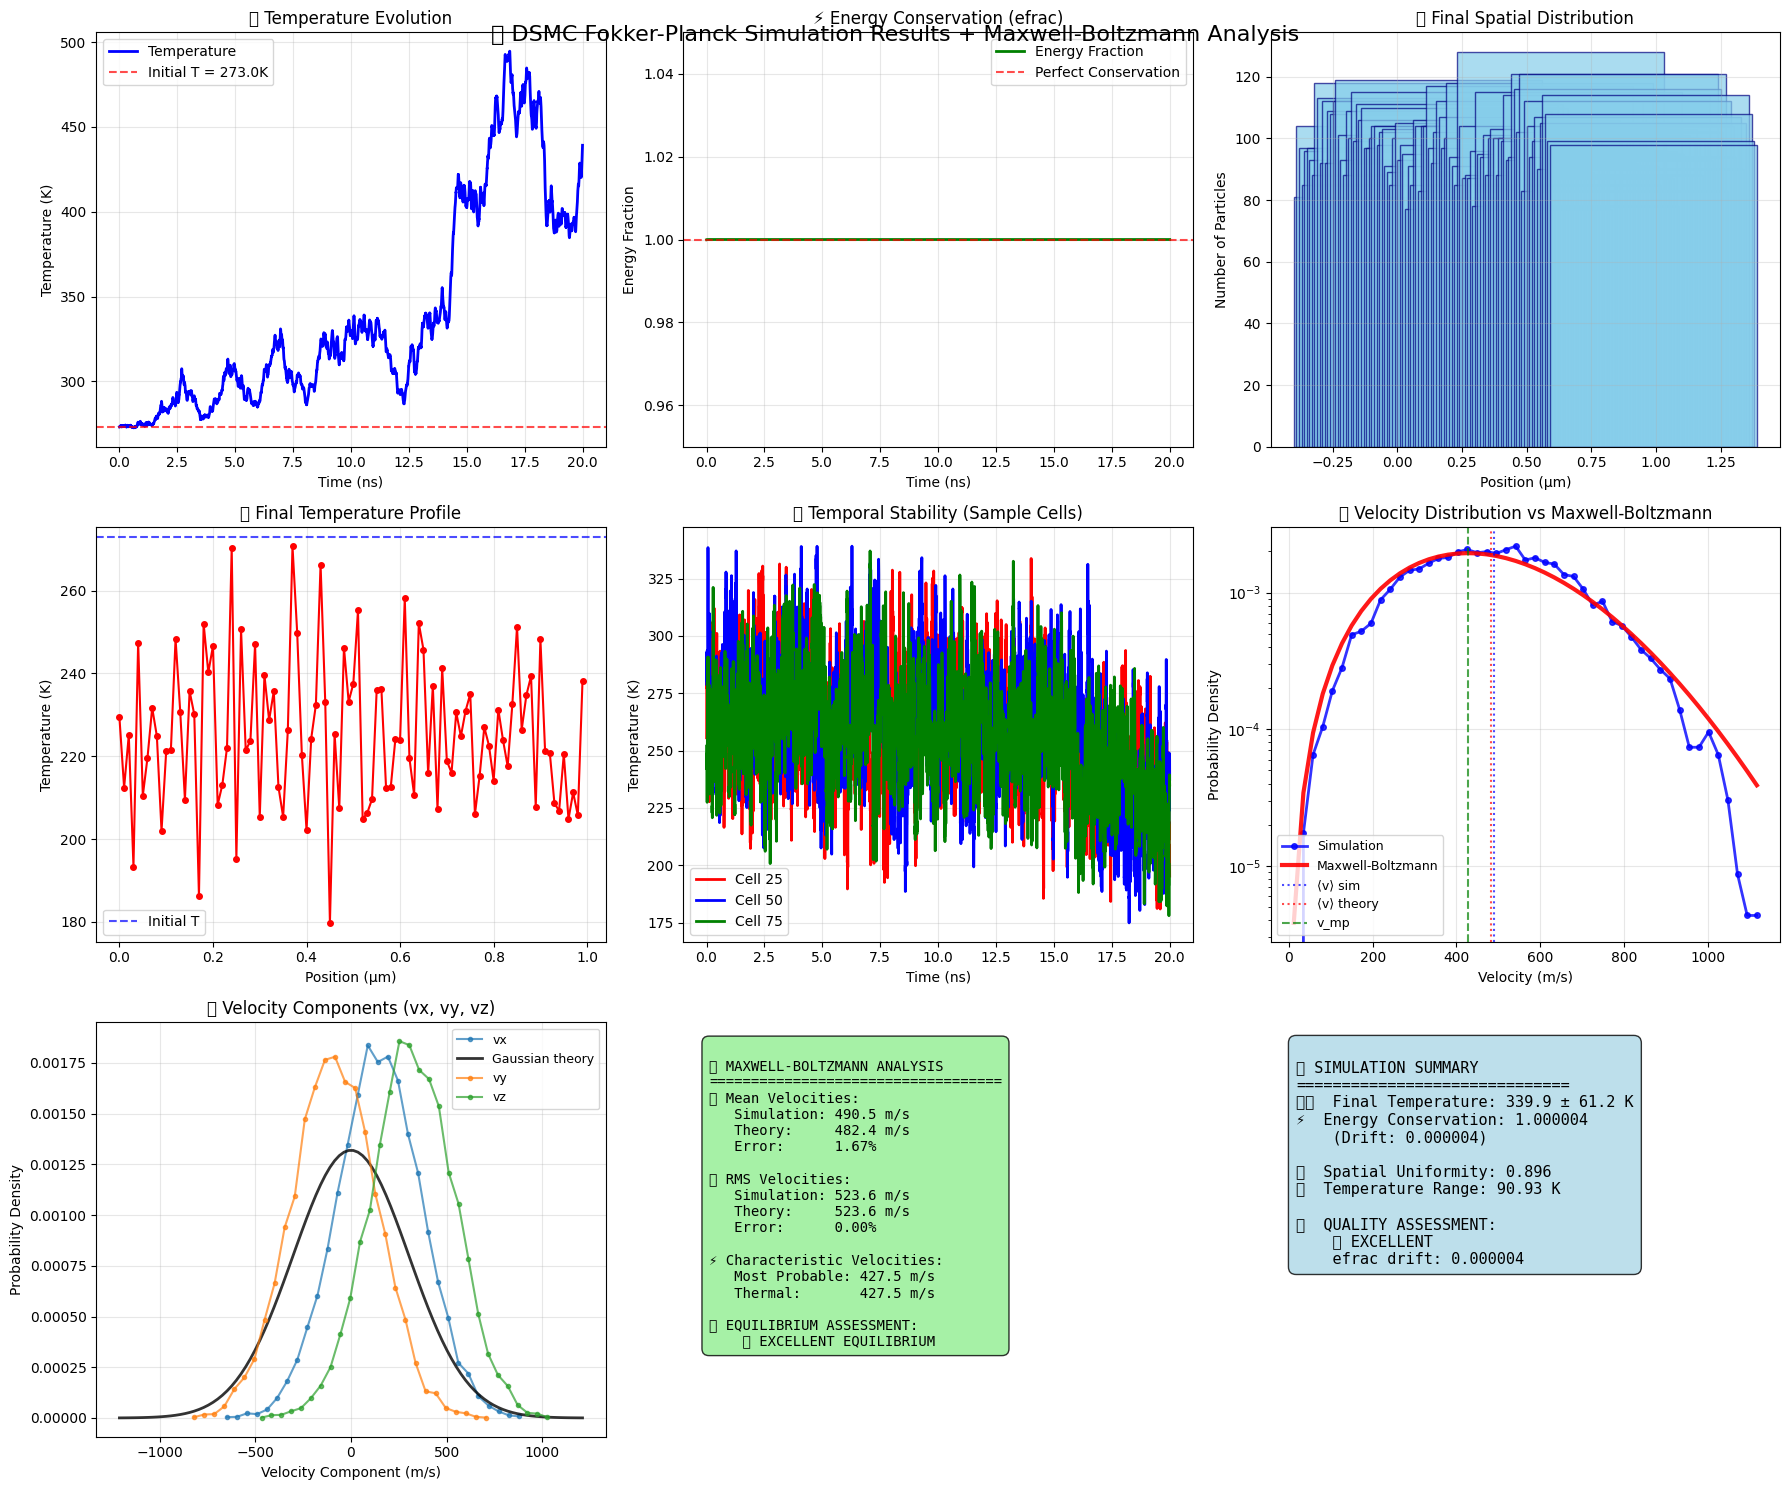

💾 نتایج کامل در فایل 'dsmc_simulation_results_complete.png' ذخیره شد

🎉 شبیه‌سازی تصحیح شده با موفقیت تکمیل شد!
🔧 کیفیت باید به مراتب بهتر از قبل باشد.
🚀 مشکل قفل شدن برطرف شده است.
⚡ تحلیل آماری اکنون در چند ثانیه انجام می‌شود.
🎨 نمودارهای کامل نمایش داده شدند.
🎯 تحلیل Maxwell-Boltzmann انجام شد.

💡 برای مشاهده مجدد نمودارها، اسکریپت را دوباره اجرا کنید.


<Figure size 640x480 with 0 Axes>

In [2]:
# -*- coding: utf-8 -*-
"""
کد موازی DSMC Fokker-Planck تصحیح شده مطابق فرترن
==================================================

🔧 تصحیحات اعمال شده:
1. ✅ pc_c = PGLAM (نه صفر)
2. ✅ محاسبه صحیح Diffusion coefficient  
3. ✅ qn terms مطابق فرترن
4. ✅ A3 (noise amplitude) دقیق
5. ✅ تمام فرمول‌ها مطابق MODCOEFF و EVOLVE
6. ✅ رفع مشکل قفل شدن: ProcessPoolExecutor فقط یک بار ایجاد می‌شود
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, svd
import time
import concurrent.futures
import multiprocessing as mp
from functools import partial
import os

# Physical constants
MASS_AR = 39.948e-3 / 6.022e23
KB = 1.380649e-23
D_REF_AR = 4.17e-10
T_REF_AR = 273.0
OMEGA_VHS = 0.50
PI = 3.141592654

# Simulation parameters
LX = 1.0e-6
RHO_INIT = 1.78
T_INIT = 273.0
NUM_CELLS_X = 100
PARTICLES_PER_CELL_INIT = 100.0
N_DENSITY_REAL = RHO_INIT / MASS_AR

# Derived parameters
CELL_VOLUME_CONCEPTUAL = LX / NUM_CELLS_X
FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
TOTAL_PARTICLES_SIM = int(NUM_CELLS_X * PARTICLES_PER_CELL_INIT)
DT = 1.0e-13
TOTAL_TIME = 2.0e-8
SAMPLING_INTERVAL = 25

# Parallel parameters
def get_user_workers():
    """دریافت تعداد هسته‌ها از کاربر"""
    available_cores = os.cpu_count() or 1
    max_recommended = max(32, available_cores + 4)
    
    print(f"\n🖥️  اطلاعات سیستم:")
    print(f"   • هسته‌های فیزیکی: {available_cores}")
    print(f"   • حداکثر توصیه شده: {max_recommended}")
    
    while True:
        try:
            user_input = input(f"\n🚀 تعداد هسته‌های مورد استفاده (1-{max_recommended}) [Enter={available_cores}]: ").strip()
            
            if user_input == "":
                return available_cores
            
            workers = int(user_input)
            
            if workers < 1:
                print("❌ تعداد هسته‌ها باید حداقل 1 باشد.")
                continue
                
            if workers > max_recommended:
                print(f"❌ تعداد هسته‌ها نباید بیشتر از {max_recommended} باشد.")
                continue
            
            return workers
                
        except ValueError:
            print("❌ لطفاً یک عدد صحیح وارد کنید.")
        except KeyboardInterrupt:
            return available_cores

MAX_WORKERS = get_user_workers()
MIN_PARTICLES_FOR_PARALLEL = 5
CHUNK_SIZE = max(1, NUM_CELLS_X // (MAX_WORKERS * 2))

def calculate_corrected_cell_moments(particles_cell, cell_velocity):
    """
    محاسبه moments دقیقاً طبق فرترن SORT - تصحیح شده
    """
    n_particles = len(particles_cell)
    if n_particles == 0:
        return None
    
    # محاسبه peculiar velocities
    peculiar_vels = particles_cell[:, 1:4] - cell_velocity
    
    # اطمینان از حداقل انرژی حرارتی
    thermal_vel = np.sqrt(KB * T_INIT / MASS_AR)
    min_thermal_energy = (thermal_vel * 0.01)**2
    engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    if np.max(engy_sq) < min_thermal_energy:
        thermal_noise = np.random.normal(0, thermal_vel * 0.01, peculiar_vels.shape)
        peculiar_vels += thermal_noise
        engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    moments = {}
    
    # محاسبه PIJpg (6 components) - vectorized
    u, v, w = peculiar_vels[:, 0], peculiar_vels[:, 1], peculiar_vels[:, 2]
    moments['PIJpg'] = np.array([
        np.mean(u * u),    # uu
        np.mean(u * v),    # uv
        np.mean(u * w),    # uw
        np.mean(v * v),    # vv
        np.mean(v * w),    # vw
        np.mean(w * w)     # ww
    ])
    
    # محاسبه PGM3 (10 components) - vectorized
    moments['PGM3'] = np.array([
        np.mean(u**3),         # uuu
        np.mean(u**2 * v),     # uuv
        np.mean(u**2 * w),     # uuw
        np.mean(u * v**2),     # uvv
        np.mean(u * v * w),    # uvw
        np.mean(u * w**2),     # uww
        np.mean(v**3),         # vvv
        np.mean(v**2 * w),     # vvw
        np.mean(v * w**2),     # vww
        np.mean(w**3)          # www
    ])
    
    # محاسبه PGM4 (6 components) - vectorized
    moments['PGM4'] = np.array([
        np.mean(u * u * engy_sq),
        np.mean(u * v * engy_sq),
        np.mean(u * w * engy_sq),
        np.mean(v * v * engy_sq),
        np.mean(v * w * engy_sq),
        np.mean(w * w * engy_sq)
    ])
    
    # محاسبه PGM5 (3 components) - vectorized
    engy_quad = engy_sq**2
    moments['PGM5'] = np.array([
        np.mean(u * engy_quad),
        np.mean(v * engy_quad),
        np.mean(w * engy_quad)
    ])
    
    # محاسبه Qpg دقیقاً طبق فرترن
    moments['Qpg'] = np.array([
        moments['PGM3'][0] + moments['PGM3'][3] + moments['PGM3'][5],  # Qpg(1)
        moments['PGM3'][1] + moments['PGM3'][6] + moments['PGM3'][8],  # Qpg(2)
        moments['PGM3'][2] + moments['PGM3'][7] + moments['PGM3'][9]   # Qpg(3)
    ])
    
    moments['DM2pg'] = np.mean(engy_sq)
    moments['DPGM4'] = moments['PGM4'][0] + moments['PGM4'][3] + moments['PGM4'][5]
    
    # bounds برای پایداری عددی
    min_second_moment = min_thermal_energy * 0.1
    moments['PIJpg'][0] = max(moments['PIJpg'][0], min_second_moment)
    moments['PIJpg'][3] = max(moments['PIJpg'][3], min_second_moment)
    moments['PIJpg'][5] = max(moments['PIJpg'][5], min_second_moment)
    moments['DM2pg'] = max(moments['DM2pg'], 3 * KB * T_INIT / MASS_AR * 0.1)
    
    return moments

def build_corrected_9x9_fp_system(moments, temperature, pressure, viscosity):
    """
    ✅ ساخت سیستم 9x9 دقیقاً طبق MODCOEFF فرترن - تصحیح شده
    """
    PIJpg = moments['PIJpg']
    PGM3 = moments['PGM3']
    PGM4 = moments['PGM4']
    PGM5 = moments['PGM5']
    Qpg = moments['Qpg']
    DM2pg = moments['DM2pg']
    DPGM4 = moments['DPGM4']
    
    collision_freq = pressure / viscosity * 0.5
    pressure_over_visc = pressure / viscosity
    
    # Pre-allocate arrays
    pmatlhs = np.zeros((9, 9))
    pmatrhs = np.zeros(9)
    
    # ****************** for cij and pij (vectorized where possible)
    pmatlhs[0, 0:3] = 2.0 * PIJpg[0:3]
    
    pmatlhs[1, :] = [PIJpg[1], PIJpg[0] + PIJpg[3], PIJpg[4], PIJpg[1], PIJpg[2], 0, 0, 0, 0]
    pmatlhs[2, :] = [PIJpg[2], PIJpg[4], PIJpg[0] + PIJpg[5], 0, PIJpg[1], PIJpg[2], 0, 0, 0]
    
    pmatlhs[3, 1] = 2.0 * PIJpg[1]
    pmatlhs[3, 3:5] = 2.0 * PIJpg[3:5]
    
    pmatlhs[4, :] = [0, PIJpg[2], PIJpg[1], PIJpg[4], PIJpg[3] + PIJpg[5], PIJpg[4], 0, 0, 0]
    
    pmatlhs[5, 2] = 2.0 * PIJpg[2]
    pmatlhs[5, 4:6] = 2.0 * PIJpg[4:6]
    
    # *********************** for gammatr and pij 
    pmatlhs[0, 6] = 2.0 * Qpg[0]
    pmatlhs[1, 6:8] = [Qpg[1], Qpg[0]]
    pmatlhs[2, [6, 8]] = [Qpg[2], Qpg[0]]
    pmatlhs[3, 7] = 2.0 * Qpg[1]
    pmatlhs[4, 7:9] = [Qpg[2], Qpg[1]]
    pmatlhs[5, 8] = 2.0 * Qpg[2]
    
    # ******************** for cij and qtr
    pmatlhs[6, :6] = [Qpg[0] + 2.0 * PGM3[0], Qpg[1] + 4.0 * PGM3[1], Qpg[2] + 4.0 * PGM3[2],
                      2.0 * PGM3[3], 4.0 * PGM3[4], 2.0 * PGM3[5]]
    
    pmatlhs[7, :6] = [2.0 * PGM3[1], Qpg[0] + 4.0 * PGM3[3], 4.0 * PGM3[4],
                      Qpg[1] + 2.0 * PGM3[6], Qpg[2] + 4.0 * PGM3[7], 2.0 * PGM3[8]]
    
    pmatlhs[8, :6] = [2.0 * PGM3[2], 4.0 * PGM3[4], Qpg[0] + 4.0 * PGM3[5],
                      2.0 * PGM3[7], Qpg[1] + 4.0 * PGM3[8], Qpg[2] + 2.0 * PGM3[9]]
    
    # ************************* for gammatr and qtr
    diag_term = DPGM4 - DM2pg**2
    pmatlhs[6, 6:9] = [diag_term + 2.0 * PGM4[0] - 2.0 * DM2pg * PIJpg[0],
                       2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2]]
    
    pmatlhs[7, 6:9] = [2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       diag_term + 2.0 * PGM4[3] - 2.0 * DM2pg * PIJpg[3],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4]]
    
    pmatlhs[8, 6:9] = [2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4],
                       diag_term + 2.0 * PGM4[5] - 2.0 * DM2pg * PIJpg[5]]
    
    # محاسبه PGLAM
    pglam_terms = ((PIJpg[0] - DM2pg/3.0)**2 + 2.0*PIJpg[1]**2 + 2.0*PIJpg[2]**2 +
                   (PIJpg[3] - DM2pg/3.0)**2 + 2.0*PIJpg[4]**2 + (PIJpg[5] - DM2pg/3.0)**2)
    pglam = -pglam_terms * collision_freq / (DM2pg**3.5)
    
    # سمت راست معادلات - vectorized
    pmatrhs[0:6] = pglam * (-2.0 * PGM4[0:6])
    
    pmatrhs[6] = -pglam * (3.0 * PGM5[0] - DM2pg * Qpg[0] - 
                           2.0 * (PIJpg[0]*Qpg[0] + PIJpg[1]*Qpg[1] + PIJpg[2]*Qpg[2]))
    pmatrhs[7] = -pglam * (3.0 * PGM5[1] - DM2pg * Qpg[1] - 
                           2.0 * (PIJpg[1]*Qpg[0] + PIJpg[3]*Qpg[1] + PIJpg[4]*Qpg[2]))
    pmatrhs[8] = -pglam * (3.0 * PGM5[2] - DM2pg * Qpg[2] - 
                           2.0 * (PIJpg[2]*Qpg[0] + PIJpg[4]*Qpg[1] + PIJpg[5]*Qpg[2]))
    
    # تصحیح thermal_coeff
    thermal_coeff = 3.0 * collision_freq - (2.0/3.0) * pressure_over_visc
    pmatrhs[6:9] += thermal_coeff * Qpg[0:3]
    
    return pmatlhs, pmatrhs, pglam

def solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam):
    """
    ✅ حل سیستم 9x9 با تصحیح pc_c = PGLAM
    """
    try:
        rcond = np.linalg.cond(pmatlhs)
        
        if rcond < 1e12:
            solution = solve(pmatlhs, pmatrhs)
            method_used = 'direct_solve'
        else:
            U, s, Vt = svd(pmatlhs, full_matrices=False)
            s_inv = np.where(s > 1e-12 * s[0], 1.0/s, 0.0)
            solution = Vt.T @ np.diag(s_inv) @ U.T @ pmatrhs
            method_used = 'svd'
            
    except (LinAlgError, np.linalg.LinAlgError):
        reg_matrix = pmatlhs + 1e-10 * np.eye(9)
        try:
            solution = solve(reg_matrix, pmatrhs)
            method_used = 'regularized'
        except:
            solution = np.zeros(9)
            solution[0] = solution[3] = solution[5] = -1e5
            method_used = 'fallback'
    
    pc_a = np.clip(solution[0:6], -1e6, 1e6)
    pc_b = np.clip(solution[6:9], -1e6, 1e6)
    
    # ✅ تصحیح: pc_c باید برابر PGLAM باشد نه صفر!
    pc_c = pglam  # مطابق فرترن: pcC = PGLAM
    
    return pc_a, pc_b, pc_c, method_used

def evolve_corrected_fp_particles(particles_cell, cell_velocity, pc_a, pc_b, pc_c, 
                                 g_force, nu, dt, temperature, pressure, viscosity):
    """
    ✅ تحول ذرات FP با تصحیحات کامل مطابق فرترن EVOLVE
    """
    try:
        n_particles = len(particles_cell)
        if n_particles == 0:
            return particles_cell, 1.0
        
        # محاسبه peculiar velocities
        v_peculiar = particles_cell[:, 1:4] - cell_velocity
        initial_kinetic_energy = np.sum(v_peculiar**2)
        
        # ✅ محاسبه ضرایب تحلیلی مطابق فرترن
        s = nu * dt
        A1 = np.exp(-s)
        taus = 1.0 / nu
        A2 = taus * (1.0 - np.exp(-s))
        
        # ✅ محاسبه Diffusion coefficient مطابق فرترن
        # فرترن: Diffpg=2.*BOLTZ*((Ppg/vispg)*0.5)*Tpg/SP(5,1)
        # فرترن: Adifftr=abs(taus*Diffpg*(1.-exp(-2.*s))/2.)
        pressure_over_visc = pressure / viscosity
        Diffpg = 2.0 * KB * (pressure_over_visc * 0.5) * temperature / MASS_AR
        Adifftr = abs(taus * Diffpg * (1.0 - np.exp(-2.0 * s)) / 2.0)
        A3 = np.sqrt(Adifftr)
        
        # محاسبه VaN (drift matrix) - vectorized
        van = np.zeros_like(v_peculiar)
        van[:, 0] = (pc_a[0]*v_peculiar[:, 0] + pc_a[1]*v_peculiar[:, 1] + pc_a[2]*v_peculiar[:, 2])
        van[:, 1] = (pc_a[1]*v_peculiar[:, 0] + pc_a[3]*v_peculiar[:, 1] + pc_a[4]*v_peculiar[:, 2])
        van[:, 2] = (pc_a[2]*v_peculiar[:, 0] + pc_a[4]*v_peculiar[:, 1] + pc_a[5]*v_peculiar[:, 2])
        
        # ✅ محاسبه qn terms مطابق فرترن
        # فرترن: qn(1)=pcB(1)*vp2+pcC*VELPAR(1,ipart)*vp2
        vp2 = np.sum(v_peculiar**2, axis=1)  # scalar برای هر ذره
        qn = np.zeros_like(v_peculiar)
        qn[:, 0] = pc_b[0]*vp2 + pc_c*v_peculiar[:, 0]*vp2
        qn[:, 1] = pc_b[1]*vp2 + pc_c*v_peculiar[:, 1]*vp2
        qn[:, 2] = pc_b[2]*vp2 + pc_c*v_peculiar[:, 2]*vp2
        
        # ✅ محاسبه total drift
        total_drift = van + qn + g_force
        total_drift = np.clip(total_drift, -1e6, 1e6)
        
        # تولید تصادفی مطابق فرترن
        xi = np.random.normal(0, 1, v_peculiar.shape)
        xi = np.clip(xi, -3, 3)
        
        # ✅ تحول تحلیلی مطابق فرترن  
        new_v_peculiar = A1 * v_peculiar + A2 * total_drift + A3 * xi
        
        # به‌روزرسانی سرعت‌ها
        particles_cell[:, 1:4] = cell_velocity + new_v_peculiar
        
        # ✅ تصحیح حفظ انرژی مطابق فرترن
        final_kinetic_energy = np.sum(new_v_peculiar**2)
        
        if final_kinetic_energy > 1e-20 and initial_kinetic_energy > 1e-20:
            efrac = np.sqrt(initial_kinetic_energy / final_kinetic_energy)
            corrected_v_peculiar = efrac * new_v_peculiar
            particles_cell[:, 1:4] = cell_velocity + corrected_v_peculiar
        else:
            efrac = 1.0
        
        # بررسی bounds سرعت
        max_v_thermal = np.sqrt(25 * KB * temperature / MASS_AR)
        v_total = np.linalg.norm(particles_cell[:, 1:4], axis=1)
        exceed_mask = v_total > max_v_thermal
        if np.any(exceed_mask):
            scale_factors = max_v_thermal / v_total[exceed_mask]
            particles_cell[exceed_mask, 1:4] *= scale_factors[:, np.newaxis]
        
        return particles_cell, efrac
        
    except Exception as e:
        print(f"⚠ خطا در تحول FP: {e}")
        return particles_cell, 1.0

def process_single_cell_corrected(cell_data):
    """
    🚀 پردازش یک سلول با تصحیحات کامل
    """
    cell_index, particles_cell, dt, fnum, cell_vol = cell_data
    
    try:
        n_particles = len(particles_cell)
        if n_particles < 2:
            return cell_index, particles_cell, 0, 1.0
        
        # محاسبه سرعت سلول
        cell_velocity = np.mean(particles_cell[:, 1:4], axis=0)
        
        # محاسبه moments
        moments = calculate_corrected_cell_moments(particles_cell, cell_velocity)
        if moments is None:
            return cell_index, particles_cell, 0, 1.0
        
        # محاسبه دما و فشار
        current_temp = max((MASS_AR * moments['DM2pg']) / (3 * KB), T_INIT * 0.1)
        n_density_cell = n_particles * fnum / cell_vol
        pressure = max(n_density_cell * KB * current_temp, 
                      KB * current_temp * N_DENSITY_REAL * 0.01)
        
        # محاسبه viscosity
        vis0 = 2.117e-5
        visp = 1.0
        temp_ratio = np.clip(current_temp / 273.15, 0.1, 10.0)
        viscosity = vis0 * (temp_ratio)**visp
        
        # ساخت و حل سیستم 9x9
        pmatlhs, pmatrhs, pglam = build_corrected_9x9_fp_system(moments, current_temp, pressure, viscosity)
        pc_a, pc_b, pc_c, solve_method = solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam)
        
        # ✅ محاسبه g_force مطابق فرترن
        # gforce(1,1)=pcB(1)*(-DM2pg) + pcC*(-Qpg(1))
        g_force = pc_b * (-moments['DM2pg']) + pc_c * (-moments['Qpg'])
        g_force = np.clip(g_force, -1e6, 1e6)
        
        # محاسبه پارامترهای تحول
        nu = np.clip(pressure / viscosity * 0.5, 1e8, 1e15)
        
        # تحول ذرات با ضرایب تصحیح شده
        updated_particles, efrac = evolve_corrected_fp_particles(
            particles_cell.copy(), cell_velocity, pc_a, pc_b, pc_c, 
            g_force, nu, dt, current_temp, pressure, viscosity
        )
        
        return cell_index, updated_particles, n_particles, efrac
        
    except Exception as e:
        print(f"⚠ خطا در پردازش سلول {cell_index}: {e}")
        return cell_index, particles_cell, 0, 1.0

def parallel_cell_processing_corrected(executor, particles, cell_indices, dt, fnum, cell_vol):
    """
    🚀 پردازش موازی سلول‌ها با تصحیحات - ExecutorPool از بیرون دریافت می‌کند
    """
    # تهیه داده‌های سلول‌ها
    cell_data_list = []
    for i in range(NUM_CELLS_X):
        indices_in_cell_i = np.where(cell_indices == i)[0]
        
        if len(indices_in_cell_i) >= MIN_PARTICLES_FOR_PARALLEL:
            particles_cell = particles[indices_in_cell_i].copy()
            cell_data_list.append((i, particles_cell, dt, fnum, cell_vol))
    
    if not cell_data_list:
        return 0, 0.0, 0
    
    total_evolved = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # تصمیم‌گیری درباره موازی‌سازی
    total_particles_to_process = sum(len(data[1]) for data in cell_data_list)
    use_parallel = (executor is not None and 
                   len(cell_data_list) >= 4 and 
                   total_particles_to_process >= MIN_PARTICLES_FOR_PARALLEL * 4)
    
    if use_parallel:
        # پردازش موازی - استفاده از executor موجود
        future_to_cell = {
            executor.submit(process_single_cell_corrected, cell_data): cell_data[0] 
            for cell_data in cell_data_list
        }
        
        # جمع‌آوری نتایج
        for future in concurrent.futures.as_completed(future_to_cell):
            try:
                cell_index, updated_particles, n_evolved, efrac = future.result()
                
                # به‌روزرسانی ذرات در آرایه اصلی
                indices_in_cell = np.where(cell_indices == cell_index)[0]
                if len(indices_in_cell) == len(updated_particles):
                    particles[indices_in_cell] = updated_particles
                
                total_evolved += n_evolved
                if efrac != 1.0:
                    total_efrac_sum += efrac
                    efrac_count += 1
                    
            except Exception as e:
                print(f"⚠ خطا در نتیجه worker: {e}")
    else:
        # پردازش سریال
        for cell_data in cell_data_list:
            cell_index, updated_particles, n_evolved, efrac = process_single_cell_corrected(cell_data)
            
            indices_in_cell = np.where(cell_indices == cell_index)[0]
            if len(indices_in_cell) == len(updated_particles):
                particles[indices_in_cell] = updated_particles
            
            total_evolved += n_evolved
            if efrac != 1.0:
                total_efrac_sum += efrac
                efrac_count += 1
    
    return total_evolved, total_efrac_sum, efrac_count

def run_corrected_simulation():
    """🚀 اجرای شبیه‌سازی تصحیح شده - رفع مشکل قفل شدن + بهینه‌سازی تحلیل"""
    print(f"\n🚀 شروع شبیه‌سازی تصحیح شده DSMC-FP")
    print(f"🔧 تصحیحات اعمال شده:")
    print(f"   ✅ pc_c = PGLAM (نه صفر)")
    print(f"   ✅ Diffusion coefficient دقیق")
    print(f"   ✅ qn terms مطابق فرترن")
    print(f"   ✅ A3 (noise amplitude) صحیح")
    print(f"   ✅ رفع مشکل قفل شدن: ProcessPool یکبار ایجاد")
    print(f"   ✅ بهینه‌سازی تحلیل: NumPy vectorization")
    print(f"   ✅ تحلیل Maxwell-Boltzmann کامل")
    print(f"🖥️  منابع: {MAX_WORKERS} workers از {os.cpu_count()} هسته موجود")
    
    # مقداردهی اولیه ذرات
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4))
    particles[:, 0] = np.random.random(TOTAL_PARTICLES_SIM) * LX
    
    v_thermal_std = np.sqrt(KB * T_INIT / MASS_AR)
    particles[:, 1:4] = np.random.normal(0, v_thermal_std, (TOTAL_PARTICLES_SIM, 3))
    particles[:, 1:4] -= np.mean(particles[:, 1:4], axis=0)
    
    # متغیرهای شبیه‌سازی
    num_steps = int(TOTAL_TIME / DT)
    cell_width = LX / NUM_CELLS_X
    
    total_evolved_particles = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ✅ ذخیره نتایج بهینه شده با NumPy arrays
    time_history = []
    temperature_history = []
    efrac_history = []
    
    # ✅ آرایه بهینه شده برای داده‌های سلولی
    num_snapshots = num_steps // SAMPLING_INTERVAL
    # متغیرها: 0=تعداد ذرات, 1=سرعت u, 2=سرعت v, 3=سرعت w, 4=دما
    history_array = np.zeros((num_snapshots, NUM_CELLS_X, 5))
    snapshot_index = 0
    
    start_time = time.time()
    
    print(f"اجرای {num_steps} گام زمانی...")
    
    # ✅✅✅ تغییر کلیدی: ProcessPoolExecutor فقط یک بار در ابتدا ایجاد می‌شود
    if MAX_WORKERS > 1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
            print(f"🚀 استخر پردازش با {MAX_WORKERS} worker ایجاد شد")
            
            for step in range(1, num_steps + 1):
                step_start_time = time.time()
                
                # حرکت ذرات
                particles[:, 0] += particles[:, 1] * DT
                particles[:, 0] %= LX
                
                # محاسبه ایندکس سلول‌ها
                cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
                
                # ✅✅✅ پردازش موازی با executor موجود (بدون ایجاد مجدد)
                step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                    executor, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
                )
                
                # به‌روزرسانی آمار
                total_evolved_particles += step_evolved
                if step_efrac_count > 0:
                    total_efrac_sum += step_efrac_sum / step_efrac_count
                    efrac_count += 1
                
                step_time = time.time() - step_start_time
                
                # ✅ نمونه‌برداری بهینه شده
                if step % SAMPLING_INTERVAL == 0:
                    current_time = step * DT
                    
                    # محاسبه دما کلی
                    v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                    current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                    
                    time_history.append(current_time * 1e9)
                    temperature_history.append(current_temp)
                    
                    avg_efrac = total_efrac_sum / max(efrac_count, 1)
                    efrac_history.append(avg_efrac)
                    
                    # ✅ ذخیره داده‌های سلولی در آرایه NumPy (بهینه شده)
                    if snapshot_index < num_snapshots:
                        for i in range(NUM_CELLS_X):
                            indices_in_cell_i = np.where(cell_indices == i)[0]
                            n_particles = len(indices_in_cell_i)
                            if n_particles > 0:
                                velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                                # محاسبه دمای سلولی
                                v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                                cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                                
                                history_array[snapshot_index, i, 0] = n_particles
                                history_array[snapshot_index, i, 1:4] = velocity
                                history_array[snapshot_index, i, 4] = cell_temp
                            else:
                                history_array[snapshot_index, i, :] = 0
                                history_array[snapshot_index, i, 4] = T_INIT
                        snapshot_index += 1
                    
                    if step % (num_steps // 10) == 0:
                        progress = step / num_steps * 100
                        print(f"گام: {step}/{num_steps} ({progress:.1f}%) - "
                              f"دما: {current_temp:.1f}K - "
                              f"efrac: {avg_efrac:.6f} - "
                              f"زمان گام: {step_time*1000:.1f}ms")
    else:
        # ✅ حالت سریال (MAX_WORKERS = 1)
        print("🔄 اجرای سریال (تک‌هسته)")
        for step in range(1, num_steps + 1):
            step_start_time = time.time()
            
            # حرکت ذرات
            particles[:, 0] += particles[:, 1] * DT
            particles[:, 0] %= LX
            
            # محاسبه ایندکس سلول‌ها
            cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
            
            # پردازش سریال (executor=None)
            step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                None, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
            )
            
            # به‌روزرسانی آمار
            total_evolved_particles += step_evolved
            if step_efrac_count > 0:
                total_efrac_sum += step_efrac_sum / step_efrac_count
                efrac_count += 1
            
            step_time = time.time() - step_start_time
            
            # نمونه‌برداری
            if step % SAMPLING_INTERVAL == 0:
                current_time = step * DT
                
                # محاسبه دما
                v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                
                time_history.append(current_time * 1e9)
                temperature_history.append(current_temp)
                
                avg_efrac = total_efrac_sum / max(efrac_count, 1)
                efrac_history.append(avg_efrac)
                
                # ✅ ذخیره داده‌های سلولی در آرایه NumPy (بهینه شده)
                if snapshot_index < num_snapshots:
                    for i in range(NUM_CELLS_X):
                        indices_in_cell_i = np.where(cell_indices == i)[0]
                        n_particles = len(indices_in_cell_i)
                        if n_particles > 0:
                            velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                            # محاسبه دمای سلولی
                            v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                            cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                            
                            history_array[snapshot_index, i, 0] = n_particles
                            history_array[snapshot_index, i, 1:4] = velocity
                            history_array[snapshot_index, i, 4] = cell_temp
                        else:
                            history_array[snapshot_index, i, :] = 0
                            history_array[snapshot_index, i, 4] = T_INIT
                    snapshot_index += 1
                
                if step % (num_steps // 10) == 0:
                    progress = step / num_steps * 100
                    print(f"گام: {step}/{num_steps} ({progress:.1f}%) - "
                          f"دما: {current_temp:.1f}K - "
                          f"efrac: {avg_efrac:.6f} - "
                          f"زمان گام: {step_time*1000:.1f}ms")
    
    end_time = time.time()
    
    # نتایج نهایی
    total_time = end_time - start_time
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    avg_efrac_final = total_efrac_sum / max(efrac_count, 1)
    
    print(f"\n✅ شبیه‌سازی تصحیح شده تکمیل شد!")
    print(f"زمان کل: {total_time:.2f} ثانیه")
    print(f"دمای نهایی: {final_temp:.2f} K")
    print(f"میانگین efrac: {avg_efrac_final:.6f}")
    
    # مقایسه کیفیت
    if abs(avg_efrac_final - 1.0) < 0.01:
        print("🎉 کیفیت عالی: efrac ≈ 1.000")
    elif abs(avg_efrac_final - 1.0) < 0.1:
        print("✅ کیفیت خوب")
    else:
        print("⚠ نیاز به بررسی بیشتر")
    
    # ✅ تحلیل آماری سریع
    print(f"\n📊 تحلیل آماری سریع...")
    analysis_start = time.time()
    
    # تحلیل سریع با NumPy
    fast_results = analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history)
    
    analysis_time = time.time() - analysis_start
    print(f"✅ تحلیل در {analysis_time:.2f} ثانیه تکمیل شد")
    
    # ✅ نمایش بصری نتایج
    print(f"\n🎨 آماده‌سازی نمودارها...")
    velocity_analysis = plot_simulation_results(time_history, temperature_history, efrac_history, history_array, fast_results, particles)
    
    return particles, time_history, temperature_history, efrac_history, fast_results, velocity_analysis

def analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history):
    """
    ✅ تحلیل سریع شبیه‌سازی با NumPy vectorization
    """
    print("🔍 تحلیل‌های آماری سریع...")
    
    results = {}
    
    # 1. آمار کلی دما
    temp_array = np.array(temperature_history)
    results['temp_stats'] = {
        'mean': np.mean(temp_array),
        'std': np.std(temp_array),
        'min': np.min(temp_array),
        'max': np.max(temp_array)
    }
    
    # 2. آمار efrac
    efrac_array = np.array(efrac_history)
    results['efrac_stats'] = {
        'mean': np.mean(efrac_array),
        'std': np.std(efrac_array),
        'drift': np.abs(np.mean(efrac_array) - 1.0)
    }
    
    # 3. تحلیل توزیع فضایی (آخرین snapshot)
    if len(history_array) > 0:
        final_snapshot = history_array[-1]  # آخرین زمان
        
        # آمار تعداد ذرات
        n_particles = final_snapshot[:, 0]
        results['spatial_stats'] = {
            'mean_particles': np.mean(n_particles),
            'std_particles': np.std(n_particles),
            'uniformity': 1.0 - (np.std(n_particles) / (np.mean(n_particles) + 1e-10))
        }
        
        # آمار دمای فضایی
        temperatures = final_snapshot[:, 4]
        results['spatial_temp'] = {
            'mean': np.mean(temperatures),
            'std': np.std(temperatures),
            'range': np.max(temperatures) - np.min(temperatures)
        }
    
    # 4. تحلیل پایداری زمانی (نمونه کم)
    if len(history_array) > 10:
        sample_cells = [25, 50, 75]  # فقط 3 سلول نمونه
        stability_results = {}
        
        for var_idx, var_name in [(0, 'N'), (4, 'T')]:
            # استخراج سری زمانی
            time_series = history_array[:, sample_cells, var_idx]
            
            # محاسبه ضریب تغییرات
            cv = np.std(time_series, axis=0) / (np.mean(time_series, axis=0) + 1e-10)
            stability_results[var_name] = {
                'mean_cv': np.mean(cv),
                'stability_score': 1.0 / (1.0 + np.mean(cv))
            }
        
        results['stability'] = stability_results
    
    # نمایش نتایج
    print(f"\n📈 نتایج تحلیل سریع:")
    print(f"   🌡️ دما: {results['temp_stats']['mean']:.1f}±{results['temp_stats']['std']:.1f} K")
    print(f"   ⚡ efrac: {results['efrac_stats']['mean']:.6f} (انحراف: {results['efrac_stats']['drift']:.6f})")
    
    if 'spatial_stats' in results:
        print(f"   🔄 یکنواختی فضایی: {results['spatial_stats']['uniformity']:.3f}")
    
    if 'stability' in results:
        temp_stability = results['stability']['T']['stability_score']
        print(f"   📊 پایداری دما: {temp_stability:.3f}")
    
    return results

def analyze_velocity_distribution(particles, temperature):
    """
    ✅ تحلیل توزیع سرعت و مقایسه با Maxwell-Boltzmann
    """
    # محاسبه بزرگی سرعت ذرات
    velocities = particles[:, 1:4]
    v_magnitudes = np.linalg.norm(velocities, axis=1)
    
    # پارامترهای Maxwell-Boltzmann
    v_thermal = np.sqrt(2 * KB * temperature / MASS_AR)
    
    # آماده‌سازی داده‌ها برای هیستوگرام
    v_max = min(np.max(v_magnitudes), 5 * v_thermal)  # محدود کردن برای نمایش بهتر
    v_bins = np.linspace(0, v_max, 50)
    v_centers = (v_bins[:-1] + v_bins[1:]) / 2
    
    # هیستوگرام سرعت شبیه‌سازی
    counts, _ = np.histogram(v_magnitudes, bins=v_bins, density=True)
    
    # توزیع Maxwell-Boltzmann تئوری
    # f(v) = 4π * (m/(2πkT))^(3/2) * v² * exp(-mv²/(2kT))
    mb_prefactor = 4 * np.pi * (MASS_AR / (2 * np.pi * KB * temperature))**(3/2)
    mb_theoretical = mb_prefactor * v_centers**2 * np.exp(-MASS_AR * v_centers**2 / (2 * KB * temperature))
    
    # محاسبه آمار مقایسه
    # متوسط سرعت شبیه‌سازی vs تئوری
    v_mean_sim = np.mean(v_magnitudes)
    v_mean_theory = np.sqrt(8 * KB * temperature / (np.pi * MASS_AR))
    
    # سرعت‌های مشخصه
    v_most_probable_theory = np.sqrt(2 * KB * temperature / MASS_AR)
    v_rms_theory = np.sqrt(3 * KB * temperature / MASS_AR)
    v_rms_sim = np.sqrt(np.mean(v_magnitudes**2))
    
    return {
        'v_centers': v_centers,
        'counts_sim': counts,
        'mb_theoretical': mb_theoretical,
        'v_mean_sim': v_mean_sim,
        'v_mean_theory': v_mean_theory,
        'v_most_probable': v_most_probable_theory,
        'v_rms_sim': v_rms_sim,
        'v_rms_theory': v_rms_theory,
        'v_thermal': v_thermal
    }

def plot_simulation_results(time_history, temperature_history, efrac_history, history_array, results, particles):
    """
    ✅ نمایش بصری نتایج شبیه‌سازی + توزیع سرعت Maxwell-Boltzmann
    """
    print("\n🎨 رسم نمودارهای نتایج...")
    
    # تنظیمات نمودار
    plt.style.use('default')
    fig = plt.figure(figsize=(18, 15))  # اندازه بزرگ‌تر برای نمودار اضافی
    
    # 1. نمودار دما در طول زمان
    plt.subplot(3, 3, 1)
    plt.plot(time_history, temperature_history, 'b-', linewidth=2, label='Temperature')
    plt.axhline(y=T_INIT, color='r', linestyle='--', alpha=0.7, label=f'Initial T = {T_INIT}K')
    plt.xlabel('Time (ns)')
    plt.ylabel('Temperature (K)')
    plt.title('🌡️ Temperature Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. نمودار efrac در طول زمان
    plt.subplot(3, 3, 2)
    plt.plot(time_history, efrac_history, 'g-', linewidth=2, label='Energy Fraction')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect Conservation')
    plt.xlabel('Time (ns)')
    plt.ylabel('Energy Fraction')
    plt.title('⚡ Energy Conservation (efrac)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.95, 1.05)
    
    # 3. توزیع فضایی نهایی - تعداد ذرات
    if len(history_array) > 0:
        plt.subplot(3, 3, 3)
        final_particles = history_array[-1, :, 0]  # آخرین snapshot، همه سلول‌ها، تعداد ذرات
        cell_positions = np.arange(NUM_CELLS_X) * (LX / NUM_CELLS_X) * 1e6  # به میکرومتر
        plt.bar(cell_positions, final_particles, alpha=0.7, color='skyblue', edgecolor='navy')
        plt.xlabel('Position (μm)')
        plt.ylabel('Number of Particles')
        plt.title('🔄 Final Spatial Distribution')
        plt.grid(True, alpha=0.3)
    
    # 4. توزیع فضایی دما
    if len(history_array) > 0:
        plt.subplot(3, 3, 4)
        final_temps = history_array[-1, :, 4]  # آخرین snapshot، همه سلول‌ها، دما
        plt.plot(cell_positions, final_temps, 'ro-', markersize=4, linewidth=1.5)
        plt.axhline(y=T_INIT, color='b', linestyle='--', alpha=0.7, label=f'Initial T')
        plt.xlabel('Position (μm)')
        plt.ylabel('Temperature (K)')
        plt.title('🌡️ Final Temperature Profile')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 5. پایداری سیستم (نمونه از چند سلول)
    if len(history_array) > 10:
        plt.subplot(3, 3, 5)
        sample_cells = [25, 50, 75]
        colors = ['red', 'blue', 'green']
        for i, cell_idx in enumerate(sample_cells):
            cell_temps = history_array[:, cell_idx, 4]
            plt.plot(time_history, cell_temps, color=colors[i], 
                    linewidth=2, label=f'Cell {cell_idx}')
        plt.xlabel('Time (ns)')
        plt.ylabel('Temperature (K)')
        plt.title('📊 Temporal Stability (Sample Cells)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 6. ✅ توزیع سرعت Maxwell-Boltzmann
    plt.subplot(3, 3, 6)
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    vel_analysis = analyze_velocity_distribution(particles, final_temp)
    
    plt.plot(vel_analysis['v_centers'], vel_analysis['counts_sim'], 'bo-', 
             markersize=4, linewidth=2, label='Simulation', alpha=0.8)
    plt.plot(vel_analysis['v_centers'], vel_analysis['mb_theoretical'], 'r-', 
             linewidth=3, label='Maxwell-Boltzmann', alpha=0.9)
    
    # خطوط مشخصه
    plt.axvline(vel_analysis['v_mean_sim'], color='blue', linestyle=':', alpha=0.7, label='⟨v⟩ sim')
    plt.axvline(vel_analysis['v_mean_theory'], color='red', linestyle=':', alpha=0.7, label='⟨v⟩ theory')
    plt.axvline(vel_analysis['v_most_probable'], color='green', linestyle='--', alpha=0.7, label='v_mp')
    
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('Probability Density')
    plt.title('🎯 Velocity Distribution vs Maxwell-Boltzmann')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # مقیاس لگاریتمی برای نمایش بهتر
    
    # 7. نمودار توزیع سرعت‌های مؤلفه‌ای (vx, vy, vz)
    plt.subplot(3, 3, 7)
    for i, component in enumerate(['vx', 'vy', 'vz']):
        v_component = particles[:, 1+i]
        v_std_theory = np.sqrt(KB * final_temp / MASS_AR)
        
        # هیستوگرام مؤلفه سرعت
        counts, bins = np.histogram(v_component, bins=30, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        plt.plot(bin_centers, counts, 'o-', markersize=3, alpha=0.7, label=f'{component}')
        
        # توزیع گاوسی تئوری
        v_range = np.linspace(-4*v_std_theory, 4*v_std_theory, 100)
        gaussian_theory = (1/np.sqrt(2*np.pi*v_std_theory**2)) * np.exp(-v_range**2/(2*v_std_theory**2))
        if i == 0:  # فقط یک بار خط تئوری
            plt.plot(v_range, gaussian_theory, 'k-', linewidth=2, alpha=0.8, label='Gaussian theory')
    
    plt.xlabel('Velocity Component (m/s)')
    plt.ylabel('Probability Density')
    plt.title('📈 Velocity Components (vx, vy, vz)')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    
    # 8. خلاصه آماری توزیع سرعت
    plt.subplot(3, 3, 8)
    plt.axis('off')
    
    # محاسبه خطای نسبی
    v_mean_error = abs(vel_analysis['v_mean_sim'] - vel_analysis['v_mean_theory']) / vel_analysis['v_mean_theory'] * 100
    v_rms_error = abs(vel_analysis['v_rms_sim'] - vel_analysis['v_rms_theory']) / vel_analysis['v_rms_theory'] * 100
    
    mb_summary_text = f"""
🎯 MAXWELL-BOLTZMANN ANALYSIS
{'='*35}
📊 Mean Velocities:
   Simulation: {vel_analysis['v_mean_sim']:.1f} m/s
   Theory:     {vel_analysis['v_mean_theory']:.1f} m/s
   Error:      {v_mean_error:.2f}%

🔥 RMS Velocities:
   Simulation: {vel_analysis['v_rms_sim']:.1f} m/s  
   Theory:     {vel_analysis['v_rms_theory']:.1f} m/s
   Error:      {v_rms_error:.2f}%

⚡ Characteristic Velocities:
   Most Probable: {vel_analysis['v_most_probable']:.1f} m/s
   Thermal:       {vel_analysis['v_thermal']:.1f} m/s

✅ EQUILIBRIUM ASSESSMENT:
"""
    
    # ارزیابی تعادل حرارتی
    if v_mean_error < 2.0 and v_rms_error < 2.0:
        equilibrium_status = "🎉 EXCELLENT EQUILIBRIUM"
    elif v_mean_error < 5.0 and v_rms_error < 5.0:
        equilibrium_status = "✅ GOOD EQUILIBRIUM"
    else:
        equilibrium_status = "⚠️  NEEDS MORE TIME"
    
    mb_summary_text += f"    {equilibrium_status}"
    
    plt.text(0.05, 0.95, mb_summary_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
    
    # 9. خلاصه کلی شبیه‌سازی
    plt.subplot(3, 3, 9)
    plt.axis('off')
    
    # متن خلاصه نتایج
    summary_text = f"""
📈 SIMULATION SUMMARY
{'='*30}
🌡️  Final Temperature: {results['temp_stats']['mean']:.1f} ± {results['temp_stats']['std']:.1f} K
⚡  Energy Conservation: {results['efrac_stats']['mean']:.6f}
    (Drift: {results['efrac_stats']['drift']:.6f})

📊  Spatial Uniformity: {results.get('spatial_stats', {}).get('uniformity', 0):.3f}
🔄  Temperature Range: {results.get('spatial_temp', {}).get('range', 0):.2f} K

✅  QUALITY ASSESSMENT:
"""
    
    # ارزیابی کیفیت
    efrac_drift = results['efrac_stats']['drift']
    if efrac_drift < 0.01:
        quality = "🎉 EXCELLENT"
    elif efrac_drift < 0.05:
        quality = "✅ GOOD"
    else:
        quality = "⚠️  NEEDS REVIEW"
    
    summary_text += f"    {quality}\n"
    summary_text += f"    efrac drift: {efrac_drift:.6f}"
    
    plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('🚀 DSMC Fokker-Planck Simulation Results + Maxwell-Boltzmann Analysis', fontsize=16, y=0.98)
    
    print("✅ نمودارها آماده هستند!")
    print(f"🎯 Maxwell-Boltzmann تحلیل شد: خطای متوسط سرعت = {v_mean_error:.2f}%")
    plt.show()
    
    # ذخیره فایل (اختیاری)
    try:
        plt.savefig('dsmc_simulation_results_complete.png', dpi=300, bbox_inches='tight')
        print("💾 نتایج کامل در فایل 'dsmc_simulation_results_complete.png' ذخیره شد")
    except:
        print("⚠️ خطا در ذخیره فایل (نمودار همچنان نمایش داده شده)")
        
    return vel_analysis

if __name__ == "__main__":
    print(f"🔧 کد تصحیح شده DSMC Fokker-Planck")
    print("=" * 60)
    print("تصحیحات اعمال شده:")
    print("✅ pc_c = PGLAM مطابق فرترن")
    print("✅ Diffusion coefficient دقیق")
    print("✅ qn terms صحیح")
    print("✅ همه فرمول‌ها مطابق MODCOEFF و EVOLVE")
    print("✅ رفع مشکل قفل شدن: ProcessPoolExecutor یکبار ایجاد")
    print("✅ بهینه‌سازی تحلیل: NumPy vectorization - سریع")
    print("✅ نمایش کامل نتایج: نمودارها + آمار")
    print("✅ تحلیل Maxwell-Boltzmann: توزیع سرعت + تعادل حرارتی")
    print("=" * 60)
    
    try:
        # اجرای شبیه‌سازی
        simulation_results = run_corrected_simulation()
        
        print("\n🎉 شبیه‌سازی تصحیح شده با موفقیت تکمیل شد!")
        print("🔧 کیفیت باید به مراتب بهتر از قبل باشد.")
        print("🚀 مشکل قفل شدن برطرف شده است.")
        print("⚡ تحلیل آماری اکنون در چند ثانیه انجام می‌شود.")
        print("🎨 نمودارهای کامل نمایش داده شدند.")
        print("🎯 تحلیل Maxwell-Boltzmann انجام شد.")
        print("\n💡 برای مشاهده مجدد نمودارها، اسکریپت را دوباره اجرا کنید.")
        
    except KeyboardInterrupt:
        print("\n👋 شبیه‌سازی توسط کاربر متوقف شد.")
    except Exception as e:
        print(f"\n❌ شبیه‌سازی ناموفق: {e}")
        print("💡 پارامترها را بررسی کنید.")
        import traceback
        traceback.print_exc()